In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import re
import os
import lightgbm as lgb
from scipy.stats import median_abs_deviation, ttest_rel, wilcoxon, permutation_test
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
import itertools

In [2]:
# Compute features
# (1) Make the same transformation as ladislas 
# centered and rectified data

def center_and_rectify(df_in_path, df_out_path):
    # Load the EMG data from a CSV file
    df = pd.read_csv(df_in_path)

    data_columns = [col for col in df.columns if col.startswith('data_point')]

    # Center and rectify the EMG signal for each trial
    # Subtract the mean of each trial and take the absolute value
    df[data_columns] = df[data_columns].apply(lambda x: np.abs(x - x.mean()), axis=1)

    df.to_csv(df_out_path, index=False)

input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/raw_data.csv'
output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'

center_and_rectify(input_csv, output_csv_file)

# test en corrigeant par la baseline puis en computant les metrics

def process_emg_data(df_in_path, df_out_path):
    # Load the centered and rectified data
    df = pd.read_csv(df_in_path)

    # Identify data columns

    data_columns = [c for c in df.columns if c.startswith('data_point')]
    # --- compute baseline mean/std from ALL baseline data points ---
    baseline = df[df['condition'] == 'control_baseline']

    def flatten_stats(group):
        vals = group[data_columns].to_numpy().ravel()
        mean = vals.mean()
        std = vals.std(ddof=0)  # ddof=0 to match population std unless you prefer ddof=1
        if std == 0 or np.isnan(std):
            std = 1e-8  # avoid divide-by-zero; you may also flag these channels
        return pd.Series({'baseline_mean': mean, 'baseline_std': std})

    baseline_stats = (
        baseline.groupby(['subject', 'channel'])
                .apply(flatten_stats)
                .reset_index()
    )

    df = df.merge(baseline_stats, on=['subject', 'channel'], how='left')

    # z-score each data point using those baseline stats
    z_scored_data = (df[data_columns].sub(df['baseline_mean'], axis=0))\
                                .div(df['baseline_std'], axis=0)
    z_scored_data.columns = [f'z_score_{c}' for c in data_columns]

    # then compute per-trial features from z_scored_data
    metrics_df = pd.DataFrame({
        'z_score': z_scored_data.mean(axis=1),
        'std':     z_scored_data.std(axis=1),
        'median':  z_scored_data.median(axis=1),
        'mad':     z_scored_data.apply(lambda x: median_abs_deviation(x), axis=1),
        'iqr':     z_scored_data.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25), axis=1),
    })

    # Combine the original df with the computed metrics
    result_df = pd.concat([df[['subject', 'trial', 'condition', 'channel']], metrics_df], axis=1)

    # Specify the columns to keep in the final DataFrame, renaming where needed
    columns_to_keep = ['subject', 'trial', 'condition', 'channel', 'z_score', 'std', 'median', 'mad', 'iqr']
    result_df = result_df[columns_to_keep]
    result_df.to_csv(df_out_path, index=False)

input_csv = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/centered_rectified_data.csv'
output_csv_file = 'C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/features_z.csv'

process_emg_data(input_csv, output_csv_file)

C:\Users\ocler\AppData\Local\Temp\ipykernel_2912\4167044644.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(flatten_stats)


In [3]:
# Pre processing
# Load the dataset
csv_file_path = "C:/Users/ocler/Documents/Académique/Inner_speech/Classif_EMG/csv/features_z.csv"
df = pd.read_csv(csv_file_path)

# Total number of subjects at the beginning
subjects_initial = df['subject'].unique()
num_subjects_initial = len(subjects_initial)
print(f"Total number of subjects before processing: {num_subjects_initial}")

# Total number of trials per condition at the beginning
trials_per_condition_initial = df['condition'].value_counts()
print("\nNumber of trials per condition before processing:")
print(trials_per_condition_initial)

# Number of trials per channel at the beginning
trials_per_channel_initial = df['channel'].value_counts()
print("\nNumber of trials per channel before processing:")
print(trials_per_channel_initial)

# Identify and remove rows with NaN values (e.g., remove subject S20)
rows_with_nan = df[df.isna().any(axis=1)]
subjects_with_nan = rows_with_nan['subject'].unique()
df_cleaned = df[~df['subject'].isin(subjects_with_nan)]
df_cleaned.to_csv('csv/features_cleaned.csv', index=False)

# Total number of subjects after removing NaNs
subjects_after_nan_removal = df_cleaned['subject'].unique()
num_subjects_after_nan_removal = len(subjects_after_nan_removal)
# print(f"\nTotal number of subjects after removing NaNs: {num_subjects_after_nan_removal}")

# # Total number of trials per condition after removing NaNs
# trials_per_condition_after_nan_removal = df_cleaned['condition'].value_counts()
# print("\nNumber of trials per condition after removing NaNs:")
# print(trials_per_condition_after_nan_removal)

# # Number of trials per channel after removing NaNs
# trials_per_channel_after_nan_removal = df_cleaned['channel'].value_counts()
# print("\nNumber of trials per channel after removing NaNs:")
# print(trials_per_channel_after_nan_removal)

# Define the metric and conditions to analyze
metric = 'z_score'
conditions = ['overt_speech', 'inner_speech', 'mind_wandering', 'mental_visualization']
df_filtered = df_cleaned[df_cleaned['condition'].isin(conditions)]


# Get the list of channels
channels = df_filtered['channel'].unique()

# Calculate the total number of trials before outlier removal
total_trials_before = len(df_filtered)
print(f"\nTotal number of trials before outlier removal: {total_trials_before}")

# Dictionary to store outliers
outliers_dict = {}

# Outlier detection parameters
IQR_multiplier = 5  # Using X * IQR

# Loop over each channel to detect outliers
for channel in channels:
    channel_df = df_filtered[df_filtered['channel'] == channel]

    # Detect outliers based on IQR for each condition within the channel
    for condition in conditions:
        condition_df = channel_df[channel_df['condition'] == condition]
        Q1 = condition_df[metric].quantile(0.25)
        Q3 = condition_df[metric].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - IQR_multiplier * IQR
        upper_bound = Q3 + IQR_multiplier * IQR

        # Identify outliers
        condition_outliers = condition_df[
            (condition_df[metric] < lower_bound) | (condition_df[metric] > upper_bound)
        ]

        # Add outliers to dictionary
        for idx, row in condition_outliers.iterrows():
            key = (channel, condition)
            if key not in outliers_dict:
                outliers_dict[key] = []
            outliers_dict[key].append((row['subject'], row['trial']))

# Print the total number of outliers detected
total_outliers = sum(len(trials) for trials in outliers_dict.values())
print(f"\nTotal number of outlier trials detected: {total_outliers}")

# Create a copy of df_filtered for removal of outliers
df_filtered_no_outliers = df_filtered.copy()

# # Remove the outliers from df_filtered_no_outliers
# for (channel, condition), subjects_trials in outliers_dict.items():
#     for subject, trial in subjects_trials:
#         df_filtered_no_outliers = df_filtered_no_outliers[
#             ~(
#                 (df_filtered_no_outliers['channel'] == channel) &
#                 (df_filtered_no_outliers['condition'] == condition) &
#                 (df_filtered_no_outliers['subject'] == subject) &
#                 (df_filtered_no_outliers['trial'] == trial)
#             )
#         ]

# Calculate the total number of trials after outlier removal
total_trials_after = len(df_filtered_no_outliers)
print(f"\nTotal number of trials after outlier removal: {total_trials_after}")

# # Total number of subjects after outlier removal
# subjects_after_outlier_removal = df_filtered_no_outliers['subject'].unique()
# num_subjects_after_outlier_removal = len(subjects_after_outlier_removal)
# print(f"Total number of subjects after outlier removal: {num_subjects_after_outlier_removal}")

# # Number of trials per condition after outlier removal
# trials_per_condition_after_outlier_removal = df_filtered_no_outliers['condition'].value_counts()
# print("\nNumber of trials per condition after outlier removal:")
# print(trials_per_condition_after_outlier_removal)

# # Number of trials per channel after outlier removal
# trials_per_channel_after_outlier_removal = df_filtered_no_outliers['channel'].value_counts()
# print("\nNumber of trials per channel after outlier removal:")
# print(trials_per_channel_after_outlier_removal)

# Optionally, you can save the cleaned dataset
df_filtered_no_outliers.to_csv('csv/features_no_outliers.csv', index=False)

# Create a DataFrame with subjects having trials in all the required channels
required_channels = ['ooi', 'nek', 'zyg', 'for', 'fro']

# Group by subject and trial, then filter groups that have all required channels
valid_trials = df_filtered_no_outliers.groupby(['subject', 'trial']).filter(
    lambda x: set(x['channel']) == set(required_channels)
)

# Create the new df
df_filtered_complete_trials = valid_trials

# Total number of subjects after selecting complete trials
subjects_after_complete_trials = df_filtered_complete_trials['subject'].unique()
num_subjects_after_complete_trials = len(subjects_after_complete_trials)
# print(f"\nTotal number of subjects after selecting complete trials: {num_subjects_after_complete_trials}")

# # Number of trials per condition after selecting complete trials
# trials_per_condition_after_complete_trials = df_filtered_complete_trials['condition'].value_counts()
# print("\nNumber of trials per condition after selecting complete trials:")
# print(trials_per_condition_after_complete_trials)

# # Number of trials per channel after selecting complete trials
# trials_per_channel_after_complete_trials = df_filtered_complete_trials['channel'].value_counts()
# print("\nNumber of trials per channel after selecting complete trials:")
# print(trials_per_channel_after_complete_trials)

# Save df_filtered_complete_trials as a CSV file
df_filtered_complete_trials.to_csv('csv/features_no_outliers_trials.csv', index=False)

# Pivot the DataFrame
df = pd.read_csv('csv/features_no_outliers_trials.csv')

df_wide = df.pivot_table(
    index=['subject', 'trial', 'condition'],
    columns='channel',
    values=['z_score', 'std', 'median', 'mad', 'iqr']
)

# Flatten the MultiIndex columns
df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Get the number of trials per condition for each subject
trials_per_condition = df_wide.groupby(['subject', 'condition']).size().reset_index(name='trial_count')

# Filter out the conditions with trial counts less than 4
valid_conditions = trials_per_condition[trials_per_condition['trial_count'] >= 4]

# Merge with the original dataframe to keep only valid trials
df_wide_filtered = pd.merge(df_wide, valid_conditions[['subject', 'condition']], on=['subject', 'condition'], how='inner')

# Total number of subjects after filtering conditions with less than 4 trials
subjects_final = df_wide_filtered['subject'].unique()
num_subjects_final = len(subjects_final)
print(f"\nTotal number of subjects after processing: {num_subjects_final}")

# Number of trials per condition after final filtering
trials_per_condition_final = df_wide_filtered['condition'].value_counts()
print("\nNumber of trials per condition after processing:")
print(trials_per_condition_final)

# Since after pivoting, 'channel' is no longer a column, all trials have data for all channels
# Therefore, the number of trials per channel is the same and equal to the number of rows
num_trials_final = len(df_wide_filtered)
channels_final = required_channels
print(f"\nNumber of trials per channel after processing:")
for channel in channels_final:
    print(f"{channel}: {num_trials_final}")


# List of all conditions
all_conditions = set(conditions)

# Get the conditions available for each subject
subject_conditions = df_wide_filtered.groupby('subject')['condition'].apply(set)

# Initialize lists to store subjects
subjects_with_all_conditions = []
subjects_missing_one_condition = []

# Iterate over subjects and their conditions
for subject, subj_conditions in subject_conditions.items():
    missing_conditions = all_conditions - subj_conditions
    num_missing = len(missing_conditions)
    if num_missing == 0:
        subjects_with_all_conditions.append(subject)
    elif num_missing == 1:
        subjects_missing_one_condition.append((subject, missing_conditions))

# Print the number of subjects with trials in all conditions
print(f"\nNumber of subjects with trials in all conditions: {len(subjects_with_all_conditions)}")

# Print the subjects missing one condition
print("\nSubjects missing one condition and the missing condition:")
for subject, missing in subjects_missing_one_condition:
    missing_condition = ', '.join(missing)
    print(f"Subject {subject} is missing condition: {missing_condition}")

Total number of subjects before processing: 35

Number of trials per condition before processing:
condition
overt_speech            6065
mental_visualization    5485
inner_speech            4690
control_baseline        1590
mind_wandering          1215
Name: count, dtype: int64

Number of trials per channel before processing:
channel
for    3809
fro    3809
nek    3809
ooi    3809
zyg    3809
Name: count, dtype: int64

Total number of trials before outlier removal: 17455

Total number of outlier trials detected: 315

Total number of trials after outlier removal: 17455

Total number of subjects after processing: 35

Number of trials per condition after processing:
condition
overt_speech            1213
mental_visualization    1097
inner_speech             938
mind_wandering           235
Name: count, dtype: int64

Number of trials per channel after processing:
ooi: 3483
nek: 3483
zyg: 3483
for: 3483
fro: 3483

Number of subjects with trials in all conditions: 32

Subjects missing one co

In [4]:
# Compare mean
def compute_mean_metrics_by_channel_condition(df, selected_channels, selected_metrics):
    # Generate the column names dynamically based on selected channels and metrics
    selected_columns = [
        f"{metric}_{channel}" for metric in selected_metrics for channel in selected_channels
    ]
    
    # Filter only columns that exist in the dataframe (in case some selected metrics are missing)
    selected_columns = [col for col in selected_columns if col in df.columns]
    
    # Compute the mean for each selected metric and channel combination by condition
    mean_metrics_by_channel_condition = df.groupby('condition')[selected_columns].mean()
    
    # Print the results
    print(f"\nMean metrics ({', '.join(selected_metrics)}) by selected channels ({', '.join(selected_channels)}) and condition:")
    print(mean_metrics_by_channel_condition)
    
    return mean_metrics_by_channel_condition

selected_channels = ['for', 'fro']
selected_metrics = ['z_score', 'iqr']
mean_metrics_df = compute_mean_metrics_by_channel_condition(df_wide_filtered, selected_channels, selected_metrics)


Mean metrics (z_score, iqr) by selected channels (for, fro) and condition:
                      z_score_for  z_score_fro   iqr_for   iqr_fro
condition                                                         
inner_speech             0.015712     2.022941  1.367778  3.331480
mental_visualization     0.051796     0.458143  1.406557  1.769462
mind_wandering          -0.094915     3.156915  1.254720  4.581421
overt_speech             0.321911     5.514045  1.687048  6.824180


Subject OC01 classification report:
              precision    recall  f1-score   support

         DIS       1.00      1.00      1.00         3
          MV       1.00      1.00      1.00         6
          OS       1.00      1.00      1.00         1
         VMW       1.00      1.00      1.00         1

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

Subject OC02 classification report:
              precision    recall  f1-score   support

         DIS       0.83      0.83      0.83         6
          MV       0.83      0.83      0.83         6
          OS       1.00      1.00      1.00         7
         VMW       0.00      0.00      0.00         1

    accuracy                           0.85        20
   macro avg       0.67      0.67      0.67        20
weighted avg       0.85      0.85      0.85        20

Subject OC03 classification report:
              precisio

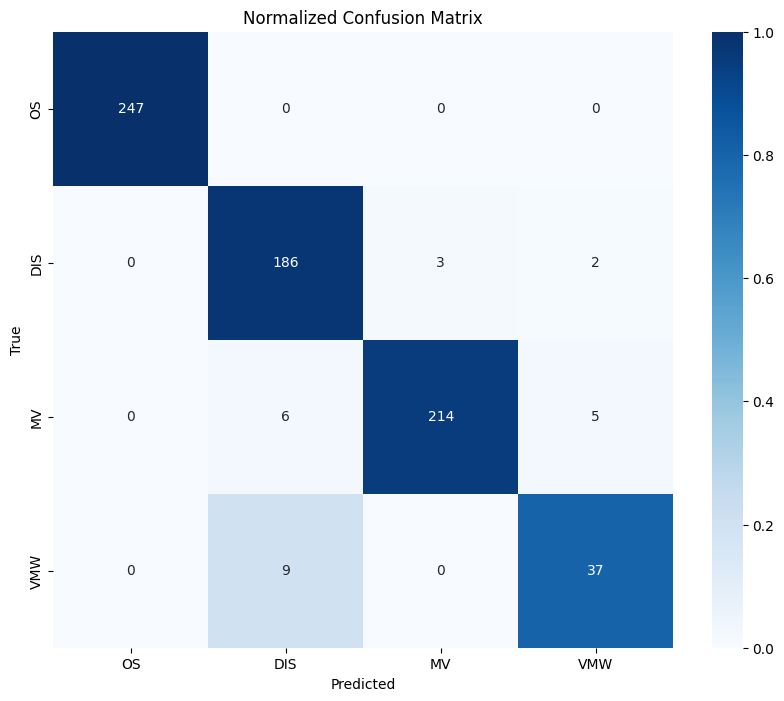

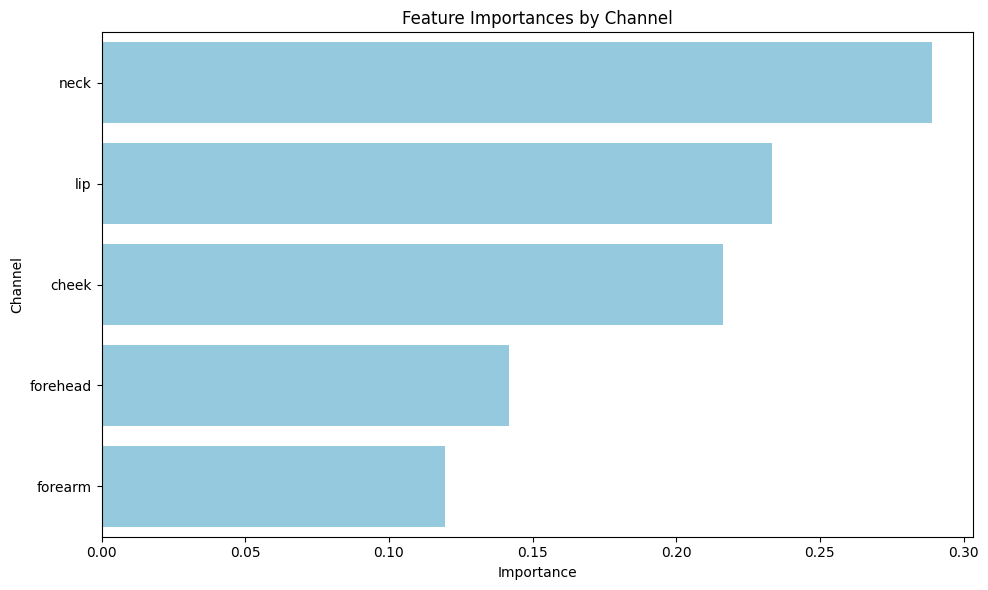


Aggregated Feature Importances by Channel:
 channel  importance
    neck    0.288952
     lip    0.233167
   cheek    0.216444
forehead    0.141829
 forearm    0.119609


In [6]:
# rf by subject with a test set in %

def train_and_evaluate(df, channels, features, conditions, seed=42):
    """
    Trains and evaluates a RandomForestClassifier for each subject using specified channels and features.
    
    Parameters:
    df (pd.DataFrame): The input dataframe in wide format.
    channels (list): List of channels to include in the features.
    features (list): List of feature names to include.
    conditions (list): List of conditions to include in the model.
    seed (int): Random seed for reproducibility.
    """
    np.random.seed(seed)
    
    # Define label mapping
    label_mapping = {
        'mind_wandering': 'VMW',
        'inner_speech': 'DIS',
        'mental_visualization': 'MV',
        'overt_speech': 'OS'
    }
    
    # Filter dataframe for specified conditions
    df = df[df['condition'].isin(conditions)]
    
    # Dictionary to store models for each subject
    subject_models = {}

    # Lists to store all true labels and predictions across subjects
    all_y_test = []
    all_y_pred = []
    feature_importances = []

    # Hyperparameter grid
    param_grid = {
        'n_estimators': [25, 50, 60, 75, 100, 200],
        'max_depth': [5, 10, 15, 20, 25],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }

    # Iterate over each subject
    for subject in df['subject'].unique():
        # Filter data for the current subject
        subject_data = df[df['subject'] == subject]

        # Create a list of columns to include based on specified features and channels
        selected_columns = [f"{feature}_{channel}" for feature in features for channel in channels]

        # Separate features (X) and labels (y)
        X = subject_data[selected_columns]
        y = subject_data['condition']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed, stratify=y
        )

        # Initialize the RandomForestClassifier
        rf = RandomForestClassifier(random_state=seed)

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=2,
            n_jobs=-1,
            scoring='f1_weighted'
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Predict the labels for the test set
        y_pred = best_model.predict(X_test)

        # Map the original labels to abbreviations
        y_test_mapped = y_test.map(label_mapping)
        y_pred_mapped = pd.Series(y_pred).map(label_mapping)

        # Append the true labels and predictions to the lists
        all_y_test.extend(y_test_mapped)
        all_y_pred.extend(y_pred_mapped)

        # Append feature importances
        feature_importances.append(best_model.feature_importances_)

        # Print the classification report for the current subject
        print(f"Subject {subject} classification report:")
        print(classification_report(y_test_mapped, y_pred_mapped, zero_division=0))

        # Store the trained model in the dictionary
        subject_models[subject] = best_model

    # Print the global classification report
    print("Global classification report:")
    print(classification_report(all_y_test, all_y_pred, zero_division=0))
    print(f"Global balanced accuracy: {balanced_accuracy_score(all_y_test, all_y_pred):.2f}")
    print(f"Global F1-score: {f1_score(all_y_test, all_y_pred, average='weighted'):.2f}")

    # Bootstrapping to estimate 95% confidence interval for test balanced accuracy
    n_iterations = 1000
    bootstrap_accuracies = []

    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(all_y_test)), size=len(all_y_test), replace=True)
        y_test_bootstrap = np.array(all_y_test)[bootstrap_indices]
        y_pred_bootstrap = np.array(all_y_pred)[bootstrap_indices]
        bootstrap_accuracy = balanced_accuracy_score(y_test_bootstrap, y_pred_bootstrap)
        bootstrap_accuracies.append(bootstrap_accuracy)

    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for Test Balanced Accuracy: [{lower_bound:.2f}, {upper_bound:.2f}]")

    # Compute the confusion matrix
    label_order = ['OS', 'DIS', 'MV', 'VMW']
    cm = confusion_matrix(all_y_test, all_y_pred, labels=label_order)
    
    # Normalize the confusion matrix per row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with zeros

    # Calculate the proportion of correctly predicted data points for each condition
    for i, label in enumerate(label_order):
        proportion_correct = cm_normalized[i, i]
        print(f"Proportion of data points correctly predicted for condition '{label}': {proportion_correct:.2f}")
    
    # Plot the normalized confusion matrix with counts as annotations
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=cm,
        fmt='d',
        cmap='Blues',
        xticklabels=label_order,
        yticklabels=label_order,
        vmin=0,
        vmax=1
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Compute mean feature importance across subjects
    mean_feature_importances = np.mean(feature_importances, axis=0)
    feature_importance_df = pd.DataFrame({'feature': selected_columns, 'importance': mean_feature_importances})

    # Extract channels from feature names
    feature_importance_df['channel'] = feature_importance_df['feature'].apply(lambda x: x.split('_')[-1])

    # Sum importances by channel
    channel_importance_df = feature_importance_df.groupby('channel')['importance'].sum().reset_index()

    # Sort channels by importance
    channel_importance_df = channel_importance_df.sort_values(by='importance', ascending=False)

    # Replace channel names for the plot
    channel_name_mapping = {
        'nek': 'neck',
        'zyg': 'cheek',
        'ooi': 'lip',
        'chn': 'chin',
        'fro': 'forehead',
        'for': 'forearm'
    }

    # Apply the mapping to the 'channel' column
    channel_importance_df['channel'] = channel_importance_df['channel'].replace(channel_name_mapping)

    # Plot the channel importances
    plt.figure(figsize=(10, 6))
    sns.barplot(data=channel_importance_df, x='importance', y='channel', color='skyblue')
    plt.title('Feature Importances by Channel')
    plt.xlabel('Importance')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()

    # Print the feature importances aggregated by channel
    print("\nAggregated Feature Importances by Channel:")
    print(channel_importance_df.to_string(index=False))

# Example usage:
channels = ['for', 'fro', 'nek', 'ooi', 'zyg']
features = ['z_score', 'iqr', 'mad', 'median', 'std']
conditions = ['mind_wandering', 'inner_speech', 'mental_visualization', 'overt_speech']
train_and_evaluate(df_wide_filtered, channels, features, conditions)

In [ ]:
# rf by subject with a test set in % MORE ROBUST (more CV)

def train_eval_within_subject_cv(
    df, channels, features, conditions,
    seed=42, n_splits=5, n_repeats=5, param_grid=None,
    show_progress=True, gs_verbose=0
):
    """
    Per-subject evaluation using repeated stratified K-fold with nested CV.
    Adds optional progress bars / minimal prints.

    Args:
        show_progress: if True, show tqdm progress bars (fallback to prints if tqdm missing)
        gs_verbose: verbosity passed to GridSearchCV (0 = silent; avoid big logs)
    """
    rng = np.random.RandomState(seed)
    df = df[df["condition"].isin(conditions)].copy()

    # columns
    selected_cols = [f"{f}_{c}" for f in features for c in channels]

    # label mapping just for reporting
    lab_map = {
        "overt_speech": "OS",
        "inner_speech": "DIS",
        "mental_visualization": "MV",
        "mind_wandering": "VMW",
    }
    lab_order = ["OS", "DIS", "MV", "VMW"]

    # default RF search space (balanced, modest)
    if param_grid is None:
        param_grid = {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 3],
            "min_samples_leaf": [1, 2],
            "class_weight": ["balanced"],
        }

    # tqdm fallback
    if show_progress:
        try:
            from tqdm.auto import tqdm
        except Exception:
            tqdm = None
    else:
        tqdm = None

    all_true, all_pred = [], []
    per_subject = {}
    subjects = list(df["subject"].unique())

    subj_iter = subjects
    subj_bar = None
    if tqdm is not None:
        subj_bar = tqdm(subj_iter, desc="Subjects", leave=True)
    else:
        print(f"Subjects to process: {len(subjects)}")

    def _print(msg):
        if tqdm is None:
            print(msg)

    for subj in (subj_bar if subj_bar is not None else subj_iter):
        d = df[df["subject"] == subj]
        X = d[selected_cols]
        y = d["condition"]

        min_per_class = y.value_counts().min()
        if min_per_class < 2 or y.nunique() < 2:
            _print(f"[skip] Subject {subj}: insufficient samples per class.")
            continue

        k_outer = max(2, min(n_splits, min_per_class))
        rskf = RepeatedStratifiedKFold(
            n_splits=k_outer, n_repeats=n_repeats, random_state=seed
        )
        total_outer = k_outer * n_repeats

        fold_bar = None
        if tqdm is not None:
            fold_bar = tqdm(total=total_outer, desc=f"Subj {subj} outer folds", leave=False)

        _print(f"Subject {subj}: outer={total_outer} (k={k_outer}×rep={n_repeats}).")

        balaccs = []
        y_true_s, y_pred_s = [], []
        outer_idx = 0

        for tr, te in rskf.split(X, y):
            outer_idx += 1
            Xtr, Xte = X.iloc[tr], X.iloc[te]
            ytr, yte = y.iloc[tr], y.iloc[te]

            min_per_class_tr = ytr.value_counts().min()
            k_inner = max(2, min(5, min_per_class_tr))
            inner = StratifiedKFold(n_splits=k_inner, shuffle=True, random_state=seed)

            rf = RandomForestClassifier(random_state=seed)
            gs = GridSearchCV(
                rf,
                param_grid,
                cv=inner,
                scoring="balanced_accuracy",
                n_jobs=-1,       # parallelize across param combos
                refit=True,
                verbose=gs_verbose
            )
            gs.fit(Xtr, ytr)
            yhat = gs.predict(Xte)

            bal = balanced_accuracy_score(yte, yhat)
            balaccs.append(bal)
            y_true_s.extend(pd.Series(yte).map(lab_map))
            y_pred_s.extend(pd.Series(yhat).map(lab_map))

            if fold_bar is not None:
                fold_bar.update(1)
                fold_bar.set_postfix_str(f"BA={np.mean(balaccs):.3f}")
            else:
                # print every few folds to avoid spam
                if (outer_idx % max(1, total_outer // 5)) == 0 or outer_idx == total_outer:
                    _print(f"  Fold {outer_idx}/{total_outer}: running BA={np.mean(balaccs):.3f}")

        if fold_bar is not None:
            fold_bar.close()

        per_subject[subj] = {
            "mean_balacc": float(np.mean(balaccs)),
            "std_balacc": float(np.std(balaccs, ddof=1)) if len(balaccs) > 1 else 0.0,
            "n_folds": len(balaccs),
        }

        all_true.extend(y_true_s)
        all_pred.extend(y_pred_s)

        _print(f"Subject {subj} done: BA={per_subject[subj]['mean_balacc']:.3f} ± {per_subject[subj]['std_balacc']:.3f} over {per_subject[subj]['n_folds']} folds.")

    # global report across folds/subjects
    print("Within-subject CV — Global classification report:")
    print(classification_report(all_true, all_pred, zero_division=0, labels=lab_order))
    print(f"Global balanced accuracy: {balanced_accuracy_score(all_true, all_pred):.3f}")

    # bootstrap CI over pooled predictions
    boot = []
    y_true = np.array(all_true); y_pred = np.array(all_pred)
    for _ in range(1000):
        idx = rng.choice(len(y_true), size=len(y_true), replace=True)
        boot.append(balanced_accuracy_score(y_true[idx], y_pred[idx]))
    lo, hi = np.percentile(boot, [2.5, 97.5])
    print(f"95% CI (bootstrap): [{lo:.3f}, {hi:.3f}]")

    cm = confusion_matrix(all_true, all_pred, labels=lab_order)
    per_subject_df = pd.DataFrame.from_dict(per_subject, orient="index")

    return per_subject_df, cm


channels = ['for', 'fro', 'nek', 'ooi', 'zyg']  # forearm, forehead, neck, lip, cheek
features = ['z_score', 'iqr', 'mad', 'median', 'std']
conditions = ['mind_wandering', 'inner_speech', 'mental_visualization', 'overt_speech']

# A) Within-subject
per_subject_df, cm_within = train_eval_within_subject_cv(
    df_wide_filtered, channels, features, conditions, seed=42, n_splits=5, n_repeats=5
)


Subjects:   0%|          | 0/35 [00:00<?, ?it/s]

Subj OC01 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC02 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC03 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC04 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC05 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC06 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC07 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC09 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC10 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC11 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC12 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC13 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC15 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC16 outer folds:   0%|          | 0/20 [00:00<?, ?it/s]

Subj OC17 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC18 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC19 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC20 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC21 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC22 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC23 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC24 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC25 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC26 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC27 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC28 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC32 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC33 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC34 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC36 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC37 outer folds:   0%|          | 0/20 [00:00<?, ?it/s]

Subj OC38 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC40 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC41 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Subj OC42 outer folds:   0%|          | 0/25 [00:00<?, ?it/s]

Within-subject CV — Global classification report:
              precision    recall  f1-score   support

          OS       1.00      1.00      1.00      6065
         DIS       0.94      0.95      0.94      4690
          MV       0.95      0.98      0.96      5485
         VMW       0.91      0.78      0.84      1175

    accuracy                           0.96     17415
   macro avg       0.95      0.93      0.94     17415
weighted avg       0.96      0.96      0.96     17415

Global balanced accuracy: 0.925
95% CI (bootstrap): [0.919, 0.931]


In [17]:
def oof_confusion_matrix_within_subject(
    df, channels, features, conditions, seed=42, k_outer=5, param_grid=None, lab_order=None
):
    """
    Build a display confusion matrix using per-subject OOF predictions:
      - Outer: StratifiedKFold (k_outer) within each subject
      - Inner: StratifiedKFold on the training folds (nested tuning)
    Each trial is predicted exactly once. No leakage.
    """
    if lab_order is None:
        lab_order = ["OS","DIS","MV","VMW"]

    label_map = {
        "overt_speech": "OS",
        "inner_speech": "DIS",
        "mental_visualization": "MV",
        "mind_wandering": "VMW",
    }
    if param_grid is None:
        param_grid = {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 3],
            "min_samples_leaf": [1, 2],
            "class_weight": ["balanced"],
        }

    df = df[df["condition"].isin(conditions)].copy()
    selected_cols = [f"{f}_{c}" for f in features for c in channels]

    all_true, all_pred = [], []

    for subj in df["subject"].unique():
        d = df[df["subject"] == subj]
        X, y = d[selected_cols], d["condition"]

        vc = y.value_counts()
        if y.nunique() < 2 or vc.min() < 2:
            # not enough data to stratify
            continue

        # adapt outer folds to smallest class if needed
        k = max(2, min(k_outer, int(vc.min())))
        outer = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

        for tr, te in outer.split(X, y):
            Xtr, Xte = X.iloc[tr], X.iloc[te]
            ytr, yte = y.iloc[tr], y.iloc[te]

            # inner CV on training fold only
            min_tr = ytr.value_counts().min()
            k_inner = max(2, min(5, int(min_tr)))
            inner = StratifiedKFold(n_splits=k_inner, shuffle=True, random_state=seed)

            rf = RandomForestClassifier(random_state=seed)
            gs = GridSearchCV(
                rf, param_grid, cv=inner, scoring="balanced_accuracy",
                n_jobs=-1, refit=True, verbose=0
            )
            gs.fit(Xtr, ytr)
            yhat = gs.predict(Xte)

            all_true.extend(pd.Series(yte).map(label_map))
            all_pred.extend(pd.Series(yhat).map(label_map))

    # CM with each trial used once as test
    cm = confusion_matrix(all_true, all_pred, labels=lab_order)

    # Row-normalize for colors/recalls
    row_sums = np.clip(cm.sum(axis=1, keepdims=True), 1, None)
    cm_norm = cm.astype(float) / row_sums

    print("\nProportion of test trials correctly predicted per condition (row recall):")
    for lbl, val in zip(lab_order, np.diag(cm_norm)):
        print(f"  {lbl}: {val:.2f}")

    print("\nOOF classification report (display-only):")
    print(classification_report(all_true, all_pred, zero_division=0, labels=lab_order))

    # Plot normalized intensities with raw counts annotated
    fig, ax = plt.subplots(figsize=(7,6))
    im = ax.imshow(cm_norm, interpolation='nearest', vmin=0, vmax=1)
    ax.set_title('OOF Confusion Matrix (within-subject, nested tuning)')
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_xticks(range(len(lab_order))); ax.set_xticklabels(lab_order)
    ax.set_yticks(range(len(lab_order))); ax.set_yticklabels(lab_order)
    for i in range(len(lab_order)):
        for j in range(len(lab_order)):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

    return cm, cm_norm, lab_order

Within-subject BA (mean ± SD across subjects): 0.924 ± 0.067
Median [IQR]: 0.943 [0.900, 0.965]
95% CI for mean BA (subject-level bootstrap): [0.900, 0.944]

Proportion of test trials correctly predicted per condition (row recall):
  OS: 1.00
  DIS: 0.95
  MV: 0.98
  VMW: 0.80

OOF classification report (display-only):
              precision    recall  f1-score   support

          OS       1.00      1.00      1.00      1213
         DIS       0.95      0.95      0.95       938
          MV       0.95      0.98      0.97      1097
         VMW       0.92      0.80      0.86       235

    accuracy                           0.97      3483
   macro avg       0.95      0.93      0.94      3483
weighted avg       0.97      0.97      0.96      3483



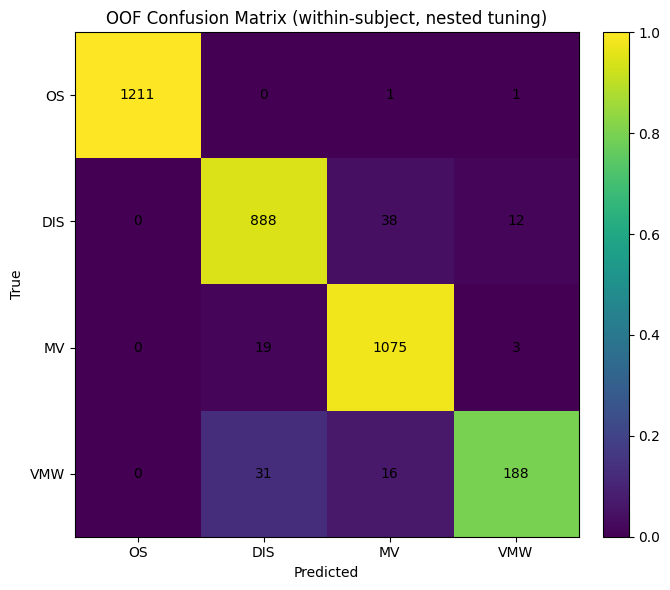


Proportion correctly predicted (OOF):
  OS: 1.00
  DIS: 0.95
  MV: 0.98
  VMW: 0.80


In [18]:
# per_subject_df, cm_within = train_eval_within_subject_cv(...)
ba = per_subject_df['mean_balacc']
print(f"Within-subject BA (mean ± SD across subjects): {ba.mean():.3f} ± {ba.std(ddof=1):.3f}")
print(f"Median [IQR]: {ba.median():.3f} [{ba.quantile(0.25):.3f}, {ba.quantile(0.75):.3f}]")

# Optional: CI for the mean via subject-level bootstrap
rng = np.random.RandomState(42)
boots = [ba.sample(len(ba), replace=True, random_state=rng).mean() for _ in range(5000)]
lo, hi = np.percentile(boots, [2.5, 97.5])
print(f"95% CI for mean BA (subject-level bootstrap): [{lo:.3f}, {hi:.3f}]")

cm_oof, cm_oof_norm, lab_order = oof_confusion_matrix_within_subject(
    df_wide_filtered, channels, features, conditions, seed=42, k_outer=5
)

print("\nProportion correctly predicted (OOF):")
for lbl, val in zip(lab_order, np.diag(cm_oof_norm)):
    print(f"  {lbl}: {val:.2f}")


Subject OC01 classification report:
                      precision    recall  f1-score   support

        inner_speech       1.00      1.00      1.00         3
mental_visualization       1.00      1.00      1.00         5
      mind_wandering       1.00      1.00      1.00         1

            accuracy                           1.00         9
           macro avg       1.00      1.00      1.00         9
        weighted avg       1.00      1.00      1.00         9

Subject OC02 classification report:
                      precision    recall  f1-score   support

        inner_speech       0.75      1.00      0.86         6
mental_visualization       1.00      0.83      0.91         6
      mind_wandering       0.00      0.00      0.00         1

            accuracy                           0.85        13
           macro avg       0.58      0.61      0.59        13
        weighted avg       0.81      0.85      0.82        13

Subject OC03 classification report:
                  

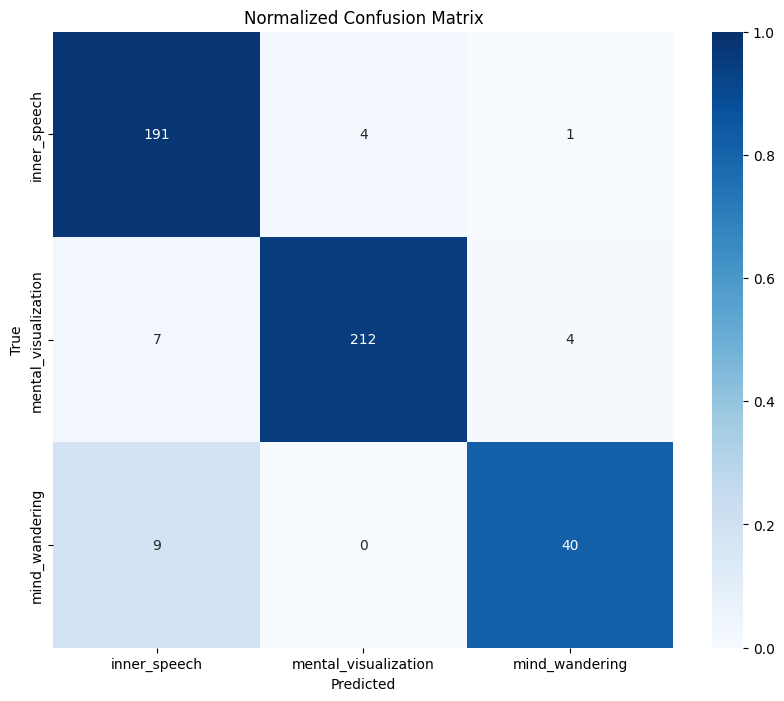

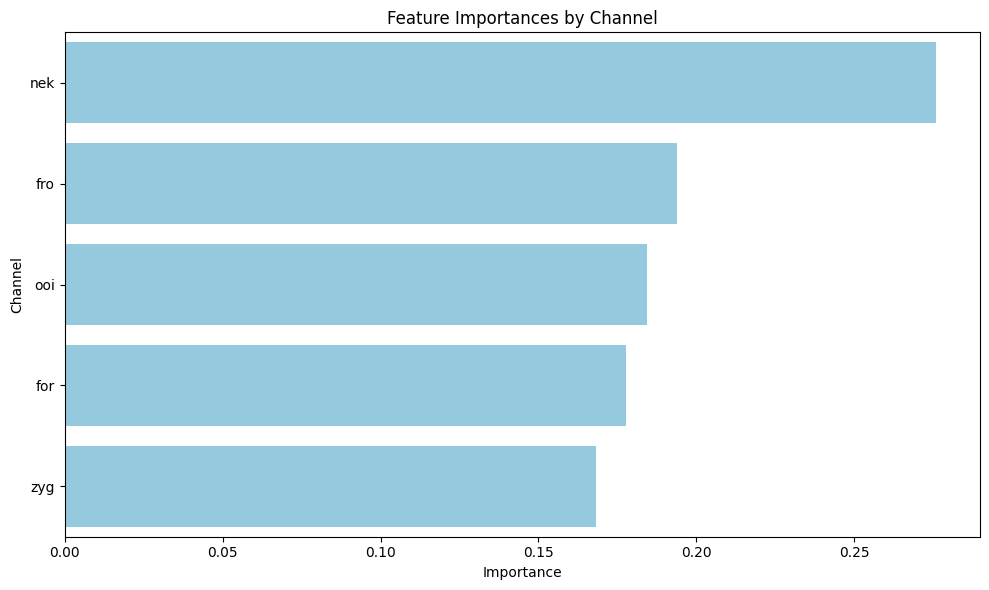

In [7]:
# rf by subject with a test set in % but only mental conditions

def train_and_evaluate(df, channels, features, conditions, seed=42):
    """
    Trains and evaluates a RandomForestClassifier for each subject using specified channels and features.
    
    Parameters:
    df (pd.DataFrame): The input dataframe in wide format.
    channels (list): List of channels to include in the features.
    features (list): List of feature names to include.
    conditions (list): List of conditions to include in the model.
    seed (int): Random seed for reproducibility.
    """
    np.random.seed(seed)
    
    # Filter dataframe for specified conditions
    df = df[df['condition'].isin(conditions)]
    
    # Dictionary to store models for each subject
    subject_models = {}

    # Lists to store all true labels and predictions across subjects
    all_y_test = []
    all_y_pred = []
    feature_importances = []

    # Hyperparameter grid
    param_grid = {
        'n_estimators': [25, 50, 60, 75, 100, 200],
        'max_depth': [5, 10, 15, 20, 25],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }

    # Iterate over each subject
    for subject in df['subject'].unique():
        # Filter data for the current subject
        subject_data = df[df['subject'] == subject]

        # Create a list of columns to include based on specified features and channels
        selected_columns = [f"{feature}_{channel}" for feature in features for channel in channels]

        # Separate features (X) and labels (y)
        X = subject_data[selected_columns]
        y = subject_data['condition']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed, stratify=y
        )

        # Initialize the RandomForestClassifier
        rf = RandomForestClassifier(random_state=seed)

        # Perform grid search with cross-validation
        grid_search = GridSearchCV(
            estimator=rf,
            param_grid=param_grid,
            cv=2,
            n_jobs=-1,
            scoring='f1_weighted'
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Predict the labels for the test set
        y_pred = best_model.predict(X_test)

        # Append the true labels and predictions to the lists
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        # Append feature importances
        feature_importances.append(best_model.feature_importances_)

        # Print the classification report for the current subject
        print(f"Subject {subject} classification report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Store the trained model in the dictionary
        subject_models[subject] = best_model

    # Print the global classification report
    print("Global classification report:")
    print(classification_report(all_y_test, all_y_pred, zero_division=0))
    print(f"Global balanced accuracy: {balanced_accuracy_score(all_y_test, all_y_pred):.2f}")
    print(f"Global F1-score: {f1_score(all_y_test, all_y_pred, average='weighted'):.2f}")

    # Bootstrapping to estimate 95% confidence interval for test balanced accuracy
    n_iterations = 1000
    bootstrap_accuracies = []

    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(all_y_test)), size=len(all_y_test), replace=True)
        y_test_bootstrap = np.array(all_y_test)[bootstrap_indices]
        y_pred_bootstrap = np.array(all_y_pred)[bootstrap_indices]
        bootstrap_accuracy = balanced_accuracy_score(y_test_bootstrap, y_pred_bootstrap)
        bootstrap_accuracies.append(bootstrap_accuracy)

    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for Test Balanced Accuracy: [{lower_bound:.2f}, {upper_bound:.2f}]")

    # Compute the confusion matrix
    condition_labels = sorted(df['condition'].unique())
    cm = confusion_matrix(all_y_test, all_y_pred, labels=condition_labels)
    
    # Normalize the confusion matrix per row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with zeros

    # Calculate the proportion of correctly predicted data points for each condition
    for i, label in enumerate(condition_labels):
        proportion_correct = cm_normalized[i, i]
        print(f"Proportion of data points correctly predicted for condition '{label}': {proportion_correct:.2f}")
    
    # Plot the normalized confusion matrix with counts as annotations
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=cm,
        fmt='d',
        cmap='Blues',
        xticklabels=condition_labels,
        yticklabels=condition_labels,
        vmin=0,
        vmax=1
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Compute mean feature importance across subjects
    mean_feature_importances = np.mean(feature_importances, axis=0)
    feature_importance_df = pd.DataFrame({'feature': selected_columns, 'importance': mean_feature_importances})

    # Extract channels from feature names
    feature_importance_df['channel'] = feature_importance_df['feature'].apply(lambda x: x.split('_')[-1])

    # Sum importances by channel
    channel_importance_df = feature_importance_df.groupby('channel')['importance'].sum().reset_index()

    # Sort channels by importance
    channel_importance_df = channel_importance_df.sort_values(by='importance', ascending=False)

    # Plot the channel importances
    plt.figure(figsize=(10, 6))
    sns.barplot(data=channel_importance_df, x='importance', y='channel', color='skyblue')
    plt.title('Feature Importances by Channel')
    plt.xlabel('Importance')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()

channels = ['for', 'fro', 'nek', 'ooi', 'zyg']
features = ['z_score', 'iqr', 'mad', 'median', 'std']
conditions = ['mind_wandering', 'inner_speech', 'mental_visualization']
train_and_evaluate(df_wide_filtered, channels, features, conditions)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1025
[LightGBM] [Info] Number of data points in the train set: 40, number of used features: 25
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

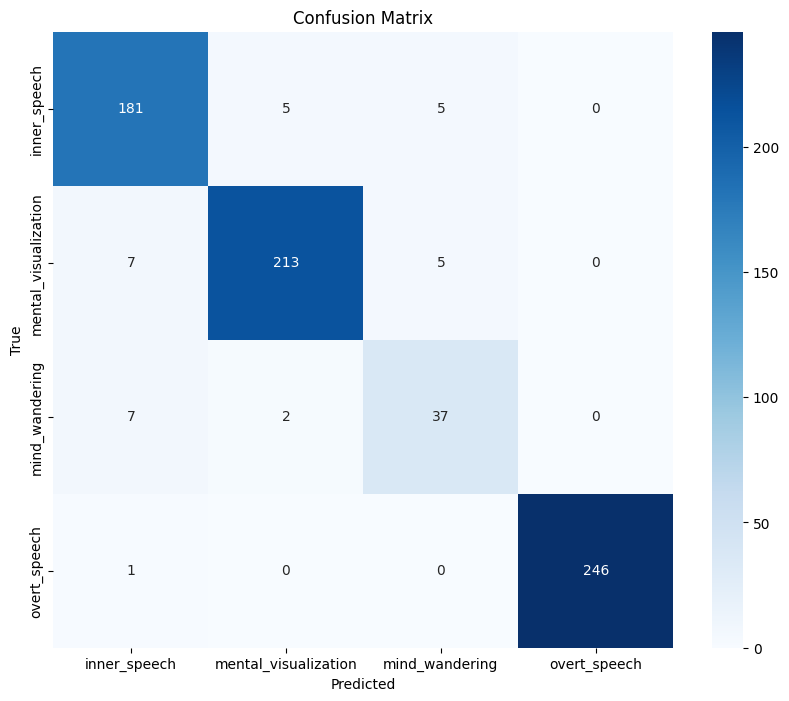

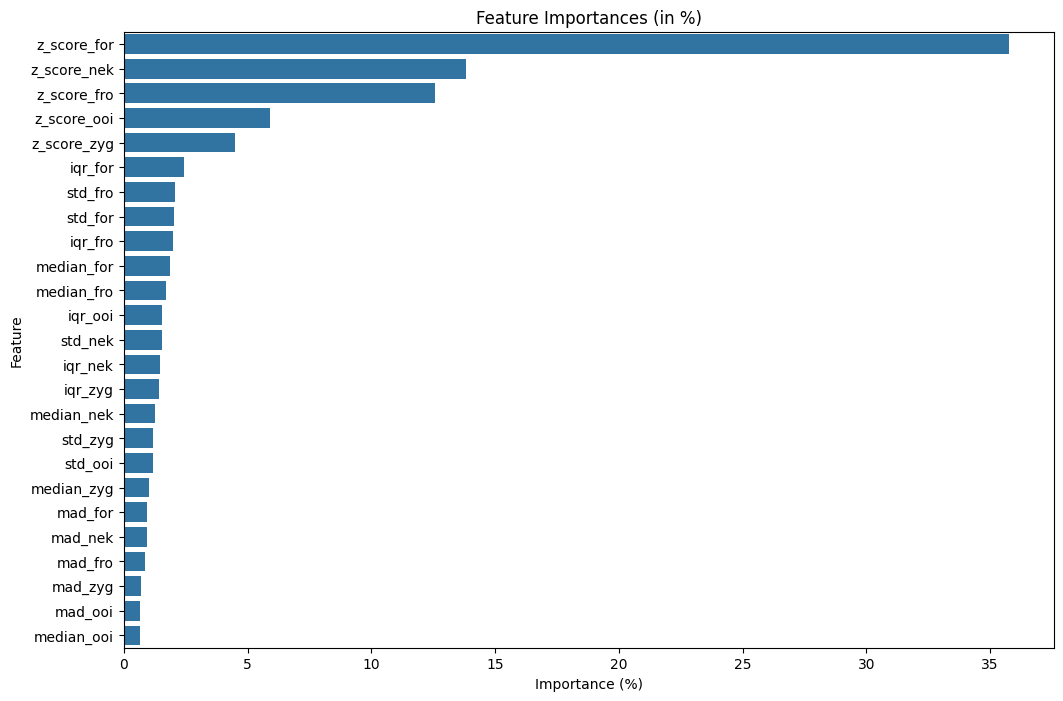

In [ ]:
# lgbm par sujet

def train_and_evaluate(df, channels, features, conditions, seed=42):
    """
    Trains and evaluates an LGBMClassifier using specified channels and features.
    
    Parameters:
    df (pd.DataFrame): The input dataframe in wide format.
    channels (list): List of channels to include in the features.
    features (list): List of feature names to include.
    conditions (list): List of conditions to include in the model.
    seed (int): Random seed for reproducibility.
    """
    np.random.seed(seed)
    
    # Filter dataframe for specified conditions
    df = df[df['condition'].isin(conditions)]
    
    # Dictionary to store models for each subject
    subject_models = {}

    # Lists to store all true labels and predictions across subjects
    all_y_test = []
    all_y_pred = []
    feature_importances = []

    # Iterate over each subject
    for subject in df['subject'].unique():
        # Filter data for the current subject
        subject_data = df[df['subject'] == subject]

        # Create a list of columns to include based on specified features and channels
        selected_columns = [f"{feature}_{channel}" for feature in features for channel in channels]

        # Separate features (X) and labels (y)
        X = subject_data[selected_columns]
        y = subject_data['condition']

        # # Ensure there are no constant features
        # X = X.loc[:, (X != X.iloc[0]).any()]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

        # Initialize and train the LGBMClassifier with balanced class weights
        model = lgb.LGBMClassifier(random_state=seed, class_weight='balanced', min_data_in_leaf=1, min_data_in_bin=1)
        model.fit(X_train, y_train)

        # Predict the labels for the test set
        y_pred = model.predict(X_test)

        # Append the true labels and predictions to the lists
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        # Append feature importances
        feature_importances.append(model.feature_importances_)

        # Print the classification report for the current subject
        print(f"Subject {subject} classification report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        # Store the trained model in the dictionary
        subject_models[subject] = model

    # Print the global classification report
    print("Global classification report:")
    print(classification_report(all_y_test, all_y_pred, zero_division=0))
    print(f"Global balanced accuracy: {balanced_accuracy_score(all_y_test, all_y_pred)}")
    print(f"Global F1-score: {f1_score(all_y_test, all_y_pred, average='weighted')}")

    # Bootstrapping to estimate 95% confidence interval for test balanced accuracy
    n_iterations = 1000
    bootstrap_accuracies = []

    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(all_y_test)), size=len(all_y_test), replace=True)
        y_test_bootstrap = np.array(all_y_test)[bootstrap_indices]
        y_pred_bootstrap = np.array(all_y_pred)[bootstrap_indices]
        bootstrap_accuracy = balanced_accuracy_score(y_test_bootstrap, y_pred_bootstrap)
        bootstrap_accuracies.append(bootstrap_accuracy)

    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for Test Balanced Accuracy: [{lower_bound:.2f}, {upper_bound:.2f}]")

    # Compute the confusion matrix
    cm = confusion_matrix(all_y_test, all_y_pred)

    # Get unique condition labels in sorted order for consistent mapping
    condition_labels = sorted(df['condition'].unique())

    # Calculate the proportion of correctly predicted data points for each condition
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i, label in enumerate(condition_labels):
        print(f"Proportion of data points correctly predicted for condition '{label}': {cm_normalized[i, i]:.2f}")

    # Plot the confusion matrix with labels
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=condition_labels, yticklabels=condition_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute mean feature importance across subjects
    mean_feature_importances = np.mean(feature_importances, axis=0)
    mean_feature_importances_percentage = 100 * mean_feature_importances / np.sum(mean_feature_importances)
    feature_importance_df = pd.DataFrame({'feature': selected_columns, 'importance': mean_feature_importances_percentage})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df, x='importance', y='feature')
    plt.title('Feature Importances (in %)')
    plt.xlabel('Importance (%)')
    plt.ylabel('Feature')
    plt.show()

channels = ['for', 'fro', 'nek', 'ooi', 'zyg']
features = ['z_score', 'iqr', 'mad', 'median', 'std']
conditions = ['mind_wandering', 'inner_speech', 'mental_visualization', 'overt_speech']
train_and_evaluate(df_wide_filtered, channels, features, conditions)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 2786, number of used features: 25
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

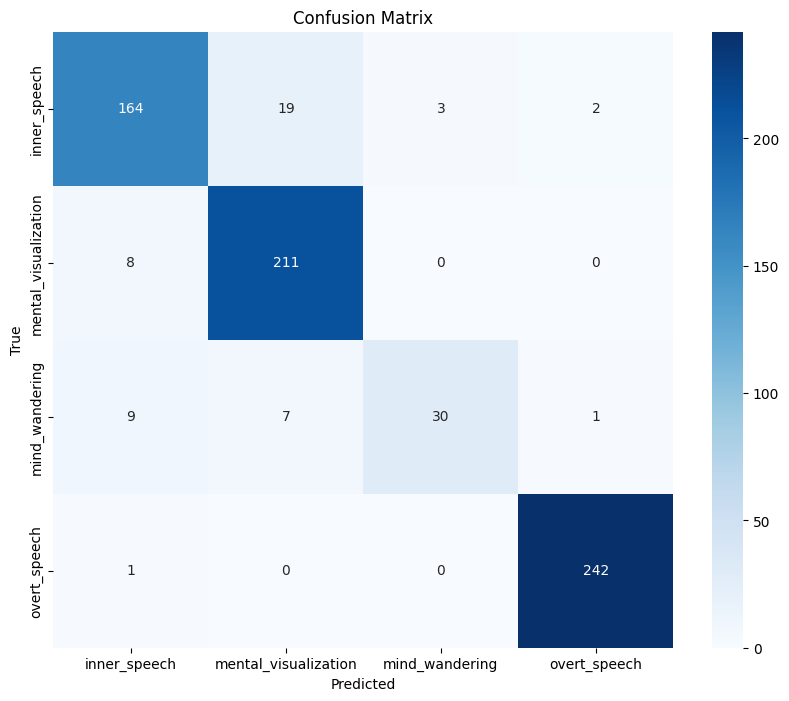

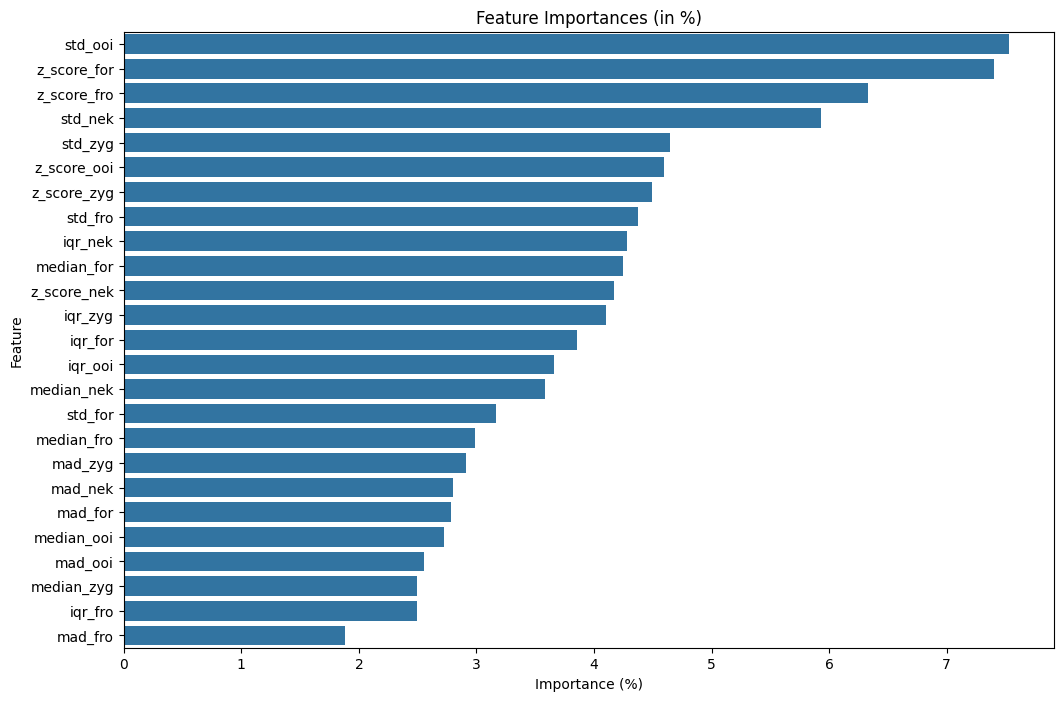

In [11]:
# single lgbm
def train_and_evaluate(df, channels, features, conditions, seed=42):
    """
    Trains and evaluates an LGBMClassifier using specified channels and features.
    
    Parameters:
    df (pd.DataFrame): The input dataframe in wide format.
    channels (list): List of channels to include in the features.
    features (list): List of feature names to include.
    conditions (list): List of conditions to include in the model.
    seed (int): Random seed for reproducibility.
    """
    np.random.seed(seed)
    
    # Filter dataframe for specified conditions
    df = df[df['condition'].isin(conditions)]
    
    # Create a list of columns to include based on specified features and channels
    selected_columns = [f"{feature}_{channel}" for feature in features for channel in channels]

    # Separate features (X) and labels (y)
    X = df[selected_columns]
    y = df['condition']

    # Ensure there are no constant features
    X = X.loc[:, (X != X.iloc[0]).any()]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

    # Hyperparameter grid
    param_grid = {
        'num_leaves': [31, 50],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [50,100],
        'max_depth': [-1, 10, 20]
    }

    # Initialize the LGBMClassifier
    lgbm = lgb.LGBMClassifier(random_state=seed, class_weight='balanced', min_data_in_leaf=1, min_data_in_bin=1)

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=2, n_jobs=-1, scoring='f1_weighted')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predict the labels for the test set
    y_pred = best_model.predict(X_test)

    # Print the classification report
    print("Classification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Print the global metrics
    print(f"Global balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")
    print(f"Global F1-score: {f1_score(y_test, y_pred, average='weighted')}")

    # Bootstrapping to estimate 95% confidence interval for test balanced accuracy
    n_iterations = 1000
    bootstrap_accuracies = []

    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(y_test)), size=len(y_test), replace=True)
        y_test_bootstrap = np.array(y_test)[bootstrap_indices]
        y_pred_bootstrap = np.array(y_pred)[bootstrap_indices]
        bootstrap_accuracy = balanced_accuracy_score(y_test_bootstrap, y_pred_bootstrap)
        bootstrap_accuracies.append(bootstrap_accuracy)

    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for Test Balanced Accuracy: [{lower_bound:.2f}, {upper_bound:.2f}]")

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Get unique condition labels in sorted order for consistent mapping
    condition_labels = sorted(df['condition'].unique())

    # Calculate the proportion of correctly predicted data points for each condition
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i, label in enumerate(condition_labels):
        print(f"Proportion of data points correctly predicted for condition '{label}': {cm_normalized[i, i]:.2f}")

    # Plot the confusion matrix with labels
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=condition_labels, yticklabels=condition_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute feature importances
    feature_importances = best_model.feature_importances_
    mean_feature_importances_percentage = 100 * feature_importances / np.sum(feature_importances)
    feature_importance_df = pd.DataFrame({'feature': selected_columns, 'importance': mean_feature_importances_percentage})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df, x='importance', y='feature')
    plt.title('Feature Importances (in %)')
    plt.xlabel('Importance (%)')
    plt.ylabel('Feature')
    plt.show()

channels = ['for', 'fro', 'nek', 'ooi', 'zyg']
features = ['z_score', 'iqr', 'mad', 'median', 'std']
conditions = ['mind_wandering', 'inner_speech', 'mental_visualization', 'overt_speech']
train_and_evaluate(df_wide_filtered, channels, features, conditions)

Classification report:
                      precision    recall  f1-score   support

        inner_speech       0.94      0.93      0.93       186
mental_visualization       0.91      0.98      0.94       221
      mind_wandering       1.00      0.57      0.72        44
        overt_speech       0.99      1.00      0.99       246

            accuracy                           0.95       697
           macro avg       0.96      0.87      0.90       697
        weighted avg       0.95      0.95      0.94       697

Balanced accuracy: 0.87
F1-score: 0.94
95% Confidence Interval for Test Balanced Accuracy: [0.83, 0.91]
Proportion of data points correctly predicted for condition 'inner_speech': 0.93
Proportion of data points correctly predicted for condition 'mental_visualization': 0.98
Proportion of data points correctly predicted for condition 'mind_wandering': 0.57
Proportion of data points correctly predicted for condition 'overt_speech': 1.00


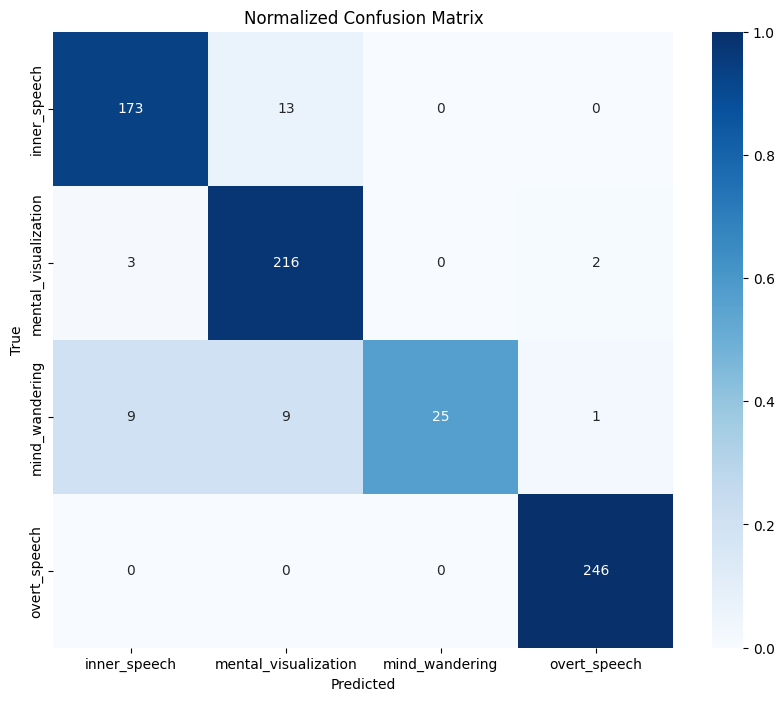

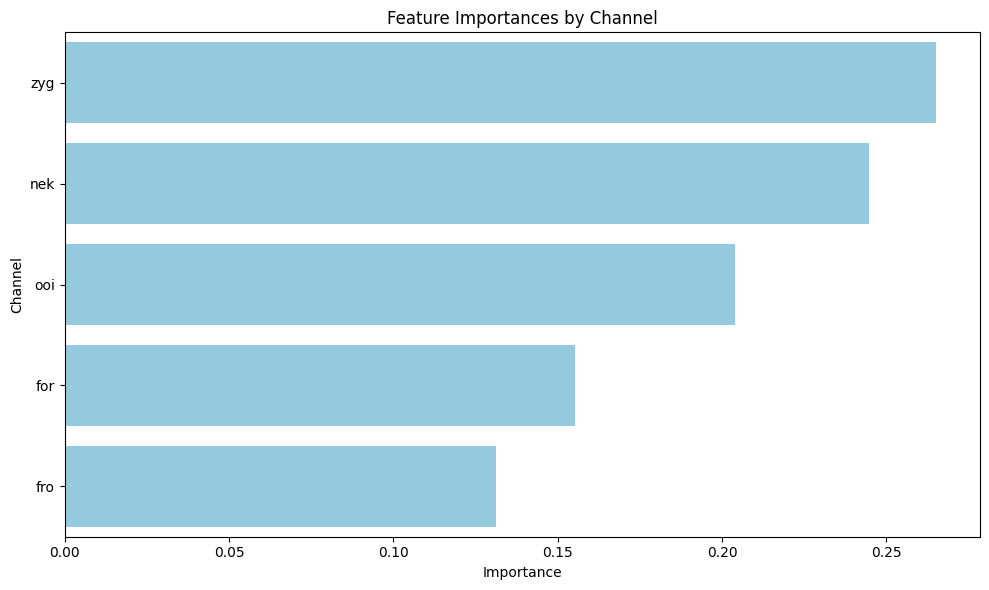


Aggregated Feature Importances by Channel:
channel  importance
    zyg    0.265210
    nek    0.244553
    ooi    0.203912
    for    0.155131
    fro    0.131195


In [12]:
# single RF
def train_and_evaluate(df, channels, features, conditions, seed=42):
    """
    Trains and evaluates a RandomForestClassifier using specified channels and features.

    Parameters:
    df (pd.DataFrame): The input dataframe in wide format.
    channels (list): List of channels to include in the features.
    features (list): List of feature names to include.
    conditions (list): List of conditions to include in the model.
    seed (int): Random seed for reproducibility.
    """
    np.random.seed(seed)
    
    # Filter dataframe for specified conditions
    df = df[df['condition'].isin(conditions)]
    
    # Create a list of columns to include based on specified features and channels
    selected_columns = [f"{feature}_{channel}" for feature in features for channel in channels]
    
    # Separate features (X) and labels (y)
    X = df[selected_columns]
    y = df['condition']
    
    # Create a stratify variable that combines subject and condition
    df['subject_condition'] = df['subject'].astype(str) + '_' + df['condition'].astype(str)
    stratify_var = df['subject_condition']
    
    # Check that each subject_condition group has at least 2 samples
    group_counts = stratify_var.value_counts()
    insufficient_groups = group_counts[group_counts < 2]
    if len(insufficient_groups) > 0:
        print("The following subject_condition groups have less than 2 samples and cannot be stratified:")
        print(insufficient_groups)
        # Remove these groups from the dataset
        df = df[~df['subject_condition'].isin(insufficient_groups.index)]
        X = X.loc[df.index]
        y = y.loc[df.index]
        stratify_var = stratify_var.loc[df.index]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=stratify_var
    )
    
    # Hyperparameter grid
    param_grid = {
        'n_estimators': [25, 50, 60, 75, 100, 200],
        'max_depth': [5, 10, 15, 20, 25],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }
    
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(random_state=seed)
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=2,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # Predict the labels for the test set
    y_pred = best_model.predict(X_test)
    
    # Print the classification report
    print("Classification report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred):.2f}")
    print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
    
    # Bootstrapping to estimate 95% confidence interval for test balanced accuracy
    n_iterations = 1000
    bootstrap_accuracies = []
    
    y_test_array = np.array(y_test)
    y_pred_array = np.array(y_pred)
    
    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(y_test_array)), size=len(y_test_array), replace=True)
        y_test_bootstrap = y_test_array[bootstrap_indices]
        y_pred_bootstrap = y_pred_array[bootstrap_indices]
        bootstrap_accuracy = balanced_accuracy_score(y_test_bootstrap, y_pred_bootstrap)
        bootstrap_accuracies.append(bootstrap_accuracy)
    
    lower_bound = np.percentile(bootstrap_accuracies, 2.5)
    upper_bound = np.percentile(bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for Test Balanced Accuracy: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    # Compute the confusion matrix
    condition_labels = sorted(df['condition'].unique())
    cm = confusion_matrix(y_test, y_pred, labels=condition_labels)
    
    # Normalize the confusion matrix per row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with zeros
    
    # Calculate the proportion of correctly predicted data points for each condition
    for i, label in enumerate(condition_labels):
        proportion_correct = cm_normalized[i, i]
        print(f"Proportion of data points correctly predicted for condition '{label}': {proportion_correct:.2f}")
    
    # Plot the normalized confusion matrix with counts as annotations
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=cm,
        fmt='d',
        cmap='Blues',
        xticklabels=condition_labels,
        yticklabels=condition_labels,
        vmin=0,
        vmax=1
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    # Compute feature importances
    feature_importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': selected_columns, 'importance': feature_importances})
    
    # Extract channels from feature names
    feature_importance_df['channel'] = feature_importance_df['feature'].apply(lambda x: x.split('_')[-1])
    
    # Sum importances by channel
    channel_importance_df = feature_importance_df.groupby('channel')['importance'].sum().reset_index()
    
    # Sort channels by importance
    channel_importance_df = channel_importance_df.sort_values(by='importance', ascending=False)
    
    # Plot the channel importances
    plt.figure(figsize=(10, 6))
    sns.barplot(data=channel_importance_df, x='importance', y='channel', color='skyblue')
    plt.title('Feature Importances by Channel')
    plt.xlabel('Importance')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()
    
    # Print the feature importances aggregated by channel
    print("\nAggregated Feature Importances by Channel:")
    print(channel_importance_df.to_string(index=False))

# Example usage:
channels = ['for', 'fro', 'nek', 'ooi', 'zyg']
features = ['z_score', 'iqr', 'mad', 'median', 'std']
conditions = ['mind_wandering', 'inner_speech', 'mental_visualization', 'overt_speech']
train_and_evaluate(df_wide_filtered, channels, features, conditions)


RandomForest Balanced Accuracy: 0.53
DummyClassifier Balanced Accuracy: 0.25
95% Confidence Interval for RandomForest Test Balanced Accuracy: [0.49, 0.57]
95% Confidence Interval for DummyClassifier Test Balanced Accuracy: [0.22, 0.28]
Your model performs better than the DummyClassifier.
P-value comparing RandomForest to DummyClassifier: 0.0000
The model's performance is statistically significant compared to the DummyClassifier (p < 0.05).
Proportion of data points correctly predicted for condition 'inner_speech': 0.36
Proportion of data points correctly predicted for condition 'mental_visualization': 0.50
Proportion of data points correctly predicted for condition 'mind_wandering': 0.26
Proportion of data points correctly predicted for condition 'overt_speech': 1.00


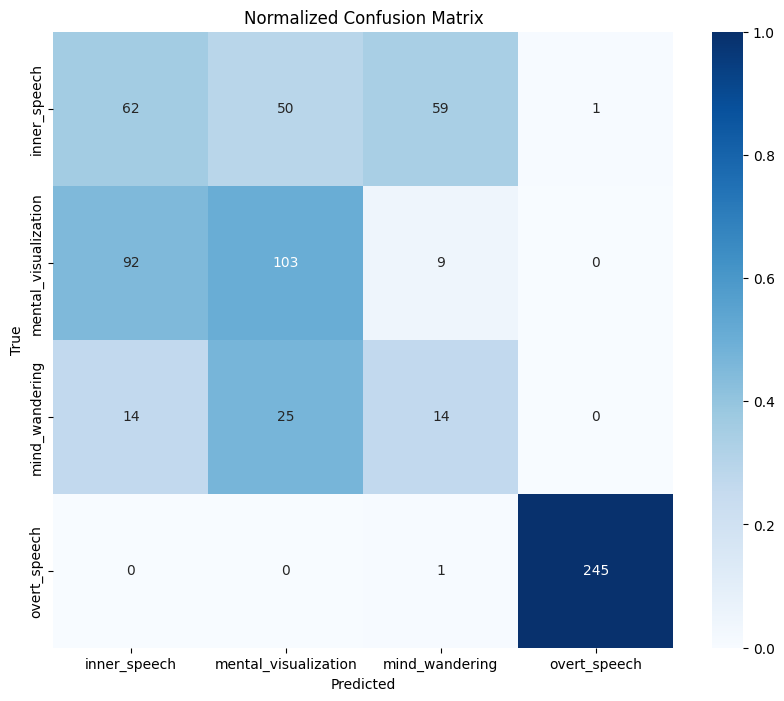

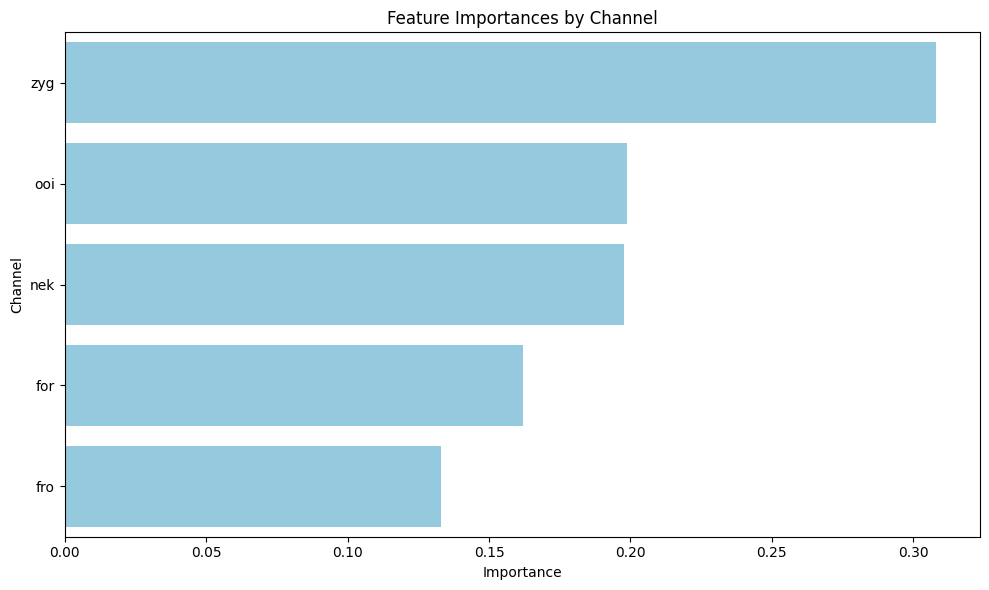

In [13]:
# Control
# Unseen subjects for test
# Dummy model
# Model is better than dummy (because overt speech is easily classified) but not better than dummy when only considering mental conditions

def train_and_evaluate(df, channels, features, conditions, test_size=0.2, seed=42, n_iterations=1000):
    """
    Trains and evaluates a RandomForestClassifier using specified channels and features.
    The test set is composed of unseen subjects, and the performance of the RandomForest
    is compared to a DummyClassifier. Also computes 95% confidence intervals for both classifiers.
    
    Parameters:
    df (pd.DataFrame): The input dataframe in wide format.
    channels (list): List of channels to include in the features.
    features (list): List of feature names to include.
    conditions (list): List of conditions to include in the model.
    test_size (float): Proportion of subjects to include in the test set.
    seed (int): Random seed for reproducibility.
    n_iterations (int): Number of bootstrap iterations for confidence interval estimation.
    """
    np.random.seed(seed)
    
    # Filter dataframe for specified conditions
    df = df[df['condition'].isin(conditions)]

    # Get the list of unique subjects
    all_subjects = df['subject'].unique()
    
    # Split the subjects into training and testing sets
    train_subjects, test_subjects = train_test_split(
        all_subjects, test_size=test_size, random_state=seed
    )
    
    # Filter the dataframe for training and testing subjects
    train_data = df[df['subject'].isin(train_subjects)]
    test_data = df[df['subject'].isin(test_subjects)]
    
    # Create a list of columns to include based on specified features and channels
    selected_columns = [f"{feature}_{channel}" for feature in features for channel in channels]

    # Separate features (X) and labels (y) for training and testing data
    X_train = train_data[selected_columns]
    y_train = train_data['condition']

    X_test = test_data[selected_columns]
    y_test = test_data['condition']
    
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(random_state=seed)

    # Hyperparameter grid
    param_grid = {
        'n_estimators': [25, 50, 60, 75, 100, 200],
        'max_depth': [5, 10, 15, 20, 25],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predict the labels for the test set with RandomForestClassifier
    y_pred_rf = best_model.predict(X_test)

    # Dummy Classifier
    dummy_clf = DummyClassifier(strategy='stratified', random_state=seed)
    dummy_clf.fit(X_train, y_train)
    y_pred_dummy = dummy_clf.predict(X_test)

    # Compute balanced accuracies
    model_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
    dummy_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_dummy)

    # Print the balanced accuracies
    print(f"RandomForest Balanced Accuracy: {model_balanced_accuracy:.2f}")
    print(f"DummyClassifier Balanced Accuracy: {dummy_balanced_accuracy:.2f}")

    # Bootstrapping for 95% confidence interval for RandomForest
    rf_bootstrap_accuracies = []
    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(y_test)), size=len(y_test), replace=True)
        y_test_bootstrap = np.array(y_test)[bootstrap_indices]
        y_pred_rf_bootstrap = np.array(y_pred_rf)[bootstrap_indices]
        bootstrap_accuracy = balanced_accuracy_score(y_test_bootstrap, y_pred_rf_bootstrap)
        rf_bootstrap_accuracies.append(bootstrap_accuracy)

    lower_bound_rf = np.percentile(rf_bootstrap_accuracies, 2.5)
    upper_bound_rf = np.percentile(rf_bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for RandomForest Test Balanced Accuracy: [{lower_bound_rf:.2f}, {upper_bound_rf:.2f}]")

    # Bootstrapping for 95% confidence interval for DummyClassifier
    dummy_bootstrap_accuracies = []
    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(y_test)), size=len(y_test), replace=True)
        y_test_bootstrap = np.array(y_test)[bootstrap_indices]
        y_pred_dummy_bootstrap = np.array(y_pred_dummy)[bootstrap_indices]
        bootstrap_accuracy_dummy = balanced_accuracy_score(y_test_bootstrap, y_pred_dummy_bootstrap)
        dummy_bootstrap_accuracies.append(bootstrap_accuracy_dummy)

    lower_bound_dummy = np.percentile(dummy_bootstrap_accuracies, 2.5)
    upper_bound_dummy = np.percentile(dummy_bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for DummyClassifier Test Balanced Accuracy: [{lower_bound_dummy:.2f}, {upper_bound_dummy:.2f}]")

    # Check if the RandomForest performs better than the DummyClassifier
    if model_balanced_accuracy > dummy_balanced_accuracy:
        print("Your model performs better than the DummyClassifier.")
    else:
        print("Your model does not perform better than the DummyClassifier.")

    # Permutation testing to compare RandomForest with DummyClassifier
    n_permutations = 1000
    permutation_diffs = []
    observed_diff = model_balanced_accuracy - dummy_balanced_accuracy

    # Permuting the predictions between RandomForest and DummyClassifier
    for _ in range(n_permutations):
        perm_indices = np.random.permutation(len(y_test))
        y_pred_rf_permuted = y_pred_rf[perm_indices]
        y_pred_dummy_permuted = y_pred_dummy[perm_indices]

        # Compute the difference in balanced accuracy for the permuted predictions
        perm_diff = balanced_accuracy_score(y_test, y_pred_rf_permuted) - balanced_accuracy_score(y_test, y_pred_dummy_permuted)
        permutation_diffs.append(perm_diff)

    # Convert permutation differences to numpy array
    permutation_diffs = np.array(permutation_diffs)

    # Calculate the p-value
    p_value = np.mean(permutation_diffs >= observed_diff)
    print(f"P-value comparing RandomForest to DummyClassifier: {p_value:.4f}")

    # Check if p-value is below significance level
    alpha = 0.05
    if p_value < alpha:
        print(f"The model's performance is statistically significant compared to the DummyClassifier (p < {alpha}).")
    else:
        print(f"The model's performance is not statistically significant compared to the DummyClassifier (p >= {alpha}).")

    # Compute the confusion matrix for RandomForest
    condition_labels = sorted(df['condition'].unique())
    cm = confusion_matrix(y_test, y_pred_rf, labels=condition_labels)
    
    # Normalize the confusion matrix per row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with zeros

    # Calculate the proportion of correctly predicted data points for each condition
    for i, label in enumerate(condition_labels):
        proportion_correct = cm_normalized[i, i]
        print(f"Proportion of data points correctly predicted for condition '{label}': {proportion_correct:.2f}")
    
    # Plot the normalized confusion matrix with counts as annotations
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=cm,
        fmt='d',
        cmap='Blues',
        xticklabels=condition_labels,
        yticklabels=condition_labels,
        vmin=0,
        vmax=1
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Compute feature importances
    feature_importances = best_model.feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'feature': selected_columns, 'importance': feature_importances})

    # Extract channels from feature names
    feature_importance_df['channel'] = feature_importance_df['feature'].apply(lambda x: x.split('_')[-1])

    # Sum importances by channel
    channel_importance_df = feature_importance_df.groupby('channel')['importance'].sum().reset_index()

    # Sort channels by importance
    channel_importance_df = channel_importance_df.sort_values(by='importance', ascending=False)

    # Plot the channel importances
    plt.figure(figsize=(10, 6))
    sns.barplot(data=channel_importance_df, x='importance', y='channel', color='skyblue')
    plt.title('Feature Importances by Channel')
    plt.xlabel('Importance')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()

# Example usage:
channels = ['for', 'fro', 'nek', 'ooi', 'zyg']
features = ['z_score', 'iqr', 'mad', 'median', 'std']
conditions = ['mind_wandering', 'inner_speech', 'mental_visualization', 'overt_speech']

train_and_evaluate(df_wide_filtered, channels, features, conditions)

RandomForest Balanced Accuracy: 0.47
DummyClassifier Balanced Accuracy: 0.34
95% Confidence Interval for RandomForest Test Balanced Accuracy: [0.42, 0.53]
95% Confidence Interval for DummyClassifier Test Balanced Accuracy: [0.30, 0.38]
Your model performs better than the DummyClassifier.
P-value comparing RandomForest to DummyClassifier: 0.0000
The model's performance is statistically significant compared to the DummyClassifier (p < 0.05).
Proportion of data points correctly predicted for condition 'inner_speech': 0.35
Proportion of data points correctly predicted for condition 'mental_visualization': 0.61
Proportion of data points correctly predicted for condition 'mind_wandering': 0.45


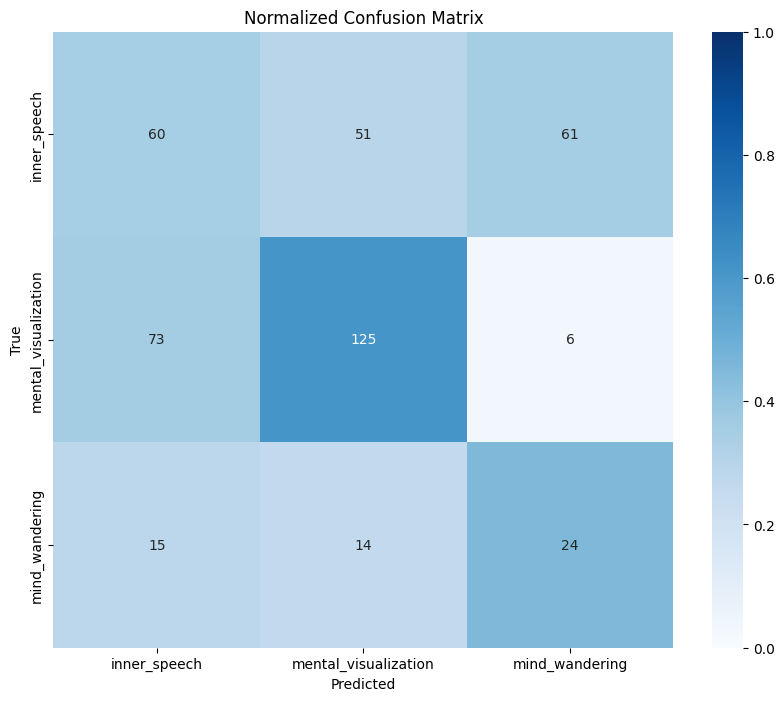

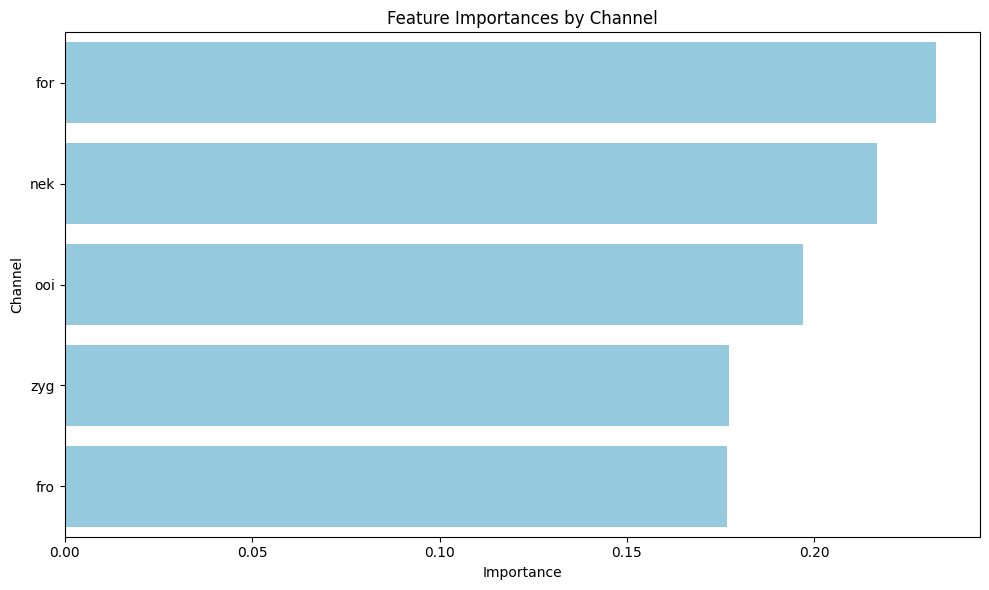

In [14]:
# Control (only mental)
# Unseen subjects for test
# Dummy model
# Model is better than dummy (because overt speech is easily classified) but not better than dummy when only considering mental conditions

def train_and_evaluate(df, channels, features, conditions, test_size=0.2, seed=42, n_iterations=1000):
    """
    Trains and evaluates a RandomForestClassifier using specified channels and features.
    The test set is composed of unseen subjects, and the performance of the RandomForest
    is compared to a DummyClassifier. Also computes 95% confidence intervals for both classifiers.
    
    Parameters:
    df (pd.DataFrame): The input dataframe in wide format.
    channels (list): List of channels to include in the features.
    features (list): List of feature names to include.
    conditions (list): List of conditions to include in the model.
    test_size (float): Proportion of subjects to include in the test set.
    seed (int): Random seed for reproducibility.
    n_iterations (int): Number of bootstrap iterations for confidence interval estimation.
    """
    np.random.seed(seed)
    
    # Filter dataframe for specified conditions
    df = df[df['condition'].isin(conditions)]

    # Get the list of unique subjects
    all_subjects = df['subject'].unique()
    
    # Split the subjects into training and testing sets
    train_subjects, test_subjects = train_test_split(
        all_subjects, test_size=test_size, random_state=seed
    )
    
    # Filter the dataframe for training and testing subjects
    train_data = df[df['subject'].isin(train_subjects)]
    test_data = df[df['subject'].isin(test_subjects)]
    
    # Create a list of columns to include based on specified features and channels
    selected_columns = [f"{feature}_{channel}" for feature in features for channel in channels]

    # Separate features (X) and labels (y) for training and testing data
    X_train = train_data[selected_columns]
    y_train = train_data['condition']

    X_test = test_data[selected_columns]
    y_test = test_data['condition']
    
    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier(random_state=seed)

    # Hyperparameter grid
    param_grid = {
        'n_estimators': [25, 50, 60, 75, 100, 200],
        'max_depth': [5, 10, 15, 20, 25],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        scoring='f1_weighted'
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predict the labels for the test set with RandomForestClassifier
    y_pred_rf = best_model.predict(X_test)

    # Dummy Classifier
    dummy_clf = DummyClassifier(strategy='stratified', random_state=seed)
    dummy_clf.fit(X_train, y_train)
    y_pred_dummy = dummy_clf.predict(X_test)

    # Compute balanced accuracies
    model_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rf)
    dummy_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_dummy)

    # Print the balanced accuracies
    print(f"RandomForest Balanced Accuracy: {model_balanced_accuracy:.2f}")
    print(f"DummyClassifier Balanced Accuracy: {dummy_balanced_accuracy:.2f}")

    # Bootstrapping for 95% confidence interval for RandomForest
    rf_bootstrap_accuracies = []
    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(y_test)), size=len(y_test), replace=True)
        y_test_bootstrap = np.array(y_test)[bootstrap_indices]
        y_pred_rf_bootstrap = np.array(y_pred_rf)[bootstrap_indices]
        bootstrap_accuracy = balanced_accuracy_score(y_test_bootstrap, y_pred_rf_bootstrap)
        rf_bootstrap_accuracies.append(bootstrap_accuracy)

    lower_bound_rf = np.percentile(rf_bootstrap_accuracies, 2.5)
    upper_bound_rf = np.percentile(rf_bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for RandomForest Test Balanced Accuracy: [{lower_bound_rf:.2f}, {upper_bound_rf:.2f}]")

    # Bootstrapping for 95% confidence interval for DummyClassifier
    dummy_bootstrap_accuracies = []
    for _ in range(n_iterations):
        bootstrap_indices = np.random.choice(range(len(y_test)), size=len(y_test), replace=True)
        y_test_bootstrap = np.array(y_test)[bootstrap_indices]
        y_pred_dummy_bootstrap = np.array(y_pred_dummy)[bootstrap_indices]
        bootstrap_accuracy_dummy = balanced_accuracy_score(y_test_bootstrap, y_pred_dummy_bootstrap)
        dummy_bootstrap_accuracies.append(bootstrap_accuracy_dummy)

    lower_bound_dummy = np.percentile(dummy_bootstrap_accuracies, 2.5)
    upper_bound_dummy = np.percentile(dummy_bootstrap_accuracies, 97.5)
    print(f"95% Confidence Interval for DummyClassifier Test Balanced Accuracy: [{lower_bound_dummy:.2f}, {upper_bound_dummy:.2f}]")

    # Check if the RandomForest performs better than the DummyClassifier
    if model_balanced_accuracy > dummy_balanced_accuracy:
        print("Your model performs better than the DummyClassifier.")
    else:
        print("Your model does not perform better than the DummyClassifier.")

    # Permutation testing to compare RandomForest with DummyClassifier
    n_permutations = 1000
    permutation_diffs = []
    observed_diff = model_balanced_accuracy - dummy_balanced_accuracy

    # Permuting the predictions between RandomForest and DummyClassifier
    for _ in range(n_permutations):
        perm_indices = np.random.permutation(len(y_test))
        y_pred_rf_permuted = y_pred_rf[perm_indices]
        y_pred_dummy_permuted = y_pred_dummy[perm_indices]

        # Compute the difference in balanced accuracy for the permuted predictions
        perm_diff = balanced_accuracy_score(y_test, y_pred_rf_permuted) - balanced_accuracy_score(y_test, y_pred_dummy_permuted)
        permutation_diffs.append(perm_diff)

    # Convert permutation differences to numpy array
    permutation_diffs = np.array(permutation_diffs)

    # Calculate the p-value
    p_value = np.mean(permutation_diffs >= observed_diff)
    print(f"P-value comparing RandomForest to DummyClassifier: {p_value:.4f}")

    # Check if p-value is below significance level
    alpha = 0.05
    if p_value < alpha:
        print(f"The model's performance is statistically significant compared to the DummyClassifier (p < {alpha}).")
    else:
        print(f"The model's performance is not statistically significant compared to the DummyClassifier (p >= {alpha}).")

    # Compute the confusion matrix for RandomForest
    condition_labels = sorted(df['condition'].unique())
    cm = confusion_matrix(y_test, y_pred_rf, labels=condition_labels)
    
    # Normalize the confusion matrix per row
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with zeros

    # Calculate the proportion of correctly predicted data points for each condition
    for i, label in enumerate(condition_labels):
        proportion_correct = cm_normalized[i, i]
        print(f"Proportion of data points correctly predicted for condition '{label}': {proportion_correct:.2f}")
    
    # Plot the normalized confusion matrix with counts as annotations
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_normalized,
        annot=cm,
        fmt='d',
        cmap='Blues',
        xticklabels=condition_labels,
        yticklabels=condition_labels,
        vmin=0,
        vmax=1
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Compute feature importances
    feature_importances = best_model.feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'feature': selected_columns, 'importance': feature_importances})

    # Extract channels from feature names
    feature_importance_df['channel'] = feature_importance_df['feature'].apply(lambda x: x.split('_')[-1])

    # Sum importances by channel
    channel_importance_df = feature_importance_df.groupby('channel')['importance'].sum().reset_index()

    # Sort channels by importance
    channel_importance_df = channel_importance_df.sort_values(by='importance', ascending=False)

    # Plot the channel importances
    plt.figure(figsize=(10, 6))
    sns.barplot(data=channel_importance_df, x='importance', y='channel', color='skyblue')
    plt.title('Feature Importances by Channel')
    plt.xlabel('Importance')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()

# Example usage:
channels = ['for', 'fro', 'nek', 'ooi', 'zyg']
features = ['z_score', 'iqr', 'mad', 'median', 'std']
conditions = ['mind_wandering', 'inner_speech', 'mental_visualization']

train_and_evaluate(df_wide_filtered, channels, features, conditions)

In [15]:
# # PCA + Kmeans + Distance
# def plot_pca_and_analyze_distances(df, conditions, channels, feature_columns, min_trials, width=1200, height=800):
#     # Define color and shape mapping
#     color_mapping = {
#         'inner_speech': 'blue',
#         'mental_visualization': 'red',
#         'mind_wandering': 'green'
#     }
#     shape_mapping = {
#         'inner_speech': 'circle',
#         'mental_visualization': 'square',
#         'mind_wandering': 'triangle-up'
#     }
    
#     subjects = df['subject'].unique()
#     overall_accuracy = []
#     overall_balanced_accuracy = []
#     overall_f1_score = []
#     overall_condition_proportions = {condition: [] for condition in conditions}
    
#     # Initialize overall distance collections
#     overall_within_condition_distances = {condition: [] for condition in conditions}
#     overall_all_within_distances = []
#     overall_between_condition_distances = {}  # Key: condition_pair, Value: list of distances

#     # Initialize list to collect cumulative variance explained
#     cumulative_variance_list = []

#     for subject in subjects:
#         df_subject = df[df['subject'] == subject].copy()
#         df_filtered = df_subject[df_subject['condition'].isin(conditions)].copy()

#         condition_counts = df_filtered['condition'].value_counts()
#         insufficient_conditions = [condition for condition in conditions if condition_counts.get(condition, 0) < min_trials]
#         if insufficient_conditions:
#             df_filtered = df_filtered[~df_filtered['condition'].isin(insufficient_conditions)]
#             print(f"Removing conditions {insufficient_conditions} for subject {subject} due to insufficient trials")

#         if df_filtered.empty or df_filtered['condition'].nunique() < 2:
#             print(f"Skipping subject {subject} due to insufficient data after filtering")
#             continue

#         selected_features = [f"{feature}_{channel}" for feature in feature_columns for channel in channels]
#         features = df_filtered[selected_features].dropna()

#         if features.empty or features.shape[0] < 2:
#             print(f"Skipping subject {subject} due to insufficient feature data")
#             continue

#         # Reset index here to ensure alignment with best_pca_result
#         df_filtered = df_filtered.reset_index(drop=True)

#         # Standardize features before PCA
#         scaler = StandardScaler()
#         features_scaled = scaler.fit_transform(features)

#         best_accuracy = 0
#         best_balanced_accuracy = 0
#         best_f1_score = 0
#         best_setup = None
#         best_clusters = None
#         best_cluster_labels = None
#         best_centroids = None
#         best_pca = None
#         best_pca_result = None
#         subject_condition_proportions = {}

#         valid_conditions = [condition for condition in conditions if condition not in insufficient_conditions]

#         # Calculate the maximum number of components allowed
#         max_components = min(features_scaled.shape[0], features_scaled.shape[1], 20)

#         # Apply PCA to reduce dimensionality
#         for n_components in range(2, max_components + 1):
#             pca = PCA(n_components=n_components, random_state=42)
#             pca_result = pca.fit_transform(features_scaled)

#             # Perform K-Means clustering on PCA-transformed data
#             for n_clusters in range(2, len(valid_conditions) + 1):
#                 kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=50, max_iter=300, random_state=42)
#                 clusters = kmeans.fit_predict(pca_result)
#                 df_filtered['cluster'] = clusters
#                 centroids = kmeans.cluster_centers_

#                 cluster_labels = {cluster: df_filtered[df_filtered['cluster'] == cluster]['condition'].mode()[0] for cluster in np.unique(clusters)}
#                 if len(set(cluster_labels.values())) != n_clusters:
#                     continue

#                 df_filtered['predicted_condition'] = df_filtered['cluster'].map(cluster_labels)

#                 true_labels = df_filtered['condition']
#                 predicted_labels = df_filtered['predicted_condition']

#                 # Suppress the warning for single label case and handle division by zero
#                 with warnings.catch_warnings():
#                     warnings.simplefilter("ignore")
#                     try:
#                         conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=valid_conditions)
#                         accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
#                         bal_acc = balanced_accuracy_score(true_labels, predicted_labels)
#                         f1 = f1_score(true_labels, predicted_labels, average='macro')
#                     except ZeroDivisionError:
#                         accuracy = 0
#                         bal_acc = 0
#                         f1 = 0

#                 if f1 > best_f1_score:
#                     best_accuracy = accuracy
#                     best_balanced_accuracy = bal_acc
#                     best_f1_score = f1
#                     best_setup = (n_components, n_clusters)
#                     best_clusters = clusters
#                     best_cluster_labels = cluster_labels
#                     best_centroids = centroids
#                     best_pca = pca
#                     best_pca_result = pca_result
#                     subject_condition_proportions = {condition: conf_matrix[i, i] / np.sum(conf_matrix[i]) if np.sum(conf_matrix[i]) > 0 else 0 for i, condition in enumerate(valid_conditions)}

#         if best_setup is not None:
#             df_filtered['cluster'] = best_clusters
#             df_filtered['predicted_condition'] = df_filtered['cluster'].map(best_cluster_labels)

#             overall_accuracy.append(best_accuracy)
#             overall_balanced_accuracy.append(best_balanced_accuracy)
#             overall_f1_score.append(best_f1_score)
#             for condition in valid_conditions:
#                 if condition in subject_condition_proportions:
#                     overall_condition_proportions[condition].append(subject_condition_proportions[condition])
#                 else:
#                     overall_condition_proportions[condition].append(0)

#             print(f"\nBest setup for {subject}: PCA Components={best_setup[0]}, Clusters={best_setup[1]}, Accuracy={best_accuracy * 100:.2f}%, Balanced Accuracy={best_balanced_accuracy * 100:.2f}%, F1 Score={best_f1_score * 100:.2f}%")
#             for condition in valid_conditions:
#                 proportion = subject_condition_proportions.get(condition, 0)
#                 print(f"Proportion of data points correctly predicted for condition '{condition}' in {subject}: {proportion:.2f}")

#             # Extract and print explained variance
#             explained_variance_ratio = best_pca.explained_variance_ratio_
#             variance_explained_pc1 = explained_variance_ratio[0] * 100
#             variance_explained_pc2 = explained_variance_ratio[1] * 100
#             cumulative_variance_explained = (explained_variance_ratio[0] + explained_variance_ratio[1]) * 100
#             print(f"Variance explained by PC1 for {subject}: {variance_explained_pc1:.2f}%")
#             print(f"Variance explained by PC2 for {subject}: {variance_explained_pc2:.2f}%")
#             print(f"Cumulative variance explained by first two PCs for {subject}: {cumulative_variance_explained:.2f}%")

#             # Append cumulative variance to the list
#             cumulative_variance_list.append(cumulative_variance_explained)

#             print("Cluster distribution:")
#             print(df_filtered['cluster'].value_counts())
#             print("Cluster labels:")
#             print(best_cluster_labels)

#             # Prepare data for plotting
#             # We'll use the first two principal components for visualization
#             df_filtered['pc1'] = best_pca_result[:, 0]
#             df_filtered['pc2'] = best_pca_result[:, 1]

#             # Plot the PCA results with cluster assignments
#             fig_pca = px.scatter(
#                 df_filtered,
#                 x='pc1', y='pc2',
#                 color='predicted_condition',
#                 symbol='condition',
#                 hover_data=['subject', 'trial', 'condition'],
#                 title=f'K-Means Clustering on PCA Data for Subject {subject}',
#                 width=width, height=height,
#                 color_discrete_map=color_mapping,
#                 symbol_map=shape_mapping
#             )

#             # Add centroids to the plot
#             for i, centroid in enumerate(best_centroids):
#                 fig_pca.add_scatter(
#                     x=[centroid[0]],
#                     y=[centroid[1]],
#                     mode='markers',
#                     marker=dict(symbol='x', size=12, color='black'),
#                     name=f'Centroid {i}'
#                 )

#             fig_pca.show()

#             # Distance Analysis
#             # [Distance analysis code remains the same]

#             # Compute within-condition distances for each condition separately (only between consecutive trials)
#             within_condition_distances = {}
#             mean_within_condition_distances = {}
#             all_within_distances = []

#             for condition in df_filtered['condition'].unique():
#                 # Get data for this condition
#                 df_condition = df_filtered[df_filtered['condition'] == condition].copy()
#                 df_condition = df_condition.copy()
#                 # Extract numeric trial numbers
#                 df_condition['trial_num'] = df_condition['trial'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]) if re.findall(r'\d+', str(x)) else None)
#                 # Drop rows where trial_num is None
#                 df_condition = df_condition.dropna(subset=['trial_num'])
#                 # Sort by trial_num
#                 df_condition = df_condition.sort_values('trial_num').reset_index()
#                 distances = []
#                 indices = df_condition['index'].tolist()  # Indices in df_filtered and best_pca_result
#                 trial_nums = df_condition['trial_num'].tolist()
#                 for idx in range(len(indices) - 1):
#                     i = indices[idx]
#                     j = indices[idx + 1]
#                     trial_i_num = trial_nums[idx]
#                     trial_j_num = trial_nums[idx + 1]

#                     # Skip if trial numbers are more than 5 apart
#                     if abs(trial_j_num - trial_i_num) > 5:
#                         continue

#                     point_i = best_pca_result[i, :2]  # First two components
#                     point_j = best_pca_result[j, :2]
#                     distance = np.linalg.norm(point_i - point_j)
#                     distances.append(distance)
#                     all_within_distances.append(distance)
#                     # Accumulate overall within-condition distances
#                     overall_within_condition_distances[condition].append(distance)
#                     overall_all_within_distances.append(distance)
#                 within_condition_distances[condition] = distances
#                 mean_distance = np.mean(distances) if distances else float('nan')
#                 mean_within_condition_distances[condition] = mean_distance

#             overall_mean_within_distance = np.mean(all_within_distances) if all_within_distances else float('nan')

#             # Compute between-condition distances between last trial of a condition block and first trial of the next block
#             df_filtered_sorted = df_filtered.sort_values('trial').reset_index(drop=True)
#             df_filtered_sorted['block_id'] = (df_filtered_sorted['condition'] != df_filtered_sorted['condition'].shift()).cumsum()

#             block_ids = df_filtered_sorted['block_id'].unique()
#             between_condition_distances = {}  # Key: condition_pair, Value: list of distances
#             between_condition_info = []

#             for i in range(len(block_ids) - 1):
#                 block_A = df_filtered_sorted[df_filtered_sorted['block_id'] == block_ids[i]]
#                 block_B = df_filtered_sorted[df_filtered_sorted['block_id'] == block_ids[i+1]]

#                 # Get last trial of block A
#                 last_trial_A = block_A.iloc[-1]
#                 idx_A = last_trial_A.name  # index in df_filtered_sorted

#                 # Get first trial of block B
#                 first_trial_B = block_B.iloc[0]
#                 idx_B = first_trial_B.name  # index in df_filtered_sorted

#                 # Get trial numbers
#                 trial_i_raw = last_trial_A['trial']
#                 trial_j_raw = first_trial_B['trial']

#                 # Extract numeric part of trial numbers
#                 trial_i_match = re.findall(r'\d+', str(trial_i_raw))
#                 trial_j_match = re.findall(r'\d+', str(trial_j_raw))
#                 trial_i_num = int(trial_i_match[0]) if trial_i_match else None
#                 trial_j_num = int(trial_j_match[0]) if trial_j_match else None

#                 if trial_i_num is None or trial_j_num is None:
#                     continue  # Skip if trial numbers cannot be parsed

#                 if abs(trial_j_num - trial_i_num) > 5:
#                     continue  # Skip if trials are not consecutive enough

#                 # Get conditions
#                 condition_i = last_trial_A['condition']
#                 condition_j = first_trial_B['condition']

#                 # Compute distance
#                 point_i = best_pca_result[idx_A, :2]
#                 point_j = best_pca_result[idx_B, :2]
#                 distance = np.linalg.norm(point_i - point_j)

#                 # Create sorted condition pair
#                 condition_pair = tuple(sorted([condition_i, condition_j]))

#                 # Store distance per condition pair
#                 between_condition_distances.setdefault(condition_pair, []).append(distance)
#                 overall_between_condition_distances.setdefault(condition_pair, []).append(distance)

#                 between_condition_info.append({
#                     'trial_i': trial_i_num,
#                     'condition_i': condition_i,
#                     'pc1_i': point_i[0],
#                     'pc2_i': point_i[1],
#                     'trial_j': trial_j_num,
#                     'condition_j': condition_j,
#                     'pc1_j': point_j[0],
#                     'pc2_j': point_j[1],
#                     'distance': distance
#                 })

#             # Compute mean between-condition distances per condition pair
#             mean_between_condition_distances = {}
#             for condition_pair, distances in between_condition_distances.items():
#                 mean_distance = np.mean(distances) if distances else float('nan')
#                 mean_between_condition_distances[condition_pair] = mean_distance

#             # Print Mean Within-Condition Distances
#             print(f"\nMean Within-Condition Distances for {subject} (Consecutive Trials):")
#             for condition, mean_distance in mean_within_condition_distances.items():
#                 num_pairs = len(within_condition_distances[condition])
#                 print(f"  {condition}: {mean_distance:.4f} ({num_pairs} pairs)")
#             print(f"Overall Mean Within-Condition Distance: {overall_mean_within_distance:.4f}")

#             # Print Mean Between-Condition Distances
#             print(f"\nMean Between-Condition Distances for {subject} (Between Condition Blocks):")
#             for condition_pair, mean_distance in mean_between_condition_distances.items():
#                 num_pairs = len(between_condition_distances[condition_pair])
#                 print(f"  Between {condition_pair[0]} and {condition_pair[1]}: {mean_distance:.4f} ({num_pairs} pairs)")
#             print(f"Number of Between-Condition Pairs: {sum(len(v) for v in between_condition_distances.values())}")

#             # Print detailed information about Between-Condition distances
#             print(f"\nDetailed Between-Condition Distances for {subject}:")
#             for info in between_condition_info:
#                 print(f"Trials {info['trial_i']} ({info['condition_i']}) and {info['trial_j']} ({info['condition_j']}):")
#                 print(f"  PCA Coordinates Trial {info['trial_i']}: ({info['pc1_i']:.4f}, {info['pc2_i']:.4f})")
#                 print(f"  PCA Coordinates Trial {info['trial_j']}: ({info['pc1_j']:.4f}, {info['pc2_j']:.4f})")
#                 print(f"  Distance: {info['distance']:.4f}")
#             print()

#         else:
#             print(f"No valid setup found for subject {subject}")

#     # Overall Metrics
#     print("Overall Metrics:")
#     if overall_accuracy:
#         print(f"Mean Accuracy: {np.mean(overall_accuracy) * 100:.2f}%")
#         print(f"Mean Balanced Accuracy: {np.mean(overall_balanced_accuracy) * 100:.2f}%")
#         print(f"Mean F1 Score: {np.mean(overall_f1_score) * 100:.2f}%")
#     else:
#         print("No overall metrics to display.")

#     for condition, proportions in overall_condition_proportions.items():
#         if proportions:
#             mean_proportion = np.mean(proportions)
#             print(f"Overall proportion of correctly predicted data points for condition '{condition}': {mean_proportion:.2f}")
#         else:
#             print(f"No data for condition '{condition}'.")

#     # Compute overall mean within-condition distances per condition
#     print("\nOverall Mean Within-Condition Distances Across All Subjects (Consecutive Trials):")
#     for condition in conditions:
#         distances = overall_within_condition_distances[condition]
#         mean_distance = np.mean(distances) if distances else float('nan')
#         num_pairs = len(distances)
#         print(f"  {condition}: {mean_distance:.4f} ({num_pairs} pairs)")
#     overall_mean_within_distance = np.mean(overall_all_within_distances) if overall_all_within_distances else float('nan')
#     print(f"Overall Mean Within-Condition Distance (All Conditions): {overall_mean_within_distance:.4f}")

#     # Compute overall mean between-condition distances per condition pair
#     print("\nOverall Mean Between-Condition Distances Across All Subjects:")
#     for condition_pair, distances in overall_between_condition_distances.items():
#         mean_distance = np.mean(distances) if distances else float('nan')
#         num_pairs = len(distances)
#         print(f"  Between {condition_pair[0]} and {condition_pair[1]}: {mean_distance:.4f} ({num_pairs} pairs)")
#     overall_mean_between_distance = np.mean([d for distances in overall_between_condition_distances.values() for d in distances]) if overall_between_condition_distances else float('nan')
#     print(f"Overall Mean Between-Condition Distance (All Pairs): {overall_mean_between_distance:.4f}")

#     # Statistical Test between Within-Condition and Between-Condition Distances
#     # Flatten the list of between-condition distances
#     all_between_distances = [d for distances in overall_between_condition_distances.values() for d in distances]

#     # Check if we have distances to compare
#     if overall_all_within_distances and all_between_distances:
#         # Perform Mann-Whitney U test
#         statistic, p_value = mannwhitneyu(overall_all_within_distances, all_between_distances, alternative='two-sided')

#         print(f"\nStatistical Test between Within-Condition and Between-Condition Distances:")
#         print(f"  Mann-Whitney U Statistic: {statistic}")
#         print(f"  P-value: {p_value:.4e}")

#         # Visual Representation
#         # Prepare data for plotting
#         data = [
#             go.Box(
#                 y=overall_all_within_distances,
#                 name='Within-Condition Distances',
#                 boxpoints='all',
#                 jitter=0.5,
#                 marker_color='blue'
#             ),
#             go.Box(
#                 y=all_between_distances,
#                 name='Between-Condition Distances',
#                 boxpoints='all',
#                 jitter=0.5,
#                 marker_color='red'
#             )
#         ]

#         layout = go.Layout(
#             title='Distribution of Within-Condition and Between-Condition Distances',
#             yaxis=dict(title='Distance'),
#             width=800,
#             height=600
#         )

#         fig = go.Figure(data=data, layout=layout)
#         fig.show()
#     else:
#         print("\nNot enough data to perform statistical test or plotting.")

#     # Compute mean, min, and max cumulative variance explained
#     if cumulative_variance_list:
#         mean_cumulative_variance = np.mean(cumulative_variance_list)
#         min_cumulative_variance = np.min(cumulative_variance_list)
#         max_cumulative_variance = np.max(cumulative_variance_list)
#         print("\nCumulative Variance Explained by First Two PCs Across All Subjects:")
#         print(f"Mean Cumulative Variance: {mean_cumulative_variance:.2f}%")
#         print(f"Minimum Cumulative Variance: {min_cumulative_variance:.2f}%")
#         print(f"Maximum Cumulative Variance: {max_cumulative_variance:.2f}%")
#     else:
#         print("\nNo cumulative variance data to display.")

# # Parameters
# conditions = ['inner_speech', 'mental_visualization', 'mind_wandering']
# channels = ['nek', 'ooi', 'zyg', 'for', 'fro']
# feature_columns = ['z_score', 'std', 'mad', 'median', 'iqr']
# min_trials = 5

# # Run the function
# plot_pca_and_analyze_distances(df_wide, conditions, channels, feature_columns, min_trials)

In [16]:
# PCA + KMeans + Distance with Hyperparameter Tuning and Random Baseline

def bootstrap_mean_diff(data1, data2, n_bootstraps=10000):
    boot_diffs = []
    for _ in range(n_bootstraps):
        boot_sample1 = np.random.choice(data1, size=len(data1), replace=True)
        boot_sample2 = np.random.choice(data2, size=len(data2), replace=True)
        boot_diffs.append(np.mean(boot_sample1) - np.mean(boot_sample2))
    ci_lower, ci_upper = np.percentile(boot_diffs, [2.5, 97.5])
    return ci_lower, ci_upper


def plot_pca_and_analyze_distances(df, conditions, channels, feature_columns, min_trials, width=1200, height=800):
    # Define color and shape mapping
    color_mapping = {
        'inner_speech': 'blue',
        'mental_visualization': 'red',
        'mind_wandering': 'green'
    }
    shape_mapping = {
        'inner_speech': 'circle',
        'mental_visualization': 'square',
        'mind_wandering': 'diamond'  # Use valid symbol for 3D plots
    }
    
    subjects = df['subject'].unique()
    overall_accuracy = []
    overall_balanced_accuracy = []
    overall_f1_score = []
    overall_random_accuracy = []
    overall_random_balanced_accuracy = []
    overall_random_f1_score = []
    overall_condition_proportions = {condition: [] for condition in conditions}
    # Initialize dictionary to store subject accuracies
    subject_accuracy_dict = {}
    
    # Initialize overall distance collections
    overall_within_condition_distances = {condition: [] for condition in conditions}
    overall_all_within_distances = []
    overall_between_condition_distances = {}  # Key: condition_pair, Value: list of distances

    # For all pairs within-condition distances
    overall_within_condition_distances_all = {condition: [] for condition in conditions}
    overall_all_within_distances_all = []
    
    # Initialize list to collect cumulative variance explained
    cumulative_variance_list = []

    # For statistical tests
    kmeans_f1_scores = []
    random_f1_scores = []
    
    # Initialize counters for the number of subjects with 2 and 3 conditions considered
    num_subjects_with_2_conditions = 0
    num_subjects_with_3_conditions = 0

    for subject in subjects:
        df_subject = df[df['subject'] == subject].copy()
        df_filtered = df_subject[df_subject['condition'].isin(conditions)].copy()

        condition_counts = df_filtered['condition'].value_counts()
        insufficient_conditions = [condition for condition in conditions if condition_counts.get(condition, 0) < min_trials]
        if insufficient_conditions:
            df_filtered = df_filtered[~df_filtered['condition'].isin(insufficient_conditions)]
            print(f"Removing conditions {insufficient_conditions} for subject {subject} due to insufficient trials")

        valid_conditions = [condition for condition in conditions if condition not in insufficient_conditions]
        if df_filtered.empty or len(valid_conditions) < 2:
            print(f"Skipping subject {subject} due to insufficient data after filtering")
            continue

        # Update the counters based on the number of valid conditions for this subject
        if len(valid_conditions) == 2:
            num_subjects_with_2_conditions += 1
        elif len(valid_conditions) == 3:
            num_subjects_with_3_conditions += 1

        selected_features = [f"{feature}_{channel}" for feature in feature_columns for channel in channels]
        features = df_filtered[selected_features].dropna()

        if features.empty or features.shape[0] < len(valid_conditions):
            print(f"Skipping subject {subject} due to insufficient feature data")
            continue

        # Reset index here to ensure alignment with best_pca_result
        df_filtered = df_filtered.reset_index(drop=True)

        # Standardize features before PCA
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        best_f1_score = 0
        best_setup = None
        best_clusters = None
        best_cluster_labels = None
        best_centroids = None
        best_pca = None
        best_pca_result = None
        subject_condition_proportions = {}

        # K-Means hyperparameters to try
        init_methods = ['k-means++']
        n_init_values = [100]
        max_iter_values = [300]
        random_states = [0]

        # Calculate the maximum number of components allowed
        max_components = min(features_scaled.shape[0], features_scaled.shape[1], 20)

        # Apply PCA to reduce dimensionality
        for n_components in range(2, max_components + 1):
            pca = PCA(n_components=n_components, random_state=42)
            pca_result = pca.fit_transform(features_scaled)

            # Perform K-Means clustering on PCA-transformed data with fixed number of clusters
            n_clusters = len(valid_conditions)

            # Loop over K-Means hyperparameters
            for init_method in init_methods:
                for n_init in n_init_values:
                    for max_iter in max_iter_values:
                        for random_state in random_states:
                            kmeans = KMeans(
                                n_clusters=n_clusters,
                                init=init_method,
                                n_init=n_init,
                                max_iter=max_iter,
                                random_state=random_state
                            )
                            clusters = kmeans.fit_predict(pca_result)
                            df_filtered['cluster'] = clusters
                            centroids = kmeans.cluster_centers_

                            # Try all permutations of condition labels to assign to clusters
                            best_f1 = 0
                            best_labels = None
                            for perm in itertools.permutations(valid_conditions):
                                cluster_labels = {cluster: condition for cluster, condition in zip(np.unique(clusters), perm)}
                                df_filtered['predicted_condition'] = df_filtered['cluster'].map(cluster_labels)

                                true_labels = df_filtered['condition']
                                predicted_labels = df_filtered['predicted_condition']

                                # Suppress the warning for single label case and handle division by zero
                                with warnings.catch_warnings():
                                    warnings.simplefilter("ignore")
                                    try:
                                        f1 = f1_score(true_labels, predicted_labels, average='macro')
                                    except ZeroDivisionError:
                                        f1 = 0

                                if f1 > best_f1:
                                    best_f1 = f1
                                    best_labels = cluster_labels.copy()

                            # Update the best overall setup if current is better
                            if best_f1 > best_f1_score:
                                best_f1_score = best_f1
                                best_setup = {
                                    'n_components': n_components,
                                    'init': init_method,
                                    'n_init': n_init,
                                    'max_iter': max_iter,
                                    'random_state': random_state
                                }
                                best_clusters = clusters
                                best_cluster_labels = best_labels
                                best_centroids = centroids
                                best_pca = pca
                                best_pca_result = pca_result
                                # Calculate other metrics for the best setup
                                df_filtered['predicted_condition'] = df_filtered['cluster'].map(best_cluster_labels)
                                true_labels = df_filtered['condition']
                                predicted_labels = df_filtered['predicted_condition']
                                with warnings.catch_warnings():
                                    warnings.simplefilter("ignore")
                                    try:
                                        conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=valid_conditions)
                                        accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
                                        bal_acc = balanced_accuracy_score(true_labels, predicted_labels)
                                    except ZeroDivisionError:
                                        accuracy = 0
                                        bal_acc = 0
                                subject_condition_proportions = {
                                    condition: conf_matrix[i, i] / np.sum(conf_matrix[i]) if np.sum(conf_matrix[i]) > 0 else 0
                                    for i, condition in enumerate(valid_conditions)
                                }

        if best_setup is not None:
            df_filtered['cluster'] = best_clusters
            df_filtered['predicted_condition'] = df_filtered['cluster'].map(best_cluster_labels)

            overall_accuracy.append(accuracy)
            overall_balanced_accuracy.append(bal_acc)
            overall_f1_score.append(best_f1_score)
            kmeans_f1_scores.append(best_f1_score)
            for condition in valid_conditions:
                if condition in subject_condition_proportions:
                    overall_condition_proportions[condition].append(subject_condition_proportions[condition])
                else:
                    overall_condition_proportions[condition].append(0)

            print(f"\nBest setup for {subject}:")
            print(f"  PCA Components: {best_setup['n_components']}")
            print(f"  KMeans init: {best_setup['init']}, n_init: {best_setup['n_init']}, max_iter: {best_setup['max_iter']}, random_state: {best_setup['random_state']}")
            print(f"  Accuracy: {accuracy * 100:.2f}%")
            print(f"  Balanced Accuracy: {bal_acc * 100:.2f}%")
            print(f"  F1 Score: {best_f1_score * 100:.2f}%")

            subject_accuracy_dict[subject] = {
                'kmeans_accuracy': accuracy,
                'kmeans_balanced_accuracy': bal_acc,
                'kmeans_f1_score': best_f1_score
            }

            for condition in valid_conditions:
                proportion = subject_condition_proportions.get(condition, 0)
                print(f"Proportion of data points correctly predicted for condition '{condition}' in {subject}: {proportion:.2f}")

            # Extract and print explained variance
            explained_variance_ratio = best_pca.explained_variance_ratio_
            variance_explained_pc1 = explained_variance_ratio[0] * 100
            variance_explained_pc2 = explained_variance_ratio[1] * 100
            cumulative_variance_explained = (explained_variance_ratio[0] + explained_variance_ratio[1]) * 100
            print(f"Variance explained by PC1 for {subject}: {variance_explained_pc1:.2f}%")
            print(f"Variance explained by PC2 for {subject}: {variance_explained_pc2:.2f}%")
            print(f"Cumulative variance explained by first two PCs for {subject}: {cumulative_variance_explained:.2f}%")

            # Append cumulative variance to the list
            cumulative_variance_list.append(cumulative_variance_explained)

            print("Cluster distribution:")
            print(df_filtered['cluster'].value_counts())
            print("Cluster labels:")
            print(best_cluster_labels)

            # Prepare data for plotting
            # We'll use the first two principal components for visualization
            df_filtered['pc1'] = best_pca_result[:, 0]
            df_filtered['pc2'] = best_pca_result[:, 1]

            # Plot the PCA results with cluster assignments
            fig_pca = px.scatter(
                df_filtered,
                x='pc1', y='pc2',
                color='predicted_condition',
                symbol='condition',
                hover_data=['subject', 'trial', 'condition'],
                title=f'K-Means Clustering on PCA Data for Subject {subject}',
                width=width, height=height,
                color_discrete_map=color_mapping,
                symbol_map=shape_mapping
            )

            # Add centroids to the plot
            for i, centroid in enumerate(best_centroids):
                fig_pca.add_scatter(
                    x=[centroid[0]],
                    y=[centroid[1]],
                    mode='markers',
                    marker=dict(symbol='x', size=12, color='black'),
                    name=f'Centroid {i}'
                )

            # Update the layout to modify axis labels (capital letters and larger font)
            fig_pca.update_layout(
                xaxis=dict(
                    title='PC1',  # Capitalized axis label
                    title_font=dict(size=24),  # Increase font size
                ),
                yaxis=dict(
                    title='PC2',  # Capitalized axis label
                    title_font=dict(size=24),  # Increase font size
                ),
            )

            # Show the figure
            fig_pca.show()

            output_dir = "subject_plots"
            os.makedirs(output_dir, exist_ok=True)
            output_filename = os.path.join(output_dir, f"pca_plot_{subject}.png")
            fig_pca.write_image(output_filename)
            print(f"Saved PCA plot for subject {subject} to {output_filename}")

            # -------------------- Random Clustering Baseline --------------------

            # Create a Generator object with a fixed seed
            random_seed_for_baseline = 42
            rng = np.random.default_rng(random_seed_for_baseline)

            # Generate random clusters using rng
            n_clusters = len(valid_conditions)
            random_clusters = rng.integers(low=0, high=n_clusters, size=len(df_filtered))
            df_filtered['random_cluster'] = random_clusters

            # Map random clusters to conditions
            best_random_f1 = 0
            best_random_labels = None
            for perm in itertools.permutations(valid_conditions):
                cluster_labels = {cluster: condition for cluster, condition in zip(np.unique(random_clusters), perm)}
                df_filtered['random_predicted_condition'] = df_filtered['random_cluster'].map(cluster_labels)

                true_labels = df_filtered['condition']
                random_predicted_labels = df_filtered['random_predicted_condition']

                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    try:
                        f1 = f1_score(true_labels, random_predicted_labels, average='macro')
                    except ZeroDivisionError:
                        f1 = 0

                if f1 > best_random_f1:
                    best_random_f1 = f1
                    best_random_labels = cluster_labels.copy()

            # Update the best random clustering setup
            df_filtered['random_predicted_condition'] = df_filtered['random_cluster'].map(best_random_labels)

            true_labels = df_filtered['condition']
            random_predicted_labels = df_filtered['random_predicted_condition']

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    random_conf_matrix = confusion_matrix(true_labels, random_predicted_labels, labels=valid_conditions)
                    random_accuracy = np.trace(random_conf_matrix) / np.sum(random_conf_matrix)
                    random_bal_acc = balanced_accuracy_score(true_labels, random_predicted_labels)
                    random_f1_score_value = f1_score(true_labels, random_predicted_labels, average='macro')
                except ZeroDivisionError:
                    random_accuracy = 0
                    random_bal_acc = 0
                    random_f1_score_value = 0

            overall_random_accuracy.append(random_accuracy)
            overall_random_balanced_accuracy.append(random_bal_acc)
            overall_random_f1_score.append(random_f1_score_value)
            random_f1_scores.append(random_f1_score_value)

            print(f"\nRandom Clustering Baseline for {subject}:")
            print(f"  Accuracy: {random_accuracy * 100:.2f}%")
            print(f"  Balanced Accuracy: {random_bal_acc * 100:.2f}%")
            print(f"  F1 Score: {random_f1_score_value * 100:.2f}%")

            # -------------------- Distance Analysis --------------------

            # Compute within-condition distances for each condition separately (only between consecutive trials)
            within_condition_distances = {}
            mean_within_condition_distances = {}
            all_within_distances = []

            for condition in df_filtered['condition'].unique():
                # Get data for this condition
                df_condition = df_filtered[df_filtered['condition'] == condition].copy()
                df_condition = df_condition.copy()
                # Extract numeric trial numbers
                df_condition['trial_num'] = df_condition['trial'].apply(lambda x: int(re.findall(r'\d+', str(x))[0]) if re.findall(r'\d+', str(x)) else None)
                # Drop rows where trial_num is None
                df_condition = df_condition.dropna(subset=['trial_num'])
                # Sort by trial_num
                df_condition = df_condition.sort_values('trial_num').reset_index()
                distances = []
                indices = df_condition['index'].tolist()  # Indices in df_filtered and best_pca_result
                trial_nums = df_condition['trial_num'].tolist()
                for idx in range(len(indices) - 1):
                    i = indices[idx]
                    j = indices[idx + 1]
                    trial_i_num = trial_nums[idx]
                    trial_j_num = trial_nums[idx + 1]

                    # Skip if trial numbers are more than 5 apart
                    if abs(trial_j_num - trial_i_num) > 5:
                        continue

                    point_i = best_pca_result[i, :2]  # First two components
                    point_j = best_pca_result[j, :2]
                    distance = np.linalg.norm(point_i - point_j)
                    distances.append(distance)
                    all_within_distances.append(distance)
                    # Accumulate overall within-condition distances
                    overall_within_condition_distances[condition].append(distance)
                    overall_all_within_distances.append(distance)
                within_condition_distances[condition] = distances
                mean_distance = np.mean(distances) if distances else float('nan')
                mean_within_condition_distances[condition] = mean_distance

            overall_mean_within_distance = np.mean(all_within_distances) if all_within_distances else float('nan')

            # Compute within-condition distances between all pairs (regardless of order)
            within_condition_distances_all = {}
            mean_within_condition_distances_all = {}
            for condition in df_filtered['condition'].unique():
                # Get data for this condition
                df_condition = df_filtered[df_filtered['condition'] == condition].copy()
                indices = df_condition.index.tolist()  # Indices in df_filtered and best_pca_result
                distances = []
                if len(indices) >= 2:
                    # Compute distances between all pairs
                    for idx1 in range(len(indices)):
                        for idx2 in range(idx1 + 1, len(indices)):
                            i = indices[idx1]
                            j = indices[idx2]
                            point_i = best_pca_result[i, :2]
                            point_j = best_pca_result[j, :2]
                            distance = np.linalg.norm(point_i - point_j)
                            distances.append(distance)
                            overall_within_condition_distances_all[condition].append(distance)
                            overall_all_within_distances_all.append(distance)
                within_condition_distances_all[condition] = distances
                mean_distance = np.mean(distances) if distances else float('nan')
                mean_within_condition_distances_all[condition] = mean_distance

            overall_mean_within_distance_all = np.mean(overall_all_within_distances_all) if overall_all_within_distances_all else float('nan')

            # Compute between-condition distances between last trial of a condition block and first trial of the next block
            df_filtered_sorted = df_filtered.sort_values('trial').reset_index(drop=True)
            df_filtered_sorted['block_id'] = (df_filtered_sorted['condition'] != df_filtered_sorted['condition'].shift()).cumsum()

            block_ids = df_filtered_sorted['block_id'].unique()
            between_condition_distances = {}  # Key: condition_pair, Value: list of distances
            between_condition_info = []

            for i in range(len(block_ids) - 1):
                block_A = df_filtered_sorted[df_filtered_sorted['block_id'] == block_ids[i]]
                block_B = df_filtered_sorted[df_filtered_sorted['block_id'] == block_ids[i+1]]

                # Get last trial of block A
                last_trial_A = block_A.iloc[-1]
                idx_A = last_trial_A.name  # index in df_filtered_sorted

                # Get first trial of block B
                first_trial_B = block_B.iloc[0]
                idx_B = first_trial_B.name  # index in df_filtered_sorted

                # Get trial numbers
                trial_i_raw = last_trial_A['trial']
                trial_j_raw = first_trial_B['trial']

                # Extract numeric part of trial numbers
                trial_i_match = re.findall(r'\d+', str(trial_i_raw))
                trial_j_match = re.findall(r'\d+', str(trial_j_raw))
                trial_i_num = int(trial_i_match[0]) if trial_i_match else None
                trial_j_num = int(trial_j_match[0]) if trial_j_match else None

                if trial_i_num is None or trial_j_num is None:
                    continue  # Skip if trial numbers cannot be parsed

                if abs(trial_j_num - trial_i_num) > 5:
                    continue  # Skip if trials are not consecutive enough

                # Get conditions
                condition_i = last_trial_A['condition']
                condition_j = first_trial_B['condition']

                # Compute distance
                point_i = best_pca_result[idx_A, :2]
                point_j = best_pca_result[idx_B, :2]
                distance = np.linalg.norm(point_i - point_j)

                # Create sorted condition pair
                condition_pair = tuple(sorted([condition_i, condition_j]))

                # Store distance per condition pair
                between_condition_distances.setdefault(condition_pair, []).append(distance)
                overall_between_condition_distances.setdefault(condition_pair, []).append(distance)

                between_condition_info.append({
                    'trial_i': trial_i_num,
                    'condition_i': condition_i,
                    'pc1_i': point_i[0],
                    'pc2_i': point_i[1],
                    'trial_j': trial_j_num,
                    'condition_j': condition_j,
                    'pc1_j': point_j[0],
                    'pc2_j': point_j[1],
                    'distance': distance
                })

            # Compute mean between-condition distances per condition pair
            mean_between_condition_distances = {}
            for condition_pair, distances in between_condition_distances.items():
                mean_distance = np.mean(distances) if distances else float('nan')
                mean_between_condition_distances[condition_pair] = mean_distance

            # Print Mean Within-Condition Distances (Consecutive Trials)
            print(f"\nMean Within-Condition Distances for {subject} (Consecutive Trials):")
            for condition, mean_distance in mean_within_condition_distances.items():
                num_pairs = len(within_condition_distances[condition])
                print(f"  {condition}: {mean_distance:.4f} ({num_pairs} pairs)")
            print(f"Overall Mean Within-Condition Distance: {overall_mean_within_distance:.4f}")

            # Print Mean Within-Condition Distances (All Pairs)
            print(f"\nMean Within-Condition Distances for {subject} (All Pairs):")
            for condition, mean_distance in mean_within_condition_distances_all.items():
                num_pairs = len(within_condition_distances_all[condition])
                print(f"  {condition}: {mean_distance:.4f} ({num_pairs} pairs)")
            print(f"Overall Mean Within-Condition Distance (All Pairs): {overall_mean_within_distance_all:.4f}")

            # Print Mean Between-Condition Distances
            print(f"\nMean Between-Condition Distances for {subject} (Between Condition Blocks):")
            for condition_pair, mean_distance in mean_between_condition_distances.items():
                num_pairs = len(between_condition_distances[condition_pair])
                print(f"  Between {condition_pair[0]} and {condition_pair[1]}: {mean_distance:.4f} ({num_pairs} pairs)")
            print(f"Number of Between-Condition Pairs: {sum(len(v) for v in between_condition_distances.values())}")

            # Print detailed information about Between-Condition distances
            print(f"\nDetailed Between-Condition Distances for {subject}:")
            for info in between_condition_info:
                print(f"Trials {info['trial_i']} ({info['condition_i']}) and {info['trial_j']} ({info['condition_j']}):")
                print(f"  PCA Coordinates Trial {info['trial_i']}: ({info['pc1_i']:.4f}, {info['pc2_i']:.4f})")
                print(f"  PCA Coordinates Trial {info['trial_j']}: ({info['pc1_j']:.4f}, {info['pc2_j']:.4f})")
                print(f"  Distance: {info['distance']:.4f}")
            print()

        else:
            print(f"No valid setup found for subject {subject}")

    # Overall Metrics
    print("\nOverall Metrics:")
    if overall_accuracy:
        print(f"K-Means Clustering Mean Accuracy: {np.mean(overall_accuracy) * 100:.2f}%")
        print(f"K-Means Clustering Mean Balanced Accuracy: {np.mean(overall_balanced_accuracy) * 100:.2f}%")
        print(f"K-Means Clustering Mean F1 Score: {np.mean(overall_f1_score) * 100:.2f}%")
        print(f"Random Clustering Mean Accuracy: {np.mean(overall_random_accuracy) * 100:.2f}%")
        print(f"Random Clustering Mean Balanced Accuracy: {np.mean(overall_random_balanced_accuracy) * 100:.2f}%")
        print(f"Random Clustering Mean F1 Score: {np.mean(overall_random_f1_score) * 100:.2f}%")
    else:
        print("No overall metrics to display.")

    # Compute Overall Proportions for Each Condition
    print("\nOverall Proportion of Correctly Predicted Data Points per Condition:")
    for condition in conditions:
        proportions = overall_condition_proportions.get(condition, [])
        mean_proportion = np.mean(proportions) if proportions else float('nan')
        print(f"  {condition}: {mean_proportion:.2f}")

    # Print the number of subjects with 2 and 3 conditions considered
    print(f"\nNumber of subjects with 2 conditions considered: {num_subjects_with_2_conditions}")
    print(f"Number of subjects with 3 conditions considered: {num_subjects_with_3_conditions}")

    # Statistical Tests
    if kmeans_f1_scores and random_f1_scores:
        # Perform paired t-test
        t_stat, p_value_ttest = ttest_rel(kmeans_f1_scores, random_f1_scores)
        # Perform Wilcoxon signed-rank test
        w_stat, p_value_wilcoxon = wilcoxon(kmeans_f1_scores, random_f1_scores)

        print("\nStatistical Comparison between K-Means and Random Clustering F1 Scores:")
        print(f"Paired t-test: t-statistic = {t_stat:.4f}, p-value = {p_value_ttest:.4f}")
        print(f"Wilcoxon signed-rank test: statistic = {w_stat:.4f}, p-value = {p_value_wilcoxon:.4f}")
    else:
        print("\nNot enough data to perform statistical tests.")

    # Compute overall mean within-condition distances per condition (Consecutive Trials)
    print("\nOverall Mean Within-Condition Distances Across All Subjects (Consecutive Trials):")
    for condition in conditions:
        distances = overall_within_condition_distances[condition]
        mean_distance = np.mean(distances) if distances else float('nan')
        num_pairs = len(distances)
        print(f"  {condition}: {mean_distance:.4f} ({num_pairs} pairs)")
    overall_mean_within_distance = np.mean(overall_all_within_distances) if overall_all_within_distances else float('nan')
    print(f"Overall Mean Within-Condition Distance (All Conditions): {overall_mean_within_distance:.4f}")

    # Compute overall mean within-condition distances per condition (All Pairs)
    print("\nOverall Mean Within-Condition Distances Across All Subjects (All Pairs):")
    for condition in conditions:
        distances = overall_within_condition_distances_all[condition]
        mean_distance = np.mean(distances) if distances else float('nan')
        num_pairs = len(distances)
        print(f"  {condition}: {mean_distance:.4f} ({num_pairs} pairs)")
    overall_mean_within_distance_all = np.mean(overall_all_within_distances_all) if overall_all_within_distances_all else float('nan')
    print(f"Overall Mean Within-Condition Distance (All Conditions, All Pairs): {overall_mean_within_distance_all:.4f}")

    # Compute overall mean between-condition distances per condition pair
    print("\nOverall Mean Between-Condition Distances Across All Subjects:")
    for condition_pair, distances in overall_between_condition_distances.items():
        mean_distance = np.mean(distances) if distances else float('nan')
        num_pairs = len(distances)
        print(f"  Between {condition_pair[0]} and {condition_pair[1]}: {mean_distance:.4f} ({num_pairs} pairs)")
    overall_mean_between_distance = np.mean([d for distances in overall_between_condition_distances.values() for d in distances]) if overall_between_condition_distances else float('nan')
    print(f"Overall Mean Between-Condition Distance (All Pairs): {overall_mean_between_distance:.4f}")

    # Statistical Tests
    # Flatten the list of between-condition distances
    all_between_distances = [d for distances in overall_between_condition_distances.values() for d in distances]

    # 1. Permutation test between within-condition distances (consecutive trials) and within-condition distances (all pairs)
    if overall_all_within_distances and overall_all_within_distances_all:
        # Define the statistic function
        def mean_diff(x, y):
            return np.mean(y) - np.mean(x)
        
        res_within = permutation_test(
            [overall_all_within_distances, overall_all_within_distances_all],
            statistic=mean_diff,
            vectorized=False,
            n_resamples=10000,
            alternative='two-sided'
        )
        observed_diff_within = res_within.statistic
        p_value_within = res_within.pvalue

        # Compute bootstrap confidence intervals
        ci_lower_within, ci_upper_within = bootstrap_mean_diff(
            overall_all_within_distances_all, overall_all_within_distances
        )
        print(f"\nPermutation Test between Within-Condition Distances (Consecutive Trials) and Within-Condition Distances (All Pairs):")
        print(f"  Observed Mean Difference: {observed_diff_within:.4f}")
        print(f"  Permutation Test p-value: {p_value_within:.4e}")
        print(f"  95% Bootstrap CI for Mean Difference: [{ci_lower_within:.4f}, {ci_upper_within:.4f}]")
    else:
        print("\nNot enough data to perform permutation test between within-condition distances (consecutive trials) and within-condition distances (all pairs).")

    # 2. Permutation test between within-condition distances (consecutive trials) and between-condition distances
    if overall_all_within_distances and all_between_distances:
        res_consecutive_between = permutation_test(
            [overall_all_within_distances, all_between_distances],
            statistic=mean_diff,
            vectorized=False,
            n_resamples=10000,
            alternative='two-sided'
        )
        observed_diff_consecutive_between = res_consecutive_between.statistic
        p_value_consecutive_between = res_consecutive_between.pvalue

        # Compute bootstrap confidence intervals
        ci_lower_consecutive_between, ci_upper_consecutive_between = bootstrap_mean_diff(
            all_between_distances, overall_all_within_distances
        )
        print(f"\nPermutation Test between Within-Condition Distances (Consecutive Trials) and Between-Condition Distances:")
        print(f"  Observed Mean Difference: {observed_diff_consecutive_between:.4f}")
        print(f"  Permutation Test p-value: {p_value_consecutive_between:.4e}")
        print(f"  95% Bootstrap CI for Mean Difference: [{ci_lower_consecutive_between:.4f}, {ci_upper_consecutive_between:.4f}]")
    else:
        print("\nNot enough data to perform permutation test between within-condition distances (consecutive trials) and between-condition distances.")

    # 3. Permutation test between within-condition distances (all pairs) and between-condition distances
    if overall_all_within_distances_all and all_between_distances:
        res_all_between = permutation_test(
            [overall_all_within_distances_all, all_between_distances],
            statistic=mean_diff,
            vectorized=False,
            n_resamples=10000,
            alternative='two-sided'
        )
        observed_diff_all_between = res_all_between.statistic
        p_value_all_between = res_all_between.pvalue

        # Compute bootstrap confidence intervals
        ci_lower_all_between, ci_upper_all_between = bootstrap_mean_diff(
            all_between_distances, overall_all_within_distances_all
        )
        print(f"\nPermutation Test between Within-Condition Distances (All Pairs) and Between-Condition Distances:")
        print(f"  Observed Mean Difference: {observed_diff_all_between:.4f}")
        print(f"  Permutation Test p-value: {p_value_all_between:.4e}")
        print(f"  95% Bootstrap CI for Mean Difference: [{ci_lower_all_between:.4f}, {ci_upper_all_between:.4f}]")
    else:
        print("\nNot enough data to perform permutation test between within-condition distances (all pairs) and between-condition distances.")

    # Visual Representation
    # Prepare data for plotting
    data = [
        go.Box(
            y=overall_all_within_distances_all,
            name='Within-Condition Distances (All Pairs)',
            boxpoints='all',
            jitter=0.5,
            marker_color='blue'
        ),
        go.Box(
            y=all_between_distances,
            name='Between-Condition Distances',
            boxpoints='all',
            jitter=0.5,
            marker_color='red'
        )
    ]

    layout = go.Layout(
        title='Distribution of Within-Condition (All Pairs) and Between-Condition Distances',
        yaxis=dict(title='Distance'),
        width=800,
        height=600
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

    # Compute mean, min, and max cumulative variance explained
    if cumulative_variance_list:
        mean_cumulative_variance = np.mean(cumulative_variance_list)
        min_cumulative_variance = np.min(cumulative_variance_list)
        max_cumulative_variance = np.max(cumulative_variance_list)
        print("\nCumulative Variance Explained by First Two PCs Across All Subjects:")
        print(f"Mean Cumulative Variance: {mean_cumulative_variance:.2f}%")
        print(f"Minimum Cumulative Variance: {min_cumulative_variance:.2f}%")
        print(f"Maximum Cumulative Variance: {max_cumulative_variance:.2f}%")
    else:
        print("\nNo cumulative variance data to display.")
    
    return subject_accuracy_dict

# Parameters
conditions = ['inner_speech', 'mental_visualization', 'mind_wandering']
channels = ['nek', 'ooi', 'zyg', 'for', 'fro']
feature_columns = ['z_score', 'std', 'mad', 'median', 'iqr']
min_trials = 5

# Run the function
subject_accuracy_dict = plot_pca_and_analyze_distances(df_wide, conditions, channels, feature_columns, min_trials)


Best setup for OC01:
  PCA Components: 4
  KMeans init: k-means++, n_init: 100, max_iter: 300, random_state: 0
  Accuracy: 86.67%
  Balanced Accuracy: 78.29%
  F1 Score: 80.60%
Proportion of data points correctly predicted for condition 'inner_speech' in OC01: 0.93
Proportion of data points correctly predicted for condition 'mental_visualization' in OC01: 0.92
Proportion of data points correctly predicted for condition 'mind_wandering' in OC01: 0.50
Variance explained by PC1 for OC01: 50.50%
Variance explained by PC2 for OC01: 24.34%
Cumulative variance explained by first two PCs for OC01: 74.85%
Cluster distribution:
cluster
0    24
2    18
1     3
Name: count, dtype: int64
Cluster labels:
{0: 'mental_visualization', 1: 'mind_wandering', 2: 'inner_speech'}


Saved PCA plot for subject OC01 to subject_plots\pca_plot_OC01.png

Random Clustering Baseline for OC01:
  Accuracy: 37.78%
  Balanced Accuracy: 39.52%
  F1 Score: 35.21%

Mean Within-Condition Distances for OC01 (Consecutive Trials):
  inner_speech: 1.2376 (13 pairs)
  mind_wandering: 4.7242 (5 pairs)
  mental_visualization: 2.0465 (24 pairs)
Overall Mean Within-Condition Distance: 2.1149

Mean Within-Condition Distances for OC01 (All Pairs):
  inner_speech: 2.4329 (91 pairs)
  mind_wandering: 7.7090 (15 pairs)
  mental_visualization: 3.0950 (300 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.1171

Mean Between-Condition Distances for OC01 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 15.3862 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC01:
Trials 132 (inner_speech) and 133 (mind_wandering):
  PCA Coordinates Trial 132: (-3.9048, 1.8478)
  PCA Coordinates Trial 133: (11.2416, 4.5538)
  Distance: 15.38

Saved PCA plot for subject OC02 to subject_plots\pca_plot_OC02.png

Random Clustering Baseline for OC02:
  Accuracy: 39.68%
  Balanced Accuracy: 45.29%
  F1 Score: 37.08%

Mean Within-Condition Distances for OC02 (Consecutive Trials):
  mind_wandering: 2.6266 (4 pairs)
  inner_speech: 2.6605 (28 pairs)
  mental_visualization: 1.9901 (28 pairs)
Overall Mean Within-Condition Distance: 2.3454

Mean Within-Condition Distances for OC02 (All Pairs):
  mind_wandering: 4.2822 (10 pairs)
  inner_speech: 3.0300 (406 pairs)
  mental_visualization: 4.0558 (406 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.4081

Mean Between-Condition Distances for OC02 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 6.4306 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC02:
Trials 101 (mind_wandering) and 103 (inner_speech):
  PCA Coordinates Trial 101: (1.6168, -2.9862)
  PCA Coordinates Trial 103: (-0.5424, 3.0711)
  Distance: 6.430

Saved PCA plot for subject OC03 to subject_plots\pca_plot_OC03.png

Random Clustering Baseline for OC03:
  Accuracy: 35.80%
  Balanced Accuracy: 37.82%
  F1 Score: 32.85%

Mean Within-Condition Distances for OC03 (Consecutive Trials):
  mental_visualization: 1.6069 (37 pairs)
  mind_wandering: 1.9309 (6 pairs)
  inner_speech: 1.3957 (35 pairs)
Overall Mean Within-Condition Distance: 1.5370

Mean Within-Condition Distances for OC03 (All Pairs):
  mental_visualization: 2.6872 (703 pairs)
  mind_wandering: 2.5534 (21 pairs)
  inner_speech: 1.8220 (630 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8179

Mean Between-Condition Distances for OC03 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 4.3527 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC03:
Trials 52 (mental_visualization) and 53 (inner_speech):
  PCA Coordinates Trial 52: (2.2399, 1.1658)
  PCA Coordinates Trial 53: (1.2915, -3.0824)
  Distance

Saved PCA plot for subject OC04 to subject_plots\pca_plot_OC04.png

Random Clustering Baseline for OC04:
  Accuracy: 63.64%
  Balanced Accuracy: 63.64%
  F1 Score: 63.33%

Mean Within-Condition Distances for OC04 (Consecutive Trials):
  mental_visualization: 2.3941 (10 pairs)
  inner_speech: 2.1964 (10 pairs)
Overall Mean Within-Condition Distance: 2.2953

Mean Within-Condition Distances for OC04 (All Pairs):
  mental_visualization: 4.1100 (55 pairs)
  inner_speech: 3.5778 (55 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8598

Mean Between-Condition Distances for OC04 (Between Condition Blocks):
Number of Between-Condition Pairs: 0

Detailed Between-Condition Distances for OC04:


Best setup for OC05:
  PCA Components: 2
  KMeans init: k-means++, n_init: 100, max_iter: 300, random_state: 0
  Accuracy: 84.51%
  Balanced Accuracy: 80.61%
  F1 Score: 76.17%
Proportion of data points correctly predicted for condition 'inner_speech' in OC05: 0.97
Proportion of data points co

Saved PCA plot for subject OC05 to subject_plots\pca_plot_OC05.png

Random Clustering Baseline for OC05:
  Accuracy: 40.85%
  Balanced Accuracy: 37.82%
  F1 Score: 36.06%

Mean Within-Condition Distances for OC05 (Consecutive Trials):
  inner_speech: 1.2517 (33 pairs)
  mental_visualization: 1.6332 (29 pairs)
  mind_wandering: 2.7835 (6 pairs)
Overall Mean Within-Condition Distance: 1.5495

Mean Within-Condition Distances for OC05 (All Pairs):
  inner_speech: 1.9098 (561 pairs)
  mental_visualization: 3.4031 (435 pairs)
  mind_wandering: 4.1286 (21 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.7870

Mean Between-Condition Distances for OC05 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 4.3864 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC05:
Trials 52 (mental_visualization) and 53 (mind_wandering):
  PCA Coordinates Trial 52: (4.2186, 4.6925)
  PCA Coordinates Trial 53: (2.1672, 0.8154)
  Dista

Saved PCA plot for subject OC06 to subject_plots\pca_plot_OC06.png

Random Clustering Baseline for OC06:
  Accuracy: 38.10%
  Balanced Accuracy: 34.63%
  F1 Score: 33.42%

Mean Within-Condition Distances for OC06 (Consecutive Trials):
  inner_speech: 1.7223 (35 pairs)
  mental_visualization: 1.1693 (39 pairs)
  mind_wandering: 2.0247 (7 pairs)
Overall Mean Within-Condition Distance: 1.4821

Mean Within-Condition Distances for OC06 (All Pairs):
  inner_speech: 2.6966 (630 pairs)
  mental_visualization: 2.6919 (780 pairs)
  mind_wandering: 1.8881 (28 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.7566

Mean Between-Condition Distances for OC06 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 4.2329 (1 pairs)
  Between inner_speech and mind_wandering: 2.9719 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC06:
Trials 52 (mental_visualization) and 53 (mind_wandering):
  PCA Coordinates Trial 52: (-3.2742,

Saved PCA plot for subject OC07 to subject_plots\pca_plot_OC07.png

Random Clustering Baseline for OC07:
  Accuracy: 38.00%
  Balanced Accuracy: 40.96%
  F1 Score: 35.71%

Mean Within-Condition Distances for OC07 (Consecutive Trials):
  inner_speech: 4.5993 (14 pairs)
  mental_visualization: 1.4624 (25 pairs)
  mind_wandering: 6.4844 (6 pairs)
Overall Mean Within-Condition Distance: 3.1079

Mean Within-Condition Distances for OC07 (All Pairs):
  inner_speech: 4.2544 (120 pairs)
  mental_visualization: 3.6531 (351 pairs)
  mind_wandering: 7.0221 (21 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8602

Mean Between-Condition Distances for OC07 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 11.0401 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC07:
Trials 130 (inner_speech) and 133 (mind_wandering):
  PCA Coordinates Trial 130: (-1.7094, -1.4614)
  PCA Coordinates Trial 133: (-1.6798, 9.5787)
  Distance: 11.

Saved PCA plot for subject OC09 to subject_plots\pca_plot_OC09.png

Random Clustering Baseline for OC09:
  Accuracy: 35.80%
  Balanced Accuracy: 33.07%
  F1 Score: 31.66%

Mean Within-Condition Distances for OC09 (Consecutive Trials):
  mental_visualization: 1.4323 (34 pairs)
  mind_wandering: 1.7596 (7 pairs)
  inner_speech: 1.1682 (37 pairs)
Overall Mean Within-Condition Distance: 1.3364

Mean Within-Condition Distances for OC09 (All Pairs):
  mental_visualization: 2.8446 (595 pairs)
  mind_wandering: 2.2370 (28 pairs)
  inner_speech: 2.6150 (703 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8316

Mean Between-Condition Distances for OC09 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 4.5950 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC09:
Trials 52 (mental_visualization) and 53 (inner_speech):
  PCA Coordinates Trial 52: (0.4650, 1.5340)
  PCA Coordinates Trial 53: (-3.4389, -0.8896)
  Distanc

Saved PCA plot for subject OC10 to subject_plots\pca_plot_OC10.png

Random Clustering Baseline for OC10:
  Accuracy: 42.47%
  Balanced Accuracy: 42.92%
  F1 Score: 38.83%

Mean Within-Condition Distances for OC10 (Consecutive Trials):
  mind_wandering: 2.3225 (6 pairs)
  mental_visualization: 1.2517 (37 pairs)
  inner_speech: 1.9234 (27 pairs)
Overall Mean Within-Condition Distance: 1.6026

Mean Within-Condition Distances for OC10 (All Pairs):
  mind_wandering: 4.2655 (21 pairs)
  mental_visualization: 3.0671 (703 pairs)
  inner_speech: 3.0906 (378 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8680

Mean Between-Condition Distances for OC10 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 5.4365 (1 pairs)
  Between inner_speech and mind_wandering: 1.7851 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC10:
Trials 52 (mental_visualization) and 53 (inner_speech):
  PCA Coordinates Trial 52: (0.8327, -3.4

Saved PCA plot for subject OC11 to subject_plots\pca_plot_OC11.png

Random Clustering Baseline for OC11:
  Accuracy: 35.48%
  Balanced Accuracy: 43.93%
  F1 Score: 34.37%

Mean Within-Condition Distances for OC11 (Consecutive Trials):
  inner_speech: 1.4592 (25 pairs)
  mental_visualization: 0.7443 (29 pairs)
  mind_wandering: 3.8341 (5 pairs)
Overall Mean Within-Condition Distance: 1.3091

Mean Within-Condition Distances for OC11 (All Pairs):
  inner_speech: 2.5461 (325 pairs)
  mental_visualization: 1.7099 (435 pairs)
  mind_wandering: 3.5683 (15 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8004

Mean Between-Condition Distances for OC11 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 6.9208 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC11:
Trials 52 (mental_visualization) and 55 (mind_wandering):
  PCA Coordinates Trial 52: (3.0618, -1.3453)
  PCA Coordinates Trial 55: (6.6201, 4.5906)
  Dist

Saved PCA plot for subject OC12 to subject_plots\pca_plot_OC12.png

Random Clustering Baseline for OC12:
  Accuracy: 40.74%
  Balanced Accuracy: 38.94%
  F1 Score: 36.69%

Mean Within-Condition Distances for OC12 (Consecutive Trials):
  inner_speech: 2.2784 (18 pairs)
  mental_visualization: 1.2236 (28 pairs)
  mind_wandering: 1.6717 (4 pairs)
Overall Mean Within-Condition Distance: 1.6392

Mean Within-Condition Distances for OC12 (All Pairs):
  inner_speech: 3.5995 (171 pairs)
  mental_visualization: 1.7325 (406 pairs)
  mind_wandering: 4.3013 (15 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.7713

Mean Between-Condition Distances for OC12 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 3.1962 (1 pairs)
  Between inner_speech and mind_wandering: 12.2427 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC12:
Trials 50 (mental_visualization) and 53 (mind_wandering):
  PCA Coordinates Trial 50: (-1.2638

Saved PCA plot for subject OC13 to subject_plots\pca_plot_OC13.png

Random Clustering Baseline for OC13:
  Accuracy: 37.50%
  Balanced Accuracy: 36.09%
  F1 Score: 33.39%

Mean Within-Condition Distances for OC13 (Consecutive Trials):
  inner_speech: 1.4245 (10 pairs)
  mental_visualization: 0.7960 (34 pairs)
  mind_wandering: 2.1995 (7 pairs)
Overall Mean Within-Condition Distance: 1.1119

Mean Within-Condition Distances for OC13 (All Pairs):
  inner_speech: 3.9593 (78 pairs)
  mental_visualization: 1.6227 (595 pairs)
  mind_wandering: 3.6257 (28 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.7154

Mean Between-Condition Distances for OC13 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 1.0249 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC13:
Trials 132 (inner_speech) and 133 (mind_wandering):
  PCA Coordinates Trial 132: (5.5800, 3.8024)
  PCA Coordinates Trial 133: (6.3975, 3.1841)
  Distance: 1.0249



Saved PCA plot for subject OC15 to subject_plots\pca_plot_OC15.png

Random Clustering Baseline for OC15:
  Accuracy: 40.00%
  Balanced Accuracy: 39.92%
  F1 Score: 37.02%

Mean Within-Condition Distances for OC15 (Consecutive Trials):
  mind_wandering: 1.4623 (7 pairs)
  mental_visualization: 1.7072 (35 pairs)
  inner_speech: 1.4806 (25 pairs)
Overall Mean Within-Condition Distance: 1.5971

Mean Within-Condition Distances for OC15 (All Pairs):
  mind_wandering: 3.0040 (28 pairs)
  mental_visualization: 2.2074 (630 pairs)
  inner_speech: 3.3792 (325 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.7067

Mean Between-Condition Distances for OC15 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 12.2634 (1 pairs)
  Between inner_speech and mind_wandering: 1.8497 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC15:
Trials 52 (mental_visualization) and 57 (inner_speech):
  PCA Coordinates Trial 52: (-4.3296, 0.

Saved PCA plot for subject OC16 to subject_plots\pca_plot_OC16.png

Random Clustering Baseline for OC16:
  Accuracy: 62.50%
  Balanced Accuracy: 62.50%
  F1 Score: 61.90%

Mean Within-Condition Distances for OC16 (Consecutive Trials):
  inner_speech: 3.6474 (4 pairs)
  mental_visualization: 2.6607 (5 pairs)
Overall Mean Within-Condition Distance: 3.0993

Mean Within-Condition Distances for OC16 (All Pairs):
  inner_speech: 5.7402 (28 pairs)
  mental_visualization: 3.0911 (28 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.7153

Mean Between-Condition Distances for OC16 (Between Condition Blocks):
Number of Between-Condition Pairs: 0

Detailed Between-Condition Distances for OC16:


Best setup for OC17:
  PCA Components: 2
  KMeans init: k-means++, n_init: 100, max_iter: 300, random_state: 0
  Accuracy: 68.75%
  Balanced Accuracy: 53.54%
  F1 Score: 54.25%
Proportion of data points correctly predicted for condition 'inner_speech' in OC17: 1.00
Proportion of data points corr

Saved PCA plot for subject OC17 to subject_plots\pca_plot_OC17.png

Random Clustering Baseline for OC17:
  Accuracy: 35.94%
  Balanced Accuracy: 43.89%
  F1 Score: 34.11%

Mean Within-Condition Distances for OC17 (Consecutive Trials):
  inner_speech: 1.3866 (23 pairs)
  mental_visualization: 2.4928 (32 pairs)
  mind_wandering: 0.9839 (6 pairs)
Overall Mean Within-Condition Distance: 1.9273

Mean Within-Condition Distances for OC17 (All Pairs):
  inner_speech: 2.8094 (276 pairs)
  mental_visualization: 4.3993 (528 pairs)
  mind_wandering: 1.5477 (21 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.7895

Mean Between-Condition Distances for OC17 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 8.5938 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC17:
Trials 52 (mental_visualization) and 53 (mind_wandering):
  PCA Coordinates Trial 52: (2.1415, 4.1116)
  PCA Coordinates Trial 53: (-6.2922, 2.4604)
  Dist

Saved PCA plot for subject OC18 to subject_plots\pca_plot_OC18.png

Random Clustering Baseline for OC18:
  Accuracy: 43.90%
  Balanced Accuracy: 47.50%
  F1 Score: 41.96%

Mean Within-Condition Distances for OC18 (Consecutive Trials):
  inner_speech: 2.6345 (14 pairs)
  mental_visualization: 2.5362 (18 pairs)
  mind_wandering: 3.1144 (4 pairs)
Overall Mean Within-Condition Distance: 2.6387

Mean Within-Condition Distances for OC18 (All Pairs):
  inner_speech: 3.2134 (120 pairs)
  mental_visualization: 3.4103 (190 pairs)
  mind_wandering: 4.5911 (10 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8047

Mean Between-Condition Distances for OC18 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 4.2349 (1 pairs)
  Between inner_speech and mind_wandering: 6.4642 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC18:
Trials 52 (mental_visualization) and 55 (mind_wandering):
  PCA Coordinates Trial 52: (3.1978, 

Saved PCA plot for subject OC19 to subject_plots\pca_plot_OC19.png

Random Clustering Baseline for OC19:
  Accuracy: 35.00%
  Balanced Accuracy: 37.03%
  F1 Score: 32.92%

Mean Within-Condition Distances for OC19 (Consecutive Trials):
  inner_speech: 1.5334 (25 pairs)
  mind_wandering: 3.9186 (6 pairs)
  mental_visualization: 1.6088 (26 pairs)
Overall Mean Within-Condition Distance: 1.8189

Mean Within-Condition Distances for OC19 (All Pairs):
  inner_speech: 3.3563 (325 pairs)
  mind_wandering: 4.7934 (21 pairs)
  mental_visualization: 2.4005 (351 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8108

Mean Between-Condition Distances for OC19 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 8.1706 (1 pairs)
  Between inner_speech and mental_visualization: 3.7177 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC19:
Trials 131 (inner_speech) and 134 (mind_wandering):
  PCA Coordinates Trial 131: (4.4264, -2.3103

Saved PCA plot for subject OC20 to subject_plots\pca_plot_OC20.png

Random Clustering Baseline for OC20:
  Accuracy: 36.51%
  Balanced Accuracy: 43.06%
  F1 Score: 35.81%

Mean Within-Condition Distances for OC20 (Consecutive Trials):
  mind_wandering: 2.0759 (7 pairs)
  inner_speech: 2.2668 (21 pairs)
  mental_visualization: 2.3255 (32 pairs)
Overall Mean Within-Condition Distance: 2.2758

Mean Within-Condition Distances for OC20 (All Pairs):
  mind_wandering: 2.5357 (28 pairs)
  inner_speech: 3.4255 (231 pairs)
  mental_visualization: 2.9712 (528 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8266

Mean Between-Condition Distances for OC20 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 3.2094 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC20:
Trials 104 (mind_wandering) and 106 (inner_speech):
  PCA Coordinates Trial 104: (1.8809, 2.9669)
  PCA Coordinates Trial 106: (2.2555, -0.2205)
  Distance: 3.2094

Saved PCA plot for subject OC21 to subject_plots\pca_plot_OC21.png

Random Clustering Baseline for OC21:
  Accuracy: 40.00%
  Balanced Accuracy: 35.28%
  F1 Score: 34.43%

Mean Within-Condition Distances for OC21 (Consecutive Trials):
  inner_speech: 1.7316 (18 pairs)
  mind_wandering: 2.7054 (4 pairs)
  mental_visualization: 1.3489 (25 pairs)
Overall Mean Within-Condition Distance: 1.6109

Mean Within-Condition Distances for OC21 (All Pairs):
  inner_speech: 1.9511 (171 pairs)
  mind_wandering: 3.1641 (10 pairs)
  mental_visualization: 3.3674 (325 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8287

Mean Between-Condition Distances for OC21 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 4.6752 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC21:
Trials 132 (inner_speech) and 133 (mind_wandering):
  PCA Coordinates Trial 132: (-4.3833, -2.2447)
  PCA Coordinates Trial 133: (0.2506, -1.6245)
  Distance: 4.67

Saved PCA plot for subject OC22 to subject_plots\pca_plot_OC22.png

Random Clustering Baseline for OC22:
  Accuracy: 34.21%
  Balanced Accuracy: 36.14%
  F1 Score: 32.67%

Mean Within-Condition Distances for OC22 (Consecutive Trials):
  mental_visualization: 1.3192 (36 pairs)
  mind_wandering: 1.8469 (9 pairs)
  inner_speech: 1.2023 (28 pairs)
Overall Mean Within-Condition Distance: 1.3394

Mean Within-Condition Distances for OC22 (All Pairs):
  mental_visualization: 3.0267 (666 pairs)
  mind_wandering: 3.0540 (45 pairs)
  inner_speech: 3.9733 (406 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.8680

Mean Between-Condition Distances for OC22 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 9.8033 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC22:
Trials 52 (mental_visualization) and 53 (inner_speech):
  PCA Coordinates Trial 52: (-2.3843, -3.8744)
  PCA Coordinates Trial 53: (-4.4483, 5.7092)
  Distan

Saved PCA plot for subject OC23 to subject_plots\pca_plot_OC23.png

Random Clustering Baseline for OC23:
  Accuracy: 38.10%
  Balanced Accuracy: 36.75%
  F1 Score: 33.30%

Mean Within-Condition Distances for OC23 (Consecutive Trials):
  mind_wandering: 2.6858 (5 pairs)
  mental_visualization: 1.8248 (38 pairs)
  inner_speech: 1.5869 (38 pairs)
Overall Mean Within-Condition Distance: 1.7664

Mean Within-Condition Distances for OC23 (All Pairs):
  mind_wandering: 3.8340 (15 pairs)
  mental_visualization: 2.3728 (741 pairs)
  inner_speech: 4.4403 (741 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.9160

Mean Between-Condition Distances for OC23 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 6.1612 (1 pairs)
  Between inner_speech and mind_wandering: 5.5116 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC23:
Trials 52 (mental_visualization) and 53 (inner_speech):
  PCA Coordinates Trial 52: (1.4885, -1.3

Saved PCA plot for subject OC24 to subject_plots\pca_plot_OC24.png

Random Clustering Baseline for OC24:
  Accuracy: 40.26%
  Balanced Accuracy: 40.18%
  F1 Score: 35.31%

Mean Within-Condition Distances for OC24 (Consecutive Trials):
  inner_speech: 1.2046 (34 pairs)
  mental_visualization: 0.8459 (36 pairs)
  mind_wandering: 3.1924 (4 pairs)
Overall Mean Within-Condition Distance: 1.1376

Mean Within-Condition Distances for OC24 (All Pairs):
  inner_speech: 4.0014 (595 pairs)
  mental_visualization: 3.0695 (666 pairs)
  mind_wandering: 2.7304 (10 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.9570

Mean Between-Condition Distances for OC24 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 5.9168 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC24:
Trials 52 (mental_visualization) and 54 (mind_wandering):
  PCA Coordinates Trial 52: (1.2337, -2.7162)
  PCA Coordinates Trial 54: (-3.5134, 0.8155)
  Dis

Saved PCA plot for subject OC25 to subject_plots\pca_plot_OC25.png

Random Clustering Baseline for OC25:
  Accuracy: 39.71%
  Balanced Accuracy: 37.08%
  F1 Score: 35.29%

Mean Within-Condition Distances for OC25 (Consecutive Trials):
  inner_speech: 2.4013 (26 pairs)
  mental_visualization: 1.4950 (33 pairs)
  mind_wandering: 3.8562 (6 pairs)
Overall Mean Within-Condition Distance: 2.0755

Mean Within-Condition Distances for OC25 (All Pairs):
  inner_speech: 6.2116 (351 pairs)
  mental_visualization: 2.2298 (561 pairs)
  mind_wandering: 5.2077 (21 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.9979

Mean Between-Condition Distances for OC25 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 4.4257 (1 pairs)
  Between inner_speech and mind_wandering: 16.9251 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC25:
Trials 52 (mental_visualization) and 53 (mind_wandering):
  PCA Coordinates Trial 52: (-0.6478

Saved PCA plot for subject OC26 to subject_plots\pca_plot_OC26.png

Random Clustering Baseline for OC26:
  Accuracy: 40.00%
  Balanced Accuracy: 46.80%
  F1 Score: 37.69%

Mean Within-Condition Distances for OC26 (Consecutive Trials):
  inner_speech: 1.7707 (30 pairs)
  mental_visualization: 2.7093 (27 pairs)
  mind_wandering: 2.1478 (5 pairs)
Overall Mean Within-Condition Distance: 2.2099

Mean Within-Condition Distances for OC26 (All Pairs):
  inner_speech: 2.3804 (465 pairs)
  mental_visualization: 3.3174 (378 pairs)
  mind_wandering: 2.0012 (15 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.9888

Mean Between-Condition Distances for OC26 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 6.3916 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC26:
Trials 131 (inner_speech) and 135 (mind_wandering):
  PCA Coordinates Trial 131: (3.6378, -2.2572)
  PCA Coordinates Trial 135: (1.2623, 3.6765)
  Distance: 6.3916

Saved PCA plot for subject OC27 to subject_plots\pca_plot_OC27.png

Random Clustering Baseline for OC27:
  Accuracy: 35.29%
  Balanced Accuracy: 37.31%
  F1 Score: 33.46%

Mean Within-Condition Distances for OC27 (Consecutive Trials):
  mind_wandering: 1.8704 (10 pairs)
  inner_speech: 1.6034 (33 pairs)
  mental_visualization: 1.6215 (39 pairs)
Overall Mean Within-Condition Distance: 1.6446

Mean Within-Condition Distances for OC27 (All Pairs):
  mind_wandering: 2.0725 (55 pairs)
  inner_speech: 1.9255 (561 pairs)
  mental_visualization: 2.6020 (780 pairs)
Overall Mean Within-Condition Distance (All Pairs): 2.9445

Mean Between-Condition Distances for OC27 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 3.5725 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC27:
Trials 104 (mind_wandering) and 105 (inner_speech):
  PCA Coordinates Trial 104: (-2.0228, 1.4092)
  PCA Coordinates Trial 105: (-5.2714, -0.0772)
  Distance: 3.5

Saved PCA plot for subject OC28 to subject_plots\pca_plot_OC28.png

Random Clustering Baseline for OC28:
  Accuracy: 50.75%
  Balanced Accuracy: 50.67%
  F1 Score: 50.57%

Mean Within-Condition Distances for OC28 (Consecutive Trials):
  mental_visualization: 1.9760 (32 pairs)
  inner_speech: 2.5245 (33 pairs)
Overall Mean Within-Condition Distance: 2.2545

Mean Within-Condition Distances for OC28 (All Pairs):
  mental_visualization: 3.8335 (528 pairs)
  inner_speech: 4.4111 (561 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.0020

Mean Between-Condition Distances for OC28 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 15.8366 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC28:
Trials 52 (mental_visualization) and 53 (inner_speech):
  PCA Coordinates Trial 52: (-2.2279, 1.0612)
  PCA Coordinates Trial 53: (13.3071, 4.1370)
  Distance: 15.8366


Best setup for OC32:
  PCA Components: 2
  KMeans init: k

Saved PCA plot for subject OC32 to subject_plots\pca_plot_OC32.png

Random Clustering Baseline for OC32:
  Accuracy: 37.50%
  Balanced Accuracy: 38.27%
  F1 Score: 36.43%

Mean Within-Condition Distances for OC32 (Consecutive Trials):
  inner_speech: 1.9186 (13 pairs)
  mental_visualization: 1.2321 (22 pairs)
  mind_wandering: 1.2273 (8 pairs)
Overall Mean Within-Condition Distance: 1.4387

Mean Within-Condition Distances for OC32 (All Pairs):
  inner_speech: 4.0885 (120 pairs)
  mental_visualization: 2.9284 (253 pairs)
  mind_wandering: 1.8649 (36 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.0051

Mean Between-Condition Distances for OC32 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 3.4345 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC32:
Trials 131 (inner_speech) and 134 (mind_wandering):
  PCA Coordinates Trial 131: (3.7239, 2.7309)
  PCA Coordinates Trial 134: (5.9935, 0.1532)
  Distance: 3.4345


Saved PCA plot for subject OC33 to subject_plots\pca_plot_OC33.png

Random Clustering Baseline for OC33:
  Accuracy: 39.74%
  Balanced Accuracy: 39.81%
  F1 Score: 37.96%

Mean Within-Condition Distances for OC33 (Consecutive Trials):
  mind_wandering: 2.3964 (11 pairs)
  inner_speech: 1.2842 (29 pairs)
  mental_visualization: 2.0905 (35 pairs)
Overall Mean Within-Condition Distance: 1.8236

Mean Within-Condition Distances for OC33 (All Pairs):
  mind_wandering: 2.8237 (66 pairs)
  inner_speech: 2.3704 (435 pairs)
  mental_visualization: 4.3782 (630 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.0291

Mean Between-Condition Distances for OC33 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 4.8601 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC33:
Trials 104 (mind_wandering) and 105 (inner_speech):
  PCA Coordinates Trial 104: (1.1006, 4.0672)
  PCA Coordinates Trial 105: (5.1840, 1.4316)
  Distance: 4.8601

Saved PCA plot for subject OC34 to subject_plots\pca_plot_OC34.png

Random Clustering Baseline for OC34:
  Accuracy: 37.80%
  Balanced Accuracy: 36.71%
  F1 Score: 34.50%

Mean Within-Condition Distances for OC34 (Consecutive Trials):
  mental_visualization: 1.5953 (35 pairs)
  mind_wandering: 4.8549 (8 pairs)
  inner_speech: 1.6314 (36 pairs)
Overall Mean Within-Condition Distance: 1.9418

Mean Within-Condition Distances for OC34 (All Pairs):
  mental_visualization: 3.3653 (630 pairs)
  mind_wandering: 4.2093 (36 pairs)
  inner_speech: 3.2199 (666 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.0441

Mean Between-Condition Distances for OC34 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 3.5088 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC34:
Trials 52 (mental_visualization) and 55 (inner_speech):
  PCA Coordinates Trial 52: (2.4576, 1.1439)
  PCA Coordinates Trial 55: (-1.0158, 0.6470)
  Distance

Saved PCA plot for subject OC36 to subject_plots\pca_plot_OC36.png

Random Clustering Baseline for OC36:
  Accuracy: 41.46%
  Balanced Accuracy: 39.37%
  F1 Score: 37.44%

Mean Within-Condition Distances for OC36 (Consecutive Trials):
  inner_speech: 1.0394 (33 pairs)
  mental_visualization: 1.8115 (38 pairs)
  mind_wandering: 1.4794 (8 pairs)
Overall Mean Within-Condition Distance: 1.4554

Mean Within-Condition Distances for OC36 (All Pairs):
  inner_speech: 2.3892 (561 pairs)
  mental_visualization: 4.6902 (741 pairs)
  mind_wandering: 2.2904 (36 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.0751

Mean Between-Condition Distances for OC36 (Between Condition Blocks):
  Between mental_visualization and mind_wandering: 2.3441 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC36:
Trials 52 (mental_visualization) and 53 (mind_wandering):
  PCA Coordinates Trial 52: (2.3837, -1.2135)
  PCA Coordinates Trial 53: (0.0896, -1.6952)
  Dis

Saved PCA plot for subject OC37 to subject_plots\pca_plot_OC37.png

Random Clustering Baseline for OC37:
  Accuracy: 53.97%
  Balanced Accuracy: 53.55%
  F1 Score: 53.55%

Mean Within-Condition Distances for OC37 (Consecutive Trials):
  inner_speech: 1.9490 (28 pairs)
  mental_visualization: 1.3356 (33 pairs)
Overall Mean Within-Condition Distance: 1.6171

Mean Within-Condition Distances for OC37 (All Pairs):
  inner_speech: 4.7283 (406 pairs)
  mental_visualization: 2.8989 (561 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.0958

Mean Between-Condition Distances for OC37 (Between Condition Blocks):
Number of Between-Condition Pairs: 0

Detailed Between-Condition Distances for OC37:


Best setup for OC38:
  PCA Components: 4
  KMeans init: k-means++, n_init: 100, max_iter: 300, random_state: 0
  Accuracy: 80.82%
  Balanced Accuracy: 58.42%
  F1 Score: 57.09%
Proportion of data points correctly predicted for condition 'inner_speech' in OC38: 0.78
Proportion of data points 

Saved PCA plot for subject OC38 to subject_plots\pca_plot_OC38.png

Random Clustering Baseline for OC38:
  Accuracy: 41.10%
  Balanced Accuracy: 38.85%
  F1 Score: 36.02%

Mean Within-Condition Distances for OC38 (Consecutive Trials):
  inner_speech: 3.8772 (31 pairs)
  mind_wandering: 3.6663 (5 pairs)
  mental_visualization: 1.6174 (34 pairs)
Overall Mean Within-Condition Distance: 2.7645

Mean Within-Condition Distances for OC38 (All Pairs):
  inner_speech: 4.2270 (496 pairs)
  mind_wandering: 3.6301 (15 pairs)
  mental_visualization: 2.1056 (595 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.0951

Mean Between-Condition Distances for OC38 (Between Condition Blocks):
  Between inner_speech and mind_wandering: 13.5336 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC38:
Trials 132 (inner_speech) and 134 (mind_wandering):
  PCA Coordinates Trial 132: (7.4316, 7.6941)
  PCA Coordinates Trial 134: (3.3498, -5.2093)
  Distance: 13.53

Saved PCA plot for subject OC40 to subject_plots\pca_plot_OC40.png

Random Clustering Baseline for OC40:
  Accuracy: 34.15%
  Balanced Accuracy: 36.71%
  F1 Score: 32.99%

Mean Within-Condition Distances for OC40 (Consecutive Trials):
  mental_visualization: 1.7417 (34 pairs)
  mind_wandering: 3.2236 (10 pairs)
  inner_speech: 1.5383 (35 pairs)
Overall Mean Within-Condition Distance: 1.8392

Mean Within-Condition Distances for OC40 (All Pairs):
  mental_visualization: 3.3095 (595 pairs)
  mind_wandering: 3.2991 (55 pairs)
  inner_speech: 3.9814 (630 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.1183

Mean Between-Condition Distances for OC40 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 1.0162 (1 pairs)
Number of Between-Condition Pairs: 1

Detailed Between-Condition Distances for OC40:
Trials 52 (mental_visualization) and 53 (inner_speech):
  PCA Coordinates Trial 52: (-0.2405, -1.7847)
  PCA Coordinates Trial 53: (-1.0981, -2.3298)
  Dist

Saved PCA plot for subject OC41 to subject_plots\pca_plot_OC41.png

Random Clustering Baseline for OC41:
  Accuracy: 37.66%
  Balanced Accuracy: 37.43%
  F1 Score: 35.70%

Mean Within-Condition Distances for OC41 (Consecutive Trials):
  mind_wandering: 3.3067 (10 pairs)
  mental_visualization: 2.5775 (33 pairs)
  inner_speech: 2.8592 (31 pairs)
Overall Mean Within-Condition Distance: 2.7941

Mean Within-Condition Distances for OC41 (All Pairs):
  mind_wandering: 4.2848 (55 pairs)
  mental_visualization: 3.7413 (561 pairs)
  inner_speech: 3.5517 (496 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.1385

Mean Between-Condition Distances for OC41 (Between Condition Blocks):
  Between inner_speech and mental_visualization: 3.9992 (1 pairs)
  Between inner_speech and mind_wandering: 2.2330 (1 pairs)
Number of Between-Condition Pairs: 2

Detailed Between-Condition Distances for OC41:
Trials 52 (mental_visualization) and 53 (inner_speech):
  PCA Coordinates Trial 52: (-1.4623, -1

Saved PCA plot for subject OC42 to subject_plots\pca_plot_OC42.png

Random Clustering Baseline for OC42:
  Accuracy: 51.02%
  Balanced Accuracy: 51.77%
  F1 Score: 51.00%

Mean Within-Condition Distances for OC42 (Consecutive Trials):
  inner_speech: 0.9332 (20 pairs)
  mental_visualization: 1.3040 (26 pairs)
Overall Mean Within-Condition Distance: 1.1428

Mean Within-Condition Distances for OC42 (All Pairs):
  inner_speech: 3.2674 (231 pairs)
  mental_visualization: 1.8862 (351 pairs)
Overall Mean Within-Condition Distance (All Pairs): 3.1256

Mean Between-Condition Distances for OC42 (Between Condition Blocks):
Number of Between-Condition Pairs: 0

Detailed Between-Condition Distances for OC42:


Overall Metrics:
K-Means Clustering Mean Accuracy: 82.69%
K-Means Clustering Mean Balanced Accuracy: 81.37%
K-Means Clustering Mean F1 Score: 78.81%
Random Clustering Mean Accuracy: 40.93%
Random Clustering Mean Balanced Accuracy: 41.75%
Random Clustering Mean F1 Score: 38.30%

Overall Propo


Cumulative Variance Explained by First Two PCs Across All Subjects:
Mean Cumulative Variance: 73.20%
Minimum Cumulative Variance: 60.73%
Maximum Cumulative Variance: 87.95%


🚀 DÉBUT DE L'ANALYSE TEMPORELLE (UNIFIÉE)
Paramètres: 7 segments | Conditions: ['inner_speech', 'mental_visualization', 'overt_speech']

📊 ÉTAPE 1: Extraction des features temporelles (7 segments)
🔍 Vérification de la cohérence des données...
📊 Nombre de colonnes data_point trouvées: 5000
Nombre de data_points trouvés: 5000
Nombre attendu (5.0s × 1000 Hz): 5000
Durée réelle calculée: 5.00 secondes
✅ Cohérence vérifiée pour ~1000 Hz et ~5s !
📊 Segmentation: 7 segments, ~714 points/segment

📊 Segmentation en 7 segments:


C:\Users\ocler\AppData\Local\Temp\ipykernel_2912\222576183.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(flatten_stats)


  segment_1: points 0 à 713 (714 points)
    ✅ Features extraites: 19045 lignes
  segment_2: points 714 à 1427 (714 points)
    ✅ Features extraites: 19045 lignes
  segment_3: points 1428 à 2141 (714 points)
    ✅ Features extraites: 19045 lignes
  segment_4: points 2142 à 2855 (714 points)
    ✅ Features extraites: 19045 lignes
  segment_5: points 2856 à 3569 (714 points)
    ✅ Features extraites: 19045 lignes
  segment_6: points 3570 à 4283 (714 points)
    ✅ Features extraites: 19045 lignes
  segment_7: points 4284 à 4999 (716 points)
    ✅ Features extraites: 19045 lignes

✅ Features temporelles sauvegardées: csv/temporal_features.csv
📈 Total des lignes: 133315

📁 ÉTAPE 2: Création des datasets par segment
📁 Création des datasets par segment:
  segment_1: 3798 trials, 35 sujets
  segment_2: 3798 trials, 35 sujets
  segment_3: 3798 trials, 35 sujets
  segment_4: 3798 trials, 35 sujets
  segment_5: 3798 trials, 35 sujets
  segment_6: 3798 trials, 35 sujets
  segment_7: 3798 trials, 3

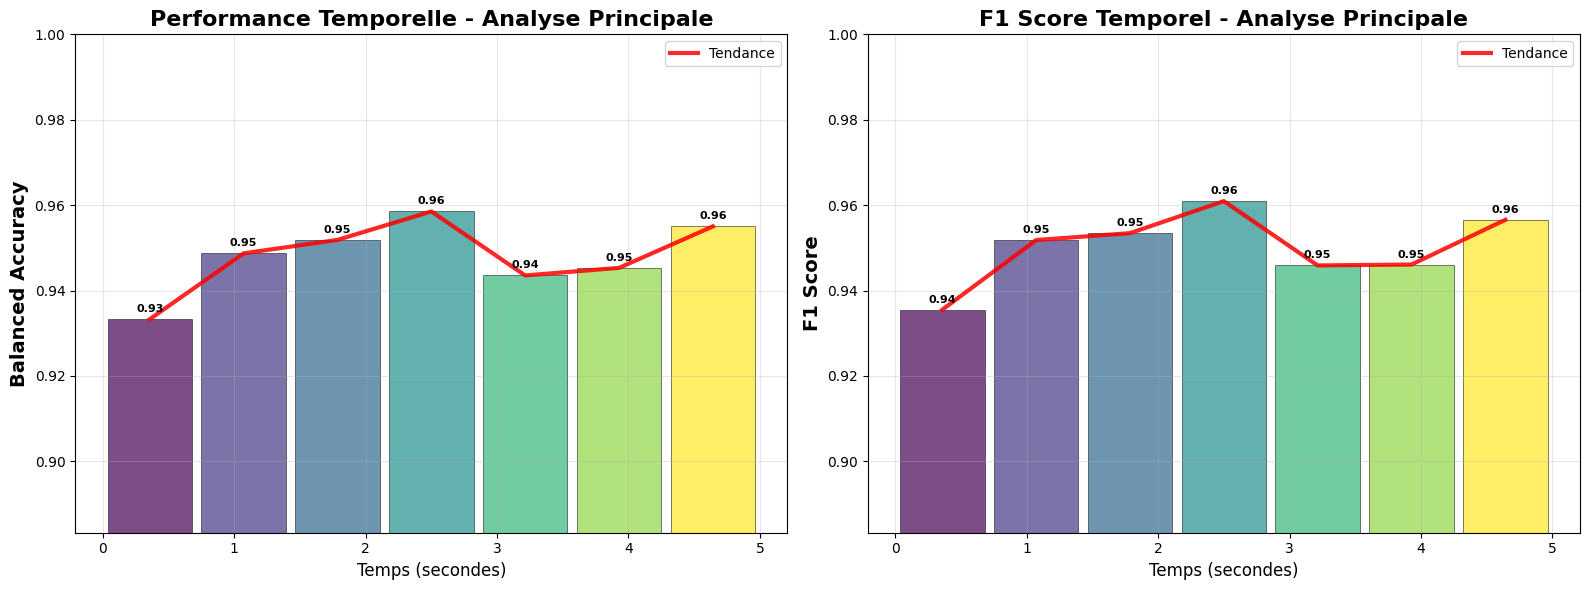

📊 Échelle automatique (conditions): 0.85 - 1.00


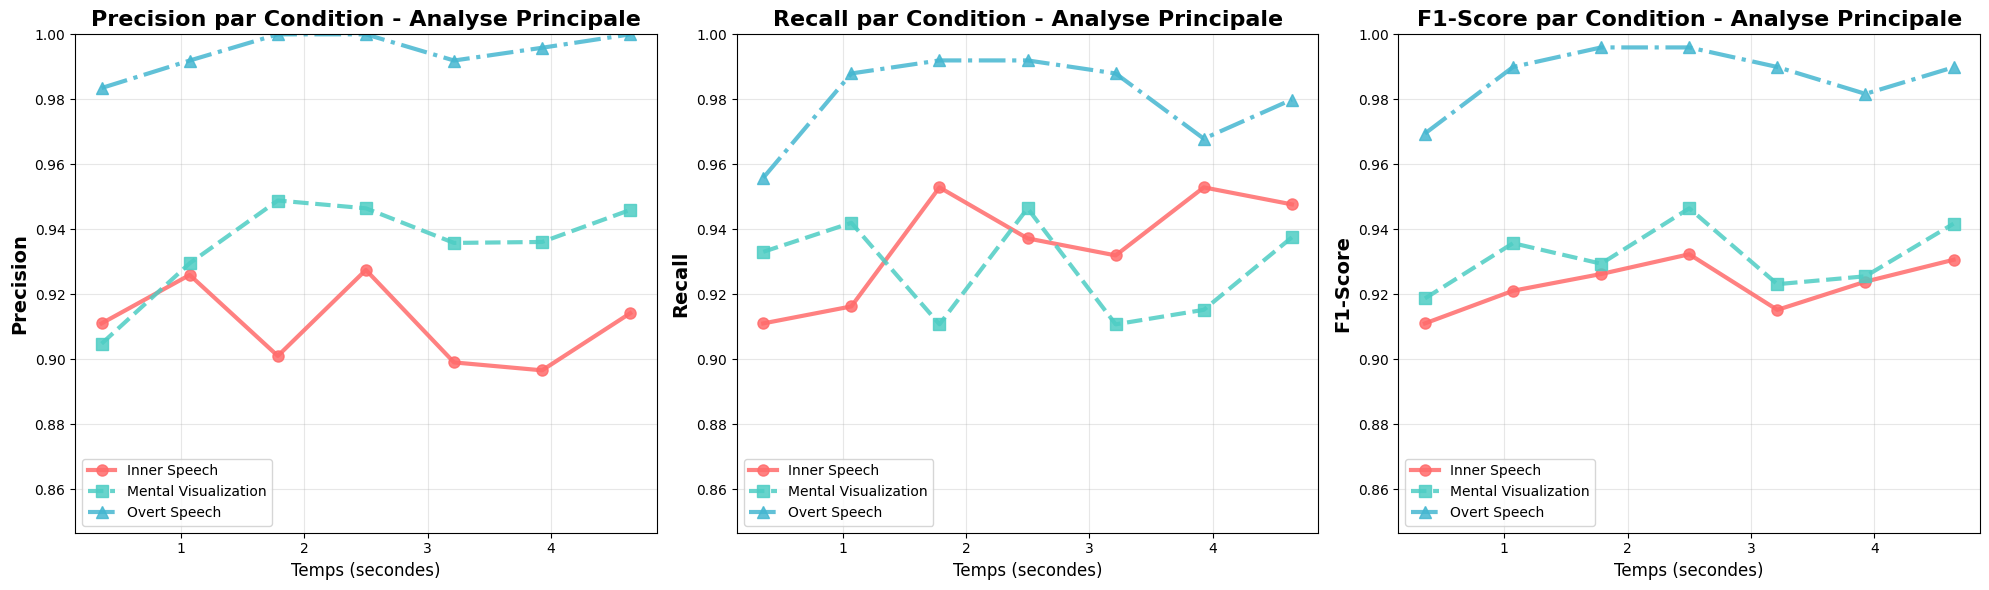


📊 STATISTIQUES DÉTAILLÉES - Analyse Principale

🔍 Inner Speech:
   F1 moyen: 0.923 ± 0.007
   F1 min-max: 0.911 - 0.932
   Amélioration: 0.021

🔍 Mental Visualization:
   F1 moyen: 0.931 ± 0.009
   F1 min-max: 0.919 - 0.946
   Amélioration: 0.028

🔍 Overt Speech:
   F1 moyen: 0.988 ± 0.009
   F1 min-max: 0.969 - 0.996
   Amélioration: 0.027

🧪 ÉTAPE 5: Diagnostics
🎯 LATENCE D'INITIATION: 0.00s (@ segment_1) — BA=0.933
🏔️ PIC: 2.14s, BA: 0.959
🔚 FIN (moyenne dernier quart): 0.955
📉 Chute: 0.004
   ⚠️ Pas d'évidence de fin précoce

📋 SYNTHÈSE
🚀 Latence d'initiation: 0.00s (seuil=0.433)
🔚 Fin précoce: Non (Δ=0.004)

🎉 ANALYSE TEMPORELLE TERMINÉE


In [5]:
# -*- coding: utf-8 -*-
"""
Unified temporal analysis pipeline (5s window) with:
- data verification
- feature extraction per temporal segment
- per-segment ML (RF + GridSearch)
- improved visualizations (auto y-scale, time axis in seconds)
- diagnostics: initiation latency & early termination

Usage (example):
results = run_temporal_analysis_unified(
    df_in_path='csv/centered_rectified_data.csv',
    df_out_path='csv/temporal_features.csv',
    n_segments=50,
    conditions=['inner_speech', 'mental_visualization', 'overt_speech'],
    random_state=42
)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import median_abs_deviation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report


# --------------------------- Data checks & feature extraction ---------------------------

def verify_data_consistency(df_path: str, expected_window_s: float = 5.0, expected_hz: int = 1000):
    """
    Vérifie la cohérence entre durée (~5s), fréquence (~1000 Hz) et nombre de points.
    Retourne (is_consistent: bool, n_points: int, estimated_freq: float)
    """
    df = pd.read_csv(df_path)
    data_columns = [col for col in df.columns if col.startswith('data_point')]
    n_points = len(data_columns)

    print(f"Nombre de data_points trouvés: {n_points}")
    print(f"Nombre attendu ({expected_window_s}s × {expected_hz} Hz): {int(expected_window_s * expected_hz)}")
    print(f"Durée réelle calculée: {n_points / expected_hz:.2f} secondes")

    expected_points = int(expected_window_s * expected_hz)
    if abs(n_points - expected_points) < 50:  # Tolérance ±50 points
        print("✅ Cohérence vérifiée pour ~1000 Hz et ~5s !")
        return True, n_points, expected_hz
    else:
        print("⚠️ Incohérence détectée - estimation automatique de la fréquence")
        estimated_freq = n_points / expected_window_s if expected_window_s > 0 else np.nan
        return False, n_points, estimated_freq


def extract_temporal_features_final(df_in_path: str, df_out_path: str, n_segments: int = 5):
    """
    Extraction robuste des features temporelles segmentées (compatible toutes versions pandas).
    - Z-score par sujet/canal vs baseline 'control_baseline'
    - Features: z_score (mean), std, median, mad, iqr par ligne (trial)
    Sauvegarde un CSV fusionné pour tous les segments.
    """
    print("🔍 Vérification de la cohérence des données...")
    df = pd.read_csv(df_in_path)
    data_columns = [col for col in df.columns if col.startswith('data_point')]
    n_timepoints = len(data_columns)

    print(f"📊 Nombre de colonnes data_point trouvées: {n_timepoints}")
    if len(data_columns) == 0:
        print("❌ ERREUR: Aucune colonne commençant par 'data_point' trouvée!")
        return None

    # Vérification informative
    _ = verify_data_consistency(df_in_path)

    # Découpage équitable en n_segments
    points_per_segment = n_timepoints // n_segments
    print(f"📊 Segmentation: {n_segments} segments, ~{points_per_segment} points/segment")

    all_results = []
    print(f"\n📊 Segmentation en {n_segments} segments:")

    # Pré-calcul baseline stats (moyenne / écart-type) par (subject, channel)
    baseline = df[df['condition'] == 'control_baseline']

    def flatten_stats(group):
        vals = group[data_columns].to_numpy().ravel()
        mean = vals.mean()
        std = vals.std(ddof=0)
        if std == 0 or np.isnan(std):
            std = 1e-8
        return pd.Series({'baseline_mean': mean, 'baseline_std': std})

    baseline_stats = (
        baseline.groupby(['subject', 'channel'])
                .apply(flatten_stats)
                .reset_index()
    )

    for segment_idx in range(n_segments):
        # Bornes du segment
        start_idx = segment_idx * points_per_segment
        end_idx = n_timepoints if segment_idx == n_segments - 1 else (segment_idx + 1) * points_per_segment

        segment_columns = data_columns[start_idx:end_idx]
        segment_name = f"segment_{segment_idx+1}"

        print(f"  {segment_name}: points {start_idx} à {end_idx-1} ({len(segment_columns)} points)")

        if len(segment_columns) == 0:
            print(f"    ⚠️ Segment vide, ignoré")
            continue

        # Merge baseline stats
        df_segment = df.merge(baseline_stats, on=['subject', 'channel'], how='left')

        # Z-score du segment
        z_scored_data = (df_segment[segment_columns].sub(df_segment['baseline_mean'], axis=0)) \
                        .div(df_segment['baseline_std'], axis=0)

        # Features par ligne
        segment_features = pd.DataFrame({
            'subject': df_segment['subject'],
            'trial': df_segment['trial'],
            'condition': df_segment['condition'],
            'channel': df_segment['channel'],
            'segment': segment_name,
            'z_score': z_scored_data.mean(axis=1),
            'std': z_scored_data.std(axis=1),
            'median': z_scored_data.median(axis=1),
            'mad': z_scored_data.apply(lambda x: median_abs_deviation(x), axis=1),
            'iqr': z_scored_data.apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25), axis=1),
        })

        print(f"    ✅ Features extraites: {len(segment_features)} lignes")
        all_results.append(segment_features)

    if not all_results:
        print("❌ ERREUR: Aucun segment traité avec succès!")
        return None

    # Concat & save
    result_df = pd.concat(all_results, ignore_index=True)
    result_df.to_csv(df_out_path, index=False)

    print(f"\n✅ Features temporelles sauvegardées: {df_out_path}")
    print(f"📈 Total des lignes: {len(result_df)}")
    return result_df


# --------------------------- Dataset prep per segment ---------------------------

def preprocess_segment_data(df: pd.DataFrame):
    """
    Nettoyage & mise en forme:
    - supprime sujets avec NaN
    - impose canaux requis
    - pivot en large: (features × channel)
    - filtre sujets avec ≥4 trials/condition
    """
    rows_with_nan = df[df.isna().any(axis=1)]
    subjects_with_nan = rows_with_nan['subject'].unique()
    df_cleaned = df[~df['subject'].isin(subjects_with_nan)]

    required_channels = ['ooi', 'nek', 'zyg', 'for', 'fro']
    valid_trials = df_cleaned.groupby(['subject', 'trial']).filter(
        lambda x: set(x['channel']) == set(required_channels)
    )

    df_wide = valid_trials.pivot_table(
        index=['subject', 'trial', 'condition'],
        columns='channel',
        values=['z_score', 'std', 'median', 'mad', 'iqr']
    )
    df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
    df_wide.reset_index(inplace=True)

    trials_per_condition = df_wide.groupby(['subject', 'condition']).size().reset_index(name='trial_count')
    valid_conditions = trials_per_condition[trials_per_condition['trial_count'] >= 4]
    df_wide_filtered = pd.merge(df_wide, valid_conditions[['subject', 'condition']],
                                on=['subject', 'condition'], how='inner')
    return df_wide_filtered


def create_segment_datasets(temporal_features_df: pd.DataFrame):
    """
    Crée un dict {segment_name -> df_wide_filtered}, trié numériquement.
    """
    segments = {}
    print("📁 Création des datasets par segment:")

    segment_names = temporal_features_df['segment'].unique()
    segment_names_sorted = sorted(segment_names, key=lambda x: int(x.split('_')[1]))

    for segment_name in segment_names_sorted:
        segment_data = temporal_features_df[temporal_features_df['segment'] == segment_name].copy()
        segment_data = segment_data.drop('segment', axis=1)
        processed_data = preprocess_segment_data(segment_data)
        segments[segment_name] = processed_data
        print(f"  {segment_name}: {len(processed_data)} trials, {len(processed_data['subject'].unique())} sujets")
    return segments


# --------------------------- Per-segment ML & metrics ---------------------------

def train_and_evaluate_temporal_by_condition(df: pd.DataFrame,
                                             channels, features, conditions,
                                             segment_name: str, seed: int = 42):
    """
    Entraîne RF par sujet (split train/test) puis agrège les prédictions.
    Retourne metrics globaux + classification_report (pour courbes par condition).
    """
    np.random.seed(seed)
    df = df[df['condition'].isin(conditions)]

    all_y_test, all_y_pred = [], []
    subjects_processed = 0

    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [10, 20],
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }

    selected_columns = [f"{feature}_{channel}" for feature in features for channel in channels]

    for subject in df['subject'].unique():
        subject_data = df[df['subject'] == subject]
        # garde uniquement les colonnes présentes (au cas où)
        cols_present = [c for c in selected_columns if c in subject_data.columns]
        if len(cols_present) == 0:
            continue

        X = subject_data[cols_present]
        y = subject_data['condition']

        if len(X) < 10 or len(y.unique()) < 2:
            continue

        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=seed, stratify=y
            )
            rf = RandomForestClassifier(random_state=seed)
            grid_search = GridSearchCV(
                estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, scoring='f1_weighted'
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

            y_pred = best_model.predict(X_test)
            all_y_test.extend(y_test)
            all_y_pred.extend(y_pred)
            subjects_processed += 1
        except Exception:
            # Ignore subject if split or training fails
            continue

    if len(all_y_test) > 0:
        global_balanced_acc = balanced_accuracy_score(all_y_test, all_y_pred)
        global_f1 = f1_score(all_y_test, all_y_pred, average='weighted')
        report = classification_report(all_y_test, all_y_pred, output_dict=True, zero_division=0)

        print(f"    ✅ {subjects_processed} sujets traités")
        print(f"    📊 Balanced Accuracy: {global_balanced_acc:.3f} | F1: {global_f1:.3f}")

        return {
            'balanced_accuracy': global_balanced_acc,
            'f1_score': global_f1,
            'subjects_processed': subjects_processed,
            'predictions': (all_y_test, all_y_pred),
            'condition_metrics': report
        }
    else:
        print(f"    ❌ Aucun sujet traité avec succès")
        return None


def temporal_classification_analysis(segment_datasets: dict, channels, features, conditions, seed: int = 42):
    """
    Compare classification performance across temporal segments (tri numérique).
    """
    results = {}
    print("🤖 Analyse de classification temporelle:")
    print("="*70)

    segment_names = list(segment_datasets.keys())
    segment_names_sorted = sorted(segment_names, key=lambda x: int(x.split('_')[1]))

    for segment_name in segment_names_sorted:
        segment_data = segment_datasets[segment_name]
        print(f"\n🔍 Analyse {segment_name}:")
        print("-" * 50)
        segment_results = train_and_evaluate_temporal_by_condition(
            segment_data, channels, features, conditions, segment_name, seed=seed
        )
        results[segment_name] = segment_results
    return results


# --------------------------- Diagnostics (latency & early termination) ---------------------------

def analyze_initiation_latency_from_results(temporal_results: dict,
                                            window_s: float = 5.0,
                                            classes: int = 3,
                                            delta_over_chance: float = 0.1):
    """
    Détecte la première montée au-dessus de (chance + delta).
    """
    segments = sorted(temporal_results.keys(), key=lambda x: int(x.split('_')[1]))
    accuracies = [temporal_results[seg]['balanced_accuracy'] for seg in segments]
    n_segments = len(segments)

    baseline_performance = 1.0 / classes
    activation_threshold = baseline_performance + delta_over_chance

    activation_segment, activation_time = None, None
    for i, (segment, accuracy) in enumerate(zip(segments, accuracies)):
        if accuracy > activation_threshold:
            activation_segment = segment
            activation_time = i * (window_s / n_segments)  # seconds (left edge)
            break

    if activation_segment:
        print(f"🎯 LATENCE D'INITIATION: {activation_time:.2f}s (@ {activation_segment}) "
              f"— BA={temporal_results[activation_segment]['balanced_accuracy']:.3f}")
    else:
        print("⚠️ Pas de latence d'initiation claire détectée")

    return {
        'activation_segment': activation_segment,
        'activation_time_s': activation_time,
        'threshold': activation_threshold
    }


def analyze_early_termination_from_results(temporal_results: dict, window_s: float = 5.0, drop_threshold: float = 0.05):
    """
    Compare le pic à la moyenne du dernier quart pour détecter une fin précoce.
    """
    segments = sorted(temporal_results.keys(), key=lambda x: int(x.split('_')[1]))
    accuracies = [temporal_results[seg]['balanced_accuracy'] for seg in segments]
    n_segments = len(segments)

    if n_segments == 0:
        return None

    last_quarter = accuracies[-max(1, n_segments // 4):]
    peak_performance = max(accuracies)
    peak_index = accuracies.index(peak_performance)
    peak_time = (peak_index * (window_s / n_segments))  # seconds

    end_performance = float(np.mean(last_quarter))
    performance_drop = peak_performance - end_performance

    print(f"🏔️ PIC: {peak_time:.2f}s, BA: {peak_performance:.3f}")
    print(f"🔚 FIN (moyenne dernier quart): {end_performance:.3f}")
    print(f"📉 Chute: {performance_drop:.3f}")

    early_termination = performance_drop > drop_threshold
    print("   ✅ FIN PRÉCOCE DÉTECTÉE!" if early_termination else "   ⚠️ Pas d'évidence de fin précoce")

    return {
        'peak_time_s': peak_time,
        'peak_performance': peak_performance,
        'end_performance': end_performance,
        'performance_drop': performance_drop,
        'early_termination': early_termination
    }


# --------------------------- Improved visualizations ---------------------------

def improved_plot_condition_curves(results: dict, conditions, title_suffix: str = "", window_s: float = 5.0):
    """
    Courbes Precision/Recall/F1 par condition avec échelle automatique & NaN handling.
    Axe X en secondes (centre des segments).
    """
    valid_results = {k: v for k, v in results.items() if v is not None}
    if not valid_results:
        print("❌ Aucun résultat valide pour tracer les courbes")
        return

    segment_names = list(valid_results.keys())
    segments = sorted(segment_names, key=lambda x: int(x.split('_')[1]))
    n_segments = len(segments)

    condition_data = {cond: {'precision': [], 'recall': [], 'f1': []} for cond in conditions}
    all_values = []

    for seg in segments:
        report = valid_results[seg]['condition_metrics']
        for cond in conditions:
            if cond in report:
                precision = report[cond].get('precision', np.nan)
                recall = report[cond].get('recall', np.nan)
                f1 = report[cond].get('f1-score', np.nan)
            else:
                precision = recall = f1 = np.nan
            condition_data[cond]['precision'].append(precision)
            condition_data[cond]['recall'].append(recall)
            condition_data[cond]['f1'].append(f1)
            all_values.extend([precision, recall, f1])

    valid_values = [v for v in all_values if not np.isnan(v)]
    if valid_values:
        y_min = max(0.0, min(valid_values) - 0.05)
        y_max = min(1.0, max(valid_values) + 0.05)
    else:
        y_min, y_max = 0.0, 1.0

    print(f"📊 Échelle automatique (conditions): {y_min:.2f} - {y_max:.2f}")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
    line_styles = ['-', '--', '-.', ':', '-', '--']
    markers = ['o', 's', '^', 'D', 'v', 'p']

    # centres temporels des segments
    time_points = [(i + 0.5) * (window_s / n_segments) for i in range(n_segments)]

    # Precision
    for i, cond in enumerate(conditions):
        vals = condition_data[cond]['precision']
        valid_idx = [j for j, v in enumerate(vals) if not np.isnan(v)]
        if not valid_idx:
            continue
        t = [time_points[j] for j in valid_idx]
        y = [vals[j] for j in valid_idx]
        ax1.plot(t, y,
                 marker=markers[i % len(markers)],
                 linestyle=line_styles[i % len(line_styles)],
                 linewidth=3, markersize=8,
                 color=colors[i % len(colors)],
                 label=cond.replace('_', ' ').title(),
                 alpha=0.85)
    ax1.set_ylabel('Precision', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Temps (secondes)', fontsize=12)
    ax1.set_title(f'Precision par Condition{title_suffix}', fontsize=16, fontweight='bold')
    ax1.set_ylim(y_min, y_max)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)

    # Recall
    for i, cond in enumerate(conditions):
        vals = condition_data[cond]['recall']
        valid_idx = [j for j, v in enumerate(vals) if not np.isnan(v)]
        if not valid_idx:
            continue
        t = [time_points[j] for j in valid_idx]
        y = [vals[j] for j in valid_idx]
        ax2.plot(t, y,
                 marker=markers[i % len(markers)],
                 linestyle=line_styles[i % len(line_styles)],
                 linewidth=3, markersize=8,
                 color=colors[i % len(colors)],
                 label=cond.replace('_', ' ').title(),
                 alpha=0.85)
    ax2.set_ylabel('Recall', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Temps (secondes)', fontsize=12)
    ax2.set_title(f'Recall par Condition{title_suffix}', fontsize=16, fontweight='bold')
    ax2.set_ylim(y_min, y_max)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)

    # F1
    for i, cond in enumerate(conditions):
        vals = condition_data[cond]['f1']
        valid_idx = [j for j, v in enumerate(vals) if not np.isnan(v)]
        if not valid_idx:
            continue
        t = [time_points[j] for j in valid_idx]
        y = [vals[j] for j in valid_idx]
        ax3.plot(t, y,
                 marker=markers[i % len(markers)],
                 linestyle=line_styles[i % len(line_styles)],
                 linewidth=3, markersize=8,
                 color=colors[i % len(colors)],
                 label=cond.replace('_', ' ').title(),
                 alpha=0.85)
    ax3.set_ylabel('F1-Score', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Temps (secondes)', fontsize=12)
    ax3.set_title(f'F1-Score par Condition{title_suffix}', fontsize=16, fontweight='bold')
    ax3.set_ylim(y_min, y_max)
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    # Statistiques détaillées
    print(f"\n📊 STATISTIQUES DÉTAILLÉES{title_suffix}")
    print("=" * 60)
    for cond in conditions:
        f1_vals = [v for v in condition_data[cond]['f1'] if not np.isnan(v)]
        if f1_vals:
            mean_f1 = np.mean(f1_vals)
            std_f1 = np.std(f1_vals)
            min_f1 = min(f1_vals)
            max_f1 = max(f1_vals)
            print(f"\n🔍 {cond.replace('_', ' ').title()}:")
            print(f"   F1 moyen: {mean_f1:.3f} ± {std_f1:.3f}")
            print(f"   F1 min-max: {min_f1:.3f} - {max_f1:.3f}")
            print(f"   Amélioration: {max_f1 - min_f1:.3f}")


def improved_visualize_temporal_results(results: dict, conditions, title_suffix: str = "", window_s: float = 5.0):
    """
    Bar + trend (Balanced Accuracy, F1) vs TEMPS (secondes), auto y-scale, + courbes par condition.
    """
    valid_results = {k: v for k, v in results.items() if v is not None}
    if not valid_results:
        print("❌ Aucun résultat valide à visualiser")
        return

    segment_names = list(valid_results.keys())
    segments = sorted(segment_names, key=lambda x: int(x.split('_')[1]))
    n_segments = len(segments)

    accuracies = [valid_results[seg]['balanced_accuracy'] for seg in segments]
    f1_scores = [valid_results[seg]['f1_score'] for seg in segments]

    all_scores = accuracies + f1_scores
    y_min = max(0.0, min(all_scores) - 0.05)
    y_max = min(1.0, max(all_scores) + 0.05)
    print(f"📊 Échelle automatique (global): {y_min:.2f} - {y_max:.2f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Temps (centre des segments)
    time_points = [(i + 0.5) * (window_s / n_segments) for i in range(n_segments)]
    colors = plt.cm.viridis(np.linspace(0, 1, n_segments))

    # Balanced Accuracy
    bars1 = ax1.bar(time_points, accuracies,
                    width=(window_s * 0.9 / n_segments),
                    color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax1.plot(time_points, accuracies, 'r-', linewidth=3, alpha=0.85, label='Tendance')
    ax1.set_ylabel('Balanced Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Temps (secondes)', fontsize=12)
    ax1.set_title(f'Performance Temporelle{title_suffix}', fontsize=16, fontweight='bold')
    ax1.set_ylim(y_min, y_max)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    if n_segments <= 20:
        for bar, acc, t in zip(bars1, accuracies, time_points):
            h = bar.get_height()
            ax1.text(t, h + (y_max - y_min) * 0.01, f'{acc:.2f}',
                     ha='center', va='bottom', fontsize=8, fontweight='bold')

    # F1 Score
    bars2 = ax2.bar(time_points, f1_scores,
                    width=(window_s * 0.9 / n_segments),
                    color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax2.plot(time_points, f1_scores, 'r-', linewidth=3, alpha=0.85, label='Tendance')
    ax2.set_ylabel('F1 Score', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Temps (secondes)', fontsize=12)
    ax2.set_title(f'F1 Score Temporel{title_suffix}', fontsize=16, fontweight='bold')
    ax2.set_ylim(y_min, y_max)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    if n_segments <= 20:
        for bar, f1v, t in zip(bars2, f1_scores, time_points):
            h = bar.get_height()
            ax2.text(t, h + (y_max - y_min) * 0.01, f'{f1v:.2f}',
                     ha='center', va='bottom', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Courbes par condition
    improved_plot_condition_curves(results, conditions, title_suffix, window_s=window_s)


# --------------------------- Orchestrator ---------------------------

def run_temporal_analysis_unified(df_in_path: str,
                                  df_out_path: str,
                                  n_segments: int,
                                  conditions,
                                  random_state: int = 42):
    """
    Pipeline complet (fenêtre = 5s):
      CSV -> features segmentées -> datasets par segment -> ML par segment ->
      visualisations améliorées -> diagnostics (latence / fin précoce)

    Returns:
      {
        'temporal_results': {segment_i: {...metrics...}},
        'latency': {...},
        'early_termination': {...}
      }
    """
    WINDOW_S = 5.0  # demandé: fenêtre toujours 5s (utilisée uniquement pour l'axe temps & diagnostics)

    print("🚀 DÉBUT DE L'ANALYSE TEMPORELLE (UNIFIÉE)")
    print("=" * 70)
    print(f"Paramètres: {n_segments} segments | Conditions: {conditions}")
    print("=" * 70)

    try:
        # 1) Features
        print(f"\n📊 ÉTAPE 1: Extraction des features temporelles ({n_segments} segments)")
        features_df = extract_temporal_features_final(df_in_path, df_out_path, n_segments=n_segments)
        if features_df is None:
            return None

        # 2) Datasets par segment
        print("\n📁 ÉTAPE 2: Création des datasets par segment")
        segment_datasets = create_segment_datasets(features_df)

        # 3) ML par segment
        print(f"\n🤖 ÉTAPE 3: Analyse de classification temporelle")
        channels = ['for', 'fro', 'nek', 'ooi', 'zyg']
        feats = ['z_score', 'iqr', 'mad', 'median', 'std']
        temporal_results = temporal_classification_analysis(
            segment_datasets, channels=channels, features=feats,
            conditions=conditions, seed=random_state
        )

        # 4) Visualisation
        print("\n📈 ÉTAPE 4: Visualisation des résultats")
        improved_visualize_temporal_results(temporal_results, conditions, title_suffix=" - Analyse Principale", window_s=WINDOW_S)

        # 5) Diagnostics
        print("\n🧪 ÉTAPE 5: Diagnostics")
        valid_temporal_results = {k: v for k, v in temporal_results.items() if v is not None}
        latency = analyze_initiation_latency_from_results(valid_temporal_results, window_s=WINDOW_S, classes=len(conditions))
        early_term = analyze_early_termination_from_results(valid_temporal_results, window_s=WINDOW_S)

        # 6) Synthèse
        print("\n📋 SYNTHÈSE")
        print("=" * 50)
        if latency and latency.get('activation_time_s') is not None:
            print(f"🚀 Latence d'initiation: {latency['activation_time_s']:.2f}s (seuil={latency['threshold']:.3f})")
        else:
            print("🚀 Latence d'initiation: non détectée")
        if early_term:
            print(f"🔚 Fin précoce: {'Oui' if early_term['early_termination'] else 'Non'} "
                  f"(Δ={early_term['performance_drop']:.3f})")

        print("\n🎉 ANALYSE TEMPORELLE TERMINÉE")
        return {
            'temporal_results': temporal_results,
            'latency': latency,
            'early_termination': early_term
        }

    except Exception as e:
        print(f"\n❌ ERREUR lors de l'analyse temporelle: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
    
results = run_temporal_analysis_unified(
    df_in_path='csv/centered_rectified_data.csv',   # your input CSV with data_point* columns
    df_out_path='csv/temporal_features.csv',        # where to save extracted features
    n_segments=7,                                  # <- change this as you like
    conditions=['inner_speech', 'mental_visualization', 'overt_speech'],
    random_state=42
)

In [32]:
# Latency & early termination
print("\nLatency:", results['latency'])
print("Early termination:", results['early_termination'])

# Per-segment summary
valid = {k:v for k,v in results['temporal_results'].items() if v is not None}
for seg in sorted(valid, key=lambda x: int(x.split('_')[1])):
    r = valid[seg]
    print(f"{seg}: BA={r['balanced_accuracy']:.3f}, F1={r['f1_score']:.3f}, subjects={r['subjects_processed']}")



Latency: {'activation_segment': 'segment_1', 'activation_time_s': 0.0, 'threshold': 0.43333333333333335}
Early termination: {'peak_time_s': 3.0, 'peak_performance': 0.9031922379120071, 'end_performance': 0.8768182850449416, 'performance_drop': 0.026373952867065453, 'early_termination': False}
segment_1: BA=0.840, F1=0.846, subjects=35
segment_2: BA=0.842, F1=0.848, subjects=35
segment_3: BA=0.862, F1=0.868, subjects=35
segment_4: BA=0.866, F1=0.873, subjects=35
segment_5: BA=0.870, F1=0.876, subjects=35
segment_6: BA=0.850, F1=0.858, subjects=35
segment_7: BA=0.860, F1=0.868, subjects=35
segment_8: BA=0.884, F1=0.891, subjects=35
segment_9: BA=0.885, F1=0.892, subjects=35
segment_10: BA=0.878, F1=0.884, subjects=35
segment_11: BA=0.880, F1=0.887, subjects=35
segment_12: BA=0.873, F1=0.881, subjects=35
segment_13: BA=0.895, F1=0.900, subjects=35
segment_14: BA=0.890, F1=0.896, subjects=35
segment_15: BA=0.898, F1=0.904, subjects=35
segment_16: BA=0.885, F1=0.892, subjects=35
segment_17